# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [11]:
#importing some useful packages
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


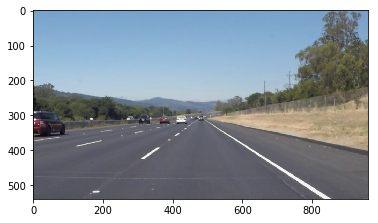

In [12]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions


Below are some helper functions to help get you started. They should look familiar from the lesson!

In [165]:
import math


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    #cv2.fillPoly(mask, vertices, ignore_mask_color)
    cv2.fillPoly(mask, np.array([vertices], dtype=np.int32), ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def slope(line):
    for x1,y1,x2,y2 in line:
        m = (y2-y1)/(x2-x1)
    return m
        

def slope2(v1,v2):
    x1=v1[0][0]
    y1=v1[0][1]
    x2=v2[0][0]
    y2=v2[0][1]
   
    m = (y2-y1)/(x2-x1)
    c=v1[0][1] - m*v1[0][0]
    print ('x1,x2,m and c',v1[0][0],v2[0][1], m , c)
    return m,c

def lineAverager(line):
    for x1,y1,x2,y2 in line:
        x=(x1+x2)/2
        y=(y1+y2)/2
    
    return x,y


def Outliers(slopes, threshold = 1.5  ):
    # Set upper and lower limit to 3 standard deviation
    slope_data_std = np.std(slopes)
    slope_data_mean = np.mean(slopes)
    anomaly_cut_off = slope_data_std * threshold
    
    lower_limit  = slope_data_mean - anomaly_cut_off 
    upper_limit = slope_data_mean + anomaly_cut_off
    print(lower_limit)
    # Generate outliers
    anomalies = []
    for index,outlier in enumerate(slopes):
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies


def clean_lines(left_lines):
    print (type(left_lines)) 
    sl = [] 
    for elements in left_lines:
        sl.append(elements[1])
    #x=[0.95,0.65,0.63,0.64,0.31]
    outliers=Outliers(sl)
    print('Outlier elements->' ,outliers )
    
    
    vlines=[]
    for element in left_lines:
        for liers in outliers:
            if(elements[1] == liers  ):
                left_lines.remove(element)
        vlines.append(element[0])
               
    #print ('Cleaned array -> ', x)        
    return vlines


def tpolyfit_lines(lines):
    x = []
    y = []
    for x1, y1, x2, y2 in lines:
        x += [x1, x2]
        y += [y1, y2]
    
    z = np.polyfit(x, y, 1)
    print(z)
    f = np.poly1d(z)
    
    return z

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lines = []
    right_lines = []
    for line in lines:
        if(slope(line) < 0 ):
            print ('Line -> ',line, 'Slope ->', slope(line)  ) 
            color1 = [255,0,0]
            left_lines.append([line,slope(line)])            
        else:
            right_lines.append(line) 
            color1 = [0,255,0]
               
        #for x1,y1,x2,y2 in line:
         #   cv2.line(img, (x1, y1), (x2, y2), color1, thickness)
    
    
    valid_left_lines=clean_lines(left_lines)
    print ('valid_left -> ', valid_left_lines )
    
    z=tpolyfit_lines(valid_left_lines)
    #print z
    
    #print ((right_lines))

    #left_coords=np.array(left_lines)    
    #print ( np.min(left_coords[:,1]) , np.where( left_coords  == np.min(left_coords[:,1]))[0] )
    #print ( np.max(left_coords[:,1]) , np.where( left_coords  == np.max(left_coords[:,1]))[0] ) 
    
    #v_top=left_coords[np.where( left_coords  == np.min(left_coords[:,1]))[0]]
   #v_bottom=left_coords[np.where( left_coords  == np.max(left_coords[:,1]))[0]]
    
    #print (v_top)
    #print (v_bottom)
    #m,c = slope2(v_top,v_bottom)  
    #print ('m and c', m , c)
    #xcoord= (540-c)/m
    
    
    
    #cv2.line(img, ( int(xcoord) ,540),( int(v_top[0][0]), int(v_top[0][1])), color1, thickness)
    
    #for line in lines:
        #print (line)
     #   for x1,y1,x2,y2 in line:
      #      cv2.line(img, (x1, y1), (x2, y2), color1, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [166]:
import os
import numpy as np
import matplotlib.pyplot as plt
dirs = os.listdir("test_images/") 

fig=plt.figure()
#for img in dirs:
img = 'solidWhiteCurve.jpg'

i=0    
while ( i < 1 ):
    
    print('************************************')
    image = mpimg.imread( 'test_images/'+img )

    #convert to grayscale
    img_gray=grayscale(image)
    #plt.imshow(img_gray)
    
    kernel_size=7
    gaussian_blur_img= gaussian_blur(img_gray,kernel_size)

    low_threshold = 50
    high_threshold = 150
    edges=canny(gaussian_blur_img, low_threshold, high_threshold)

    #plt.imshow(edges)

    #vertices_t = np.array([[130,540],[420,320],[550,320],[860,540]],dtype=np.int32)
    vertices_t = np.array([[50,540],[435,320],[510,320],[900,540]],dtype=np.int32)


    masked_edges = region_of_interest(edges, vertices_t)
    #plt.imshow(masked_edges)


    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 5 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 100   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 200   # maximum gap in pixels between connectable line segments

    t=hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    #plt.imshow(t)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    
    #top=weighted_img(color_edges, image, α=0.8, β=1, γ=0)
    top=weighted_img(t, image, α=0.8, β=1, γ=0)
    plt.figure()

    i = i+1
    plt.imshow(top)

************************************
Line ->  [[281 459 469 322]] Slope -> -0.728723404255
Line ->  [[291 462 409 360]] Slope -> -0.864406779661
Line ->  [[293 462 415 356]] Slope -> -0.868852459016
Line ->  [[303 442 465 320]] Slope -> -0.753086419753
<class 'list'>
-0.898971080248
Outlier elements-> []
valid_left ->  [array([[281, 459, 469, 322]], dtype=int32), array([[291, 462, 409, 360]], dtype=int32), array([[293, 462, 415, 356]], dtype=int32), array([[303, 442, 465, 320]], dtype=int32)]


ValueError: not enough values to unpack (expected 4, got 1)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [158]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [159]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [160]:
def process_image( image ):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)    
    
    print (image.shape)
    
    #image1 = mpimg.imread( image )
    #convert to grayscale
    img_gray=grayscale(image)
    #plt.imshow(img_gray)
    
    kernel_size=7
    gaussian_blur_img= gaussian_blur(img_gray,kernel_size)

    low_threshold = 50
    high_threshold = 150
    edges=canny(gaussian_blur_img, low_threshold, high_threshold)

    #vertices = np.array([[130,540],[420,320],[550,320],[860,540]],dtype=np.int32)
    vertices = np.array( [[ 0,540],[435,320],[510,320],[900,540] ], dtype=np.int32)

    masked_edges = region_of_interest(edges, vertices)
    #plt.imshow(masked_edges)

    # Define the Hough transform parameters
    rho = 5 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 100   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 200   # maximum gap in pixels between connectable line segments

    t=hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create a "color" binary image to combine with line image
    #color_edges = np.dstack((edges, edges, edges)) 
    
    #top=weighted_img(color_edges, image, α=0.8, β=1, γ=0)
    result = weighted_img(t, image, α=0.8, β=1, γ=0)
    return result

Let's try the one with the solid white lane on the right first ...

In [20]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

(540, 960, 3)
Line ->  [[358 388 455 320]] Slope -> -0.701030927835
Line ->  [[235 477 458 321]] Slope -> -0.699551569507
Line ->  [[196 515 287 451]] Slope -> -0.703296703297
Line ->  [[202 514 428 338]] Slope -> -0.778761061947
Line ->  [[187 512 461 320]] Slope -> -0.700729927007
Line ->  [[288 450 365 388]] Slope -> -0.805194805195
Line ->  [[241 486 454 320]] Slope -> -0.779342723005
[[array([[358, 388, 455, 320]], dtype=int32), -0.7010309278350515], [array([[235, 477, 458, 321]], dtype=int32), -0.69955156950672648], [array([[196, 515, 287, 451]], dtype=int32), -0.70329670329670335], [array([[202, 514, 428, 338]], dtype=int32), -0.77876106194690264], [array([[187, 512, 461, 320]], dtype=int32), -0.7007299270072993], [array([[288, 450, 365, 388]], dtype=int32), -0.80519480519480524], [array([[241, 486, 454, 320]], dtype=int32), -0.77934272300469487]]
7
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4

  1%|▏         | 3/222 [00:00<00:08, 26.57it/s]

(540, 960, 3)
Line ->  [[358 388 455 320]] Slope -> -0.701030927835
Line ->  [[235 477 458 321]] Slope -> -0.699551569507
Line ->  [[196 515 287 451]] Slope -> -0.703296703297
Line ->  [[202 514 428 338]] Slope -> -0.778761061947
Line ->  [[187 512 461 320]] Slope -> -0.700729927007
Line ->  [[288 450 365 388]] Slope -> -0.805194805195
Line ->  [[241 486 454 320]] Slope -> -0.779342723005
[[array([[358, 388, 455, 320]], dtype=int32), -0.7010309278350515], [array([[235, 477, 458, 321]], dtype=int32), -0.69955156950672648], [array([[196, 515, 287, 451]], dtype=int32), -0.70329670329670335], [array([[202, 514, 428, 338]], dtype=int32), -0.77876106194690264], [array([[187, 512, 461, 320]], dtype=int32), -0.7007299270072993], [array([[288, 450, 365, 388]], dtype=int32), -0.80519480519480524], [array([[241, 486, 454, 320]], dtype=int32), -0.77934272300469487]]
7
(540, 960, 3)
Line ->  [[151 537 460 320]] Slope -> -0.702265372168
Line ->  [[171 538 399 360]] Slope -> -0.780701754386
Line ->  

  4%|▎         | 8/222 [00:00<00:08, 25.01it/s]

(540, 960, 3)
Line ->  [[285 444 461 320]] Slope -> -0.704545454545
Line ->  [[283 442 449 325]] Slope -> -0.704819277108
Line ->  [[293 444 451 325]] Slope -> -0.753164556962
[[array([[285, 444, 461, 320]], dtype=int32), -0.70454545454545459], [array([[283, 442, 449, 325]], dtype=int32), -0.70481927710843373], [array([[293, 444, 451, 325]], dtype=int32), -0.75316455696202533]]
3
(540, 960, 3)
Line ->  [[250 463 455 320]] Slope -> -0.69756097561
Line ->  [[263 463 460 320]] Slope -> -0.725888324873
[[array([[250, 463, 455, 320]], dtype=int32), -0.69756097560975605], [array([[263, 463, 460, 320]], dtype=int32), -0.7258883248730964]]
2
(540, 960, 3)
Line ->  [[215 491 460 320]] Slope -> -0.697959183673
Line ->  [[214 490 449 326]] Slope -> -0.697872340426
Line ->  [[217 491 461 320]] Slope -> -0.700819672131
Line ->  [[335 412 453 320]] Slope -> -0.779661016949
Line ->  [[326 411 392 363]] Slope -> -0.727272727273
[[array([[215, 491, 460, 320]], dtype=int32), -0.69795918367346943], [arra

  5%|▍         | 11/222 [00:00<00:08, 24.80it/s]

(540, 960, 3)
Line ->  [[229 482 464 323]] Slope -> -0.676595744681
Line ->  [[240 485 467 320]] Slope -> -0.726872246696
Line ->  [[304 429 450 330]] Slope -> -0.678082191781
Line ->  [[231 481 461 320]] Slope -> -0.7
[[array([[229, 482, 464, 323]], dtype=int32), -0.67659574468085104], [array([[240, 485, 467, 320]], dtype=int32), -0.72687224669603523], [array([[304, 429, 450, 330]], dtype=int32), -0.67808219178082196], [array([[231, 481, 461, 320]], dtype=int32), -0.69999999999999996]]
4
(540, 960, 3)
Line ->  [[183 513 459 320]] Slope -> -0.699275362319
Line ->  [[196 516 440 326]] Slope -> -0.77868852459
Line ->  [[194 516 465 320]] Slope -> -0.723247232472
Line ->  [[201 514 454 324]] Slope -> -0.750988142292
[[array([[183, 513, 459, 320]], dtype=int32), -0.69927536231884058], [array([[196, 516, 440, 326]], dtype=int32), -0.77868852459016391], [array([[194, 516, 465, 320]], dtype=int32), -0.7232472324723247], [array([[201, 514, 454, 324]], dtype=int32), -0.75098814229249011]]
4
(54

  7%|▋         | 15/222 [00:00<00:07, 26.36it/s]

Line ->  [[162 537 460 320]] Slope -> -0.728187919463
Line ->  [[192 502 430 341]] Slope -> -0.676470588235
Line ->  [[142 539 454 320]] Slope -> -0.701923076923
[[array([[162, 537, 460, 320]], dtype=int32), -0.72818791946308725], [array([[192, 502, 430, 341]], dtype=int32), -0.67647058823529416], [array([[142, 539, 454, 320]], dtype=int32), -0.70192307692307687]]
3
(540, 960, 3)
Line ->  [[157 538 386 365]] Slope -> -0.755458515284
Line ->  [[138 538 448 321]] Slope -> -0.7
Line ->  [[158 538 389 364]] Slope -> -0.753246753247
Line ->  [[218 489 444 331]] Slope -> -0.699115044248
[[array([[157, 538, 386, 365]], dtype=int32), -0.75545851528384278], [array([[138, 538, 448, 321]], dtype=int32), -0.69999999999999996], [array([[158, 538, 389, 364]], dtype=int32), -0.75324675324675328], [array([[218, 489, 444, 331]], dtype=int32), -0.69911504424778759]]
4
(540, 960, 3)
Line ->  [[306 424 447 322]] Slope -> -0.723404255319
Line ->  [[169 527 451 322]] Slope -> -0.72695035461
Line ->  [[360 3

  8%|▊         | 18/222 [00:00<00:07, 27.36it/s]

(540, 960, 3)
Line ->  [[264 455 453 323]] Slope -> -0.698412698413
Line ->  [[258 460 450 326]] Slope -> -0.697916666667
Line ->  [[346 402 452 322]] Slope -> -0.754716981132
Line ->  [[256 457 423 348]] Slope -> -0.652694610778
Line ->  [[259 460 372 378]] Slope -> -0.725663716814
[[array([[264, 455, 453, 323]], dtype=int32), -0.69841269841269837], [array([[258, 460, 450, 326]], dtype=int32), -0.69791666666666663], [array([[346, 402, 452, 322]], dtype=int32), -0.75471698113207553], [array([[256, 457, 423, 348]], dtype=int32), -0.65269461077844315], [array([[259, 460, 372, 378]], dtype=int32), -0.72566371681415931]]
5
(540, 960, 3)
Line ->  [[224 486 460 321]] Slope -> -0.699152542373
Line ->  [[221 486 457 320]] Slope -> -0.703389830508
Line ->  [[235 485 463 320]] Slope -> -0.723684210526
[[array([[224, 486, 460, 321]], dtype=int32), -0.69915254237288138], [array([[221, 486, 457, 320]], dtype=int32), -0.70338983050847459], [array([[235, 485, 463, 320]], dtype=int32), -0.723684210526

 10%|█         | 23/222 [00:00<00:06, 29.49it/s]

(540, 960, 3)
Line ->  [[231 476 462 320]] Slope -> -0.675324675325
Line ->  [[288 448 455 322]] Slope -> -0.754491017964
Line ->  [[246 478 456 320]] Slope -> -0.752380952381
[[array([[231, 476, 462, 320]], dtype=int32), -0.67532467532467533], [array([[288, 448, 455, 322]], dtype=int32), -0.75449101796407181], [array([[246, 478, 456, 320]], dtype=int32), -0.75238095238095237]]
3
(540, 960, 3)
Line ->  [[234 487 444 329]] Slope -> -0.752380952381
Line ->  [[186 507 446 331]] Slope -> -0.676923076923
Line ->  [[205 508 435 341]] Slope -> -0.726086956522
Line ->  [[203 509 442 329]] Slope -> -0.753138075314
[[array([[234, 487, 444, 329]], dtype=int32), -0.75238095238095237], [array([[186, 507, 446, 331]], dtype=int32), -0.67692307692307696], [array([[205, 508, 435, 341]], dtype=int32), -0.72608695652173916], [array([[203, 509, 442, 329]], dtype=int32), -0.7531380753138075]]
4
(540, 960, 3)


 12%|█▏        | 26/222 [00:00<00:06, 29.47it/s]

Line ->  [[140 538 446 332]] Slope -> -0.673202614379
Line ->  [[163 539 399 361]] Slope -> -0.754237288136
Line ->  [[163 538 433 342]] Slope -> -0.725925925926
[[array([[140, 538, 446, 332]], dtype=int32), -0.67320261437908502], [array([[163, 539, 399, 361]], dtype=int32), -0.75423728813559321], [array([[163, 538, 433, 342]], dtype=int32), -0.72592592592592597]]
3
(540, 960, 3)
Line ->  [[143 537 445 333]] Slope -> -0.675496688742
Line ->  [[229 492 444 330]] Slope -> -0.753488372093
Line ->  [[142 538 431 343]] Slope -> -0.674740484429
Line ->  [[165 539 442 330]] Slope -> -0.754512635379
Line ->  [[143 538 431 344]] Slope -> -0.673611111111
[[array([[143, 537, 445, 333]], dtype=int32), -0.67549668874172186], [array([[229, 492, 444, 330]], dtype=int32), -0.75348837209302322], [array([[142, 538, 431, 343]], dtype=int32), -0.67474048442906576], [array([[165, 539, 442, 330]], dtype=int32), -0.75451263537906132], [array([[143, 538, 431, 344]], dtype=int32), -0.67361111111111116]]
5
(540

 14%|█▎        | 30/222 [00:01<00:06, 30.39it/s]

(540, 960, 3)
Line ->  [[286 440 450 325]] Slope -> -0.701219512195
Line ->  [[294 442 462 320]] Slope -> -0.72619047619
[[array([[286, 440, 450, 325]], dtype=int32), -0.70121951219512191], [array([[294, 442, 462, 320]], dtype=int32), -0.72619047619047616]]
2
(540, 960, 3)
Line ->  [[261 456 449 325]] Slope -> -0.696808510638
Line ->  [[368 389 460 320]] Slope -> -0.75
Line ->  [[350 402 454 324]] Slope -> -0.75
[[array([[261, 456, 449, 325]], dtype=int32), -0.69680851063829785], [array([[368, 389, 460, 320]], dtype=int32), -0.75], [array([[350, 402, 454, 324]], dtype=int32), -0.75]]
3
(540, 960, 3)
Line ->  [[228 484 460 321]] Slope -> -0.702586206897
Line ->  [[226 484 460 320]] Slope -> -0.700854700855
Line ->  [[227 484 453 320]] Slope -> -0.725663716814
Line ->  [[241 483 447 328]] Slope -> -0.752427184466
[[array([[228, 484, 460, 321]], dtype=int32), -0.70258620689655171], [array([[226, 484, 460, 320]], dtype=int32), -0.70085470085470081], [array([[227, 484, 453, 320]], dtype=int

 15%|█▌        | 34/222 [00:01<00:05, 31.78it/s]

 [[168 521 448 325]] Slope -> -0.7
Line ->  [[362 393 460 320]] Slope -> -0.744897959184
Line ->  [[192 516 445 325]] Slope -> -0.754940711462
Line ->  [[322 422 449 326]] Slope -> -0.755905511811
[[array([[168, 521, 448, 325]], dtype=int32), -0.69999999999999996], [array([[362, 393, 460, 320]], dtype=int32), -0.74489795918367352], [array([[192, 516, 445, 325]], dtype=int32), -0.75494071146245056], [array([[322, 422, 449, 326]], dtype=int32), -0.75590551181102361]]
4
(540, 960, 3)
Line ->  [[301 437 448 326]] Slope -> -0.755102040816
Line ->  [[295 437 417 352]] Slope -> -0.696721311475
Line ->  [[292 435 437 334]] Slope -> -0.696551724138
[[array([[301, 437, 448, 326]], dtype=int32), -0.75510204081632648], [array([[295, 437, 417, 352]], dtype=int32), -0.69672131147540983], [array([[292, 435, 437, 334]], dtype=int32), -0.69655172413793098]]
3
(540, 960, 3)
Line ->  [[279 455 448 328]] Slope -> -0.751479289941
Line ->  [[267 453 434 336]] Slope -> -0.700598802395
[[array([[279, 455, 448

 17%|█▋        | 38/222 [00:01<00:06, 30.38it/s]

Line ->  [[235 476 444 329]] Slope -> -0.703349282297
Line ->  [[246 478 448 331]] Slope -> -0.727722772277
Line ->  [[250 477 447 329]] Slope -> -0.751269035533
[[array([[235, 476, 444, 329]], dtype=int32), -0.70334928229665072], [array([[246, 478, 448, 331]], dtype=int32), -0.7277227722772277], [array([[250, 477, 447, 329]], dtype=int32), -0.75126903553299496]]
3
(540, 960, 3)
Line ->  [[359 389 446 330]] Slope -> -0.67816091954
Line ->  [[228 494 434 339]] Slope -> -0.752427184466
Line ->  [[192 506 408 361]] Slope -> -0.671296296296
Line ->  [[202 499 445 329]] Slope -> -0.699588477366
Line ->  [[206 509 308 430]] Slope -> -0.774509803922
[[array([[359, 389, 446, 330]], dtype=int32), -0.67816091954022983], [array([[228, 494, 434, 339]], dtype=int32), -0.75242718446601942], [array([[192, 506, 408, 361]], dtype=int32), -0.67129629629629628], [array([[202, 499, 445, 329]], dtype=int32), -0.69958847736625518], [array([[206, 509, 308, 430]], dtype=int32), -0.77450980392156865]]
5
(540, 

 19%|█▉        | 42/222 [00:01<00:05, 31.94it/s]

Line ->  [[167 539 445 330]] Slope -> -0.751798561151
Line ->  [[145 538 443 330]] Slope -> -0.697986577181
Line ->  [[167 537 441 330]] Slope -> -0.755474452555
Line ->  [[167 538 444 330]] Slope -> -0.750902527076
[[array([[167, 539, 445, 330]], dtype=int32), -0.75179856115107913], [array([[145, 538, 443, 330]], dtype=int32), -0.69798657718120805], [array([[167, 537, 441, 330]], dtype=int32), -0.75547445255474455], [array([[167, 538, 444, 330]], dtype=int32), -0.75090252707581229]]
4
(540, 960, 3)
Line ->  [[333 415 444 331]] Slope -> -0.756756756757
Line ->  [[144 538 441 330]] Slope -> -0.700336700337
Line ->  [[332 415 429 342]] Slope -> -0.752577319588
Line ->  [[334 415 444 332]] Slope -> -0.754545454545
Line ->  [[165 539 443 330]] Slope -> -0.751798561151
Line ->  [[172 533 442 322]] Slope -> -0.781481481481
[[array([[333, 415, 444, 331]], dtype=int32), -0.7567567567567568], [array([[144, 538, 441, 330]], dtype=int32), -0.70033670033670037], [array([[332, 415, 429, 342]], dtyp

 21%|██        | 46/222 [00:01<00:11, 15.92it/s]

Line ->  [[313 428 452 320]] Slope -> -0.776978417266
Line ->  [[296 430 459 320]] Slope -> -0.674846625767
Line ->  [[305 434 451 320]] Slope -> -0.780821917808
[[array([[313, 428, 452, 320]], dtype=int32), -0.7769784172661871], [array([[296, 430, 459, 320]], dtype=int32), -0.67484662576687116], [array([[305, 434, 451, 320]], dtype=int32), -0.78082191780821919]]
3
(540, 960, 3)
Line ->  [[285 448 442 326]] Slope -> -0.777070063694
Line ->  [[270 448 446 329]] Slope -> -0.676136363636
Line ->  [[326 408 443 329]] Slope -> -0.675213675214
[[array([[285, 448, 442, 326]], dtype=int32), -0.77707006369426757], [array([[270, 448, 446, 329]], dtype=int32), -0.67613636363636365], [array([[326, 408, 443, 329]], dtype=int32), -0.67521367521367526]]
3


 22%|██▏       | 49/222 [00:02<00:13, 13.02it/s]

(540, 960, 3)
Line ->  [[254 471 446 326]] Slope -> -0.755208333333
Line ->  [[240 469 445 326]] Slope -> -0.69756097561
[[array([[254, 471, 446, 326]], dtype=int32), -0.75520833333333337], [array([[240, 469, 445, 326]], dtype=int32), -0.69756097560975605]]
2
(540, 960, 3)
Line ->  [[234 486 445 327]] Slope -> -0.75355450237
Line ->  [[200 498 289 434]] Slope -> -0.719101123596
Line ->  [[210 502 441 322]] Slope -> -0.779220779221
Line ->  [[209 502 441 321]] Slope -> -0.780172413793
Line ->  [[223 494 402 355]] Slope -> -0.776536312849
Line ->  [[198 499 443 327]] Slope -> -0.702040816327
[[array([[234, 486, 445, 327]], dtype=int32), -0.75355450236966826], [array([[200, 498, 289, 434]], dtype=int32), -0.7191011235955056], [array([[210, 502, 441, 322]], dtype=int32), -0.77922077922077926], [array([[209, 502, 441, 321]], dtype=int32), -0.78017241379310343], [array([[223, 494, 402, 355]], dtype=int32), -0.77653631284916202], [array([[198, 499, 443, 327]], dtype=int32), -0.702040816326530

 25%|██▍       | 55/222 [00:02<00:12, 13.53it/s]

Slope -> -0.754716981132
Line ->  [[194 498 326 412]] Slope -> -0.651515151515
Line ->  [[137 538 369 376]] Slope -> -0.698275862069
[[array([[138, 539, 440, 328]], dtype=int32), -0.69867549668874174], [array([[230, 481, 385, 365]], dtype=int32), -0.74838709677419357], [array([[158, 539, 423, 339]], dtype=int32), -0.75471698113207553], [array([[194, 498, 326, 412]], dtype=int32), -0.65151515151515149], [array([[137, 538, 369, 376]], dtype=int32), -0.69827586206896552]]
5
(540, 960, 3)
Line ->  [[136 538 442 332]] Slope -> -0.673202614379
Line ->  [[135 538 442 331]] Slope -> -0.674267100977
Line ->  [[157 539 420 341]] Slope -> -0.752851711027
Line ->  [[156 538 438 333]] Slope -> -0.72695035461
[[array([[136, 538, 442, 332]], dtype=int32), -0.67320261437908502], [array([[135, 538, 442, 331]], dtype=int32), -0.67426710097719866], [array([[157, 539, 420, 341]], dtype=int32), -0.75285171102661597], [array([[156, 538, 438, 333]], dtype=int32), -0.72695035460992907]]
4
(540, 960, 3)
Line -

 26%|██▌       | 57/222 [00:02<00:11, 13.94it/s]

(540, 960, 3)
Line ->  [[232 480 461 320]] Slope -> -0.698689956332
Line ->  [[218 480 454 321]] Slope -> -0.673728813559
Line ->  [[218 479 452 321]] Slope -> -0.675213675214
Line ->  [[231 480 457 322]] Slope -> -0.699115044248
[[array([[232, 480, 461, 320]], dtype=int32), -0.69868995633187769], [array([[218, 480, 454, 321]], dtype=int32), -0.67372881355932202], [array([[218, 479, 452, 321]], dtype=int32), -0.67521367521367526], [array([[231, 480, 457, 322]], dtype=int32), -0.69911504424778759]]
4
(540, 960, 3)
Line ->  [[187 512 462 320]] Slope -> -0.698181818182
Line ->  [[170 513 456 320]] Slope -> -0.674825174825
[[array([[187, 512, 462, 320]], dtype=int32), -0.69818181818181824], [array([[170, 513, 456, 320]], dtype=int32), -0.67482517482517479]]
2
(540, 960, 3)
Line ->  [[285 435 447 330]] Slope -> -0.648148148148
Line ->  [[295 437 445 332]] Slope -> -0.7
[[array([[285, 435, 447, 330]], dtype=int32), -0.64814814814814814], [array([[295, 437, 445, 332]], dtype=int32), -0.699999

 27%|██▋       | 60/222 [00:03<00:10, 14.95it/s]

 [[240 476 463 320]] Slope -> -0.699551569507
Line ->  [[227 474 455 320]] Slope -> -0.675438596491
Line ->  [[238 476 460 321]] Slope -> -0.698198198198
[[array([[240, 476, 463, 320]], dtype=int32), -0.69955156950672648], [array([[227, 474, 455, 320]], dtype=int32), -0.67543859649122806], [array([[238, 476, 460, 321]], dtype=int32), -0.69819819819819817]]
3
(540, 960, 3)
Line ->  [[182 504 444 333]] Slope -> -0.652671755725
Line ->  [[196 507 440 330]] Slope -> -0.725409836066
Line ->  [[181 505 441 330]] Slope -> -0.673076923077
[[array([[182, 504, 444, 333]], dtype=int32), -0.65267175572519087], [array([[196, 507, 440, 330]], dtype=int32), -0.72540983606557374], [array([[181, 505, 441, 330]], dtype=int32), -0.67307692307692313]]
3
(540, 960, 3)
Line ->  [[152 539 426 340]] Slope -> -0.726277372263
Line ->  [[132 538 441 330]] Slope -> -0.673139158576
Line ->  [[152 537 443 333]] Slope -> -0.701030927835
[[array([[152, 539, 426, 340]], dtype=int32), -0.72627737226277367], [array([[13

 29%|██▉       | 65/222 [00:03<00:09, 15.77it/s]

(540, 960, 3)
Line ->  [[212 490 456 320]] Slope -> -0.696721311475
Line ->  [[316 412 451 324]] Slope -> -0.651851851852
Line ->  [[210 495 450 327]] Slope -> -0.7
Line ->  [[152 537 462 320]] Slope -> -0.7
Line ->  [[132 538 436 333]] Slope -> -0.674342105263
[[array([[212, 490, 456, 320]], dtype=int32), -0.69672131147540983], [array([[316, 412, 451, 324]], dtype=int32), -0.6518518518518519], [array([[210, 495, 450, 327]], dtype=int32), -0.69999999999999996], [array([[152, 537, 462, 320]], dtype=int32), -0.69999999999999996], [array([[132, 538, 436, 333]], dtype=int32), -0.67434210526315785]]
5
(540, 960, 3)
Line ->  [[299 424 439 333]] Slope -> -0.65
Line ->  [[306 426 435 336]] Slope -> -0.697674418605
Line ->  [[152 535 440 333]] Slope -> -0.701388888889
Line ->  [[148 538 435 337]] Slope -> -0.700348432056
[[array([[299, 424, 439, 333]], dtype=int32), -0.65000000000000002], [array([[306, 426, 435, 336]], dtype=int32), -0.69767441860465118], [array([[152, 535, 440, 333]], dtype=in

 32%|███▏      | 70/222 [00:03<00:09, 16.82it/s]

(540, 960, 3)
Line ->  [[214 482 435 333]] Slope -> -0.674208144796
Line ->  [[212 481 443 326]] Slope -> -0.670995670996
Line ->  [[331 408 446 325]] Slope -> -0.721739130435
[[array([[214, 482, 435, 333]], dtype=int32), -0.67420814479638014], [array([[212, 481, 443, 326]], dtype=int32), -0.67099567099567103], [array([[331, 408, 446, 325]], dtype=int32), -0.72173913043478266]]
3
(540, 960, 3)
Line ->  [[177 510 447 328]] Slope -> -0.674074074074
Line ->  [[165 514 444 326]] Slope -> -0.673835125448
Line ->  [[316 419 443 327]] Slope -> -0.724409448819
[[array([[177, 510, 447, 328]], dtype=int32), -0.67407407407407405], [array([[165, 514, 444, 326]], dtype=int32), -0.6738351254480287], [array([[316, 419, 443, 327]], dtype=int32), -0.72440944881889768]]
3
(540, 960, 3)
Line ->  [[286 433 454 320]] Slope -> -0.672619047619
Line ->  [[296 433 450 325]] Slope -> -0.701298701299
Line ->  [[287 430 434 338]] Slope -> -0.625850340136
[[array([[286, 433, 454, 320]], dtype=int32), -0.6726190476

 32%|███▏      | 72/222 [00:03<00:09, 16.67it/s]

Line ->  [[273 449 442 327]] Slope -> -0.721893491124
Line ->  [[262 449 454 320]] Slope -> -0.671875
Line ->  [[262 446 410 354]] Slope -> -0.621621621622
Line ->  [[393 359 452 323]] Slope -> -0.610169491525
[[array([[273, 449, 442, 327]], dtype=int32), -0.72189349112426038], [array([[262, 449, 454, 320]], dtype=int32), -0.671875], [array([[262, 446, 410, 354]], dtype=int32), -0.6216216216216216], [array([[393, 359, 452, 323]], dtype=int32), -0.61016949152542377]]
4
(540, 960, 3)
Line ->  [[242 469 444 328]] Slope -> -0.69801980198
Line ->  [[263 445 432 339]] Slope -> -0.627218934911
Line ->  [[229 467 443 328]] Slope -> -0.64953271028
[[array([[242, 469, 444, 328]], dtype=int32), -0.69801980198019797], [array([[263, 445, 432, 339]], dtype=int32), -0.62721893491124259], [array([[229, 467, 443, 328]], dtype=int32), -0.64953271028037385]]
3
(540, 960, 3)
Line ->  [[304 428 443 331]] Slope -> -0.697841726619
Line ->  [[211 492 443 330]] Slope -> -0.698275862069
Line ->  [[188 498 267 4

 34%|███▍      | 76/222 [00:04<00:09, 15.27it/s]

(540, 960, 3)
Line ->  [[165 510 339 401]] Slope -> -0.626436781609
Line ->  [[143 539 372 373]] Slope -> -0.724890829694
Line ->  [[250 465 441 332]] Slope -> -0.696335078534
Line ->  [[143 538 333 400]] Slope -> -0.726315789474
Line ->  [[132 531 232 477]] Slope -> -0.54
Line ->  [[123 538 441 331]] Slope -> -0.650943396226
[[array([[165, 510, 339, 401]], dtype=int32), -0.62643678160919536], [array([[143, 539, 372, 373]], dtype=int32), -0.72489082969432317], [array([[250, 465, 441, 332]], dtype=int32), -0.69633507853403143], [array([[143, 538, 333, 400]], dtype=int32), -0.72631578947368425], [array([[132, 531, 232, 477]], dtype=int32), -0.54000000000000004], [array([[123, 538, 441, 331]], dtype=int32), -0.65094339622641506]]
6
(540, 960, 3)
Line ->  [[217 480 363 378]] Slope -> -0.698630136986
Line ->  [[140 539 452 320]] Slope -> -0.701923076923
Line ->  [[121 537 326 409]] Slope -> -0.624390243902
Line ->  [[220 481 440 333]] Slope -> -0.672727272727
[[array([[217, 480, 363, 378]],

 35%|███▌      | 78/222 [00:04<00:09, 15.65it/s]


Line ->  [[279 436 446 323]] Slope -> -0.676646706587
Line ->  [[284 437 450 325]] Slope -> -0.674698795181
[[array([[279, 436, 446, 323]], dtype=int32), -0.67664670658682635], [array([[284, 437, 450, 325]], dtype=int32), -0.67469879518072284]]
2
(540, 960, 3)
Line ->  [[255 455 451 323]] Slope -> -0.673469387755
Line ->  [[260 454 459 320]] Slope -> -0.673366834171
Line ->  [[251 451 451 321]] Slope -> -0.65
[[array([[255, 455, 451, 323]], dtype=int32), -0.67346938775510201], [array([[260, 454, 459, 320]], dtype=int32), -0.6733668341708543], [array([[251, 451, 451, 321]], dtype=int32), -0.65000000000000002]]
3
(540, 960, 3)
Line ->  [[219 477 445 325]] Slope -> -0.672566371681
Line ->  [[221 477 442 328]] Slope -> -0.674208144796
Line ->  [[225 477 446 328]] Slope -> -0.674208144796
Line ->  [[217 474 404 353]] Slope -> -0.647058823529
[[array([[219, 477, 445, 325]], dtype=int32), -0.67256637168141598], [array([[221, 477, 442, 328]], dtype=int32), -0.67420814479638014], [array([[225,

 37%|███▋      | 82/222 [00:04<00:09, 15.49it/s]

(540, 960, 3)
Line ->  [[178 508 446 327]] Slope -> -0.675373134328
Line ->  [[169 505 445 326]] Slope -> -0.648550724638
Line ->  [[170 506 442 329]] Slope -> -0.650735294118
[[array([[178, 508, 446, 327]], dtype=int32), -0.67537313432835822], [array([[169, 505, 445, 326]], dtype=int32), -0.64855072463768115], [array([[170, 506, 442, 329]], dtype=int32), -0.65073529411764708]]
3
(540, 960, 3)
Line ->  [[294 431 445 329]] Slope -> -0.675496688742
Line ->  [[285 429 444 326]] Slope -> -0.647798742138
Line ->  [[287 432 405 350]] Slope -> -0.694915254237
Line ->  [[289 432 442 329]] Slope -> -0.673202614379
[[array([[294, 431, 445, 329]], dtype=int32), -0.67549668874172186], [array([[285, 429, 444, 326]], dtype=int32), -0.64779874213836475], [array([[287, 432, 405, 350]], dtype=int32), -0.69491525423728817], [array([[289, 432, 442, 329]], dtype=int32), -0.67320261437908502]]
4
(540, 960, 3)
Line ->  [[262 448 443 326]] Slope -> -0.674033149171
Line ->  [[267 448 444 329]] Slope -> -0.672

 39%|███▊      | 86/222 [00:04<00:08, 16.31it/s]

(540, 960, 3)
Line ->  [[193 498 443 330]] Slope -> -0.672
Line ->  [[183 495 441 328]] Slope -> -0.647286821705
Line ->  [[251 461 442 328]] Slope -> -0.696335078534
[[array([[193, 498, 443, 330]], dtype=int32), -0.67200000000000004], [array([[183, 495, 441, 328]], dtype=int32), -0.6472868217054264], [array([[251, 461, 442, 328]], dtype=int32), -0.69633507853403143]]
3
(540, 960, 3)
Line ->  [[140 536 394 359]] Slope -> -0.696850393701
Line ->  [[122 534 439 328]] Slope -> -0.649842271293
Line ->  [[340 393 442 330]] Slope -> -0.617647058824
Line ->  [[133 526 429 341]] Slope -> -0.625
Line ->  [[207 491 440 328]] Slope -> -0.699570815451
[[array([[140, 536, 394, 359]], dtype=int32), -0.69685039370078738], [array([[122, 534, 439, 328]], dtype=int32), -0.64984227129337535], [array([[340, 393, 442, 330]], dtype=int32), -0.61764705882352944], [array([[133, 526, 429, 341]], dtype=int32), -0.625], [array([[207, 491, 440, 328]], dtype=int32), -0.69957081545064381]]
5
(540, 960, 3)
Line ->  

 41%|████      | 91/222 [00:04<00:07, 17.08it/s]

(540, 960, 3)
Line ->  [[138 538 379 369]] Slope -> -0.701244813278
Line ->  [[118 538 384 372]] Slope -> -0.624060150376
[[array([[138, 538, 379, 369]], dtype=int32), -0.70124481327800825], [array([[118, 538, 384, 372]], dtype=int32), -0.62406015037593987]]
2
(540, 960, 3)
Line ->  [[278 438 436 331]] Slope -> -0.677215189873
[[array([[278, 438, 436, 331]], dtype=int32), -0.67721518987341767]]
1
(540, 960, 3)
Line ->  [[248 459 462 320]] Slope -> -0.64953271028
Line ->  [[334 401 453 321]] Slope -> -0.672268907563
Line ->  [[415 353 463 320]] Slope -> -0.6875
Line ->  [[398 364 438 336]] Slope -> -0.7
Line ->  [[265 455 453 324]] Slope -> -0.696808510638
[[array([[248, 459, 462, 320]], dtype=int32), -0.64953271028037385], [array([[334, 401, 453, 321]], dtype=int32), -0.67226890756302526], [array([[415, 353, 463, 320]], dtype=int32), -0.6875], [array([[398, 364, 438, 336]], dtype=int32), -0.69999999999999996], [array([[265, 455, 453, 324]], dtype=int32), -0.69680851063829785]]
5
(540, 

 42%|████▏     | 93/222 [00:05<00:08, 16.09it/s]

(540, 960, 3)
Line ->  [[187 508 456 320]] Slope -> -0.698884758364
Line ->  [[165 510 456 321]] Slope -> -0.649484536082
Line ->  [[182 509 463 320]] Slope -> -0.672597864769
[[array([[187, 508, 456, 320]], dtype=int32), -0.6988847583643123], [array([[165, 510, 456, 321]], dtype=int32), -0.64948453608247425], [array([[182, 509, 463, 320]], dtype=int32), -0.67259786476868333]]
3
(540, 960, 3)
Line ->  [[286 430 450 328]] Slope -> -0.621951219512
Line ->  [[294 433 445 327]] Slope -> -0.701986754967
Line ->  [[405 360 451 328]] Slope -> -0.695652173913
Line ->  [[308 425 434 334]] Slope -> -0.722222222222
[[array([[286, 430, 450, 328]], dtype=int32), -0.62195121951219512], [array([[294, 433, 445, 327]], dtype=int32), -0.70198675496688745], [array([[405, 360, 451, 328]], dtype=int32), -0.69565217391304346], [array([[308, 425, 434, 334]], dtype=int32), -0.72222222222222221]]
4
(540, 960, 3)
Line ->  [[376 378 448 328]] Slope -> -0.694444444444
Line ->  [[307 416 444 330]] Slope -> -0.6277

 45%|████▍     | 99/222 [00:05<00:07, 16.65it/s]

(540, 960, 3)
Line ->  [[190 493 443 328]] Slope -> -0.652173913043
Line ->  [[202 495 448 329]] Slope -> -0.674796747967
[[array([[190, 493, 443, 328]], dtype=int32), -0.65217391304347827], [array([[202, 495, 448, 329]], dtype=int32), -0.67479674796747968]]
2
(540, 960, 3)
Line ->  [[133 529 445 327]] Slope -> -0.647435897436
Line ->  [[146 532 446 330]] Slope -> -0.673333333333
[[array([[133, 529, 445, 327]], dtype=int32), -0.64743589743589747], [array([[146, 532, 446, 330]], dtype=int32), -0.67333333333333334]]
2
(540, 960, 3)
Line ->  [[252 461 444 327]] Slope -> -0.697916666667
Line ->  [[117 539 441 328]] Slope -> -0.651234567901
Line ->  [[138 538 426 337]] Slope -> -0.697916666667
Line ->  [[139 536 337 397]] Slope -> -0.70202020202
Line ->  [[138 539 425 338]] Slope -> -0.700348432056
[[array([[252, 461, 444, 327]], dtype=int32), -0.69791666666666663], [array([[117, 539, 441, 328]], dtype=int32), -0.65123456790123457], [array([[138, 538, 426, 337]], dtype=int32), -0.6979166666

 45%|████▌     | 101/222 [00:05<00:07, 15.87it/s]

(540, 960, 3)
Line ->  [[116 538 162 508]] Slope -> -0.652173913043
Line ->  [[166 519 424 339]] Slope -> -0.697674418605
Line ->  [[178 507 441 329]] Slope -> -0.67680608365
Line ->  [[176 507 442 328]] Slope -> -0.672932330827
[[array([[116, 538, 162, 508]], dtype=int32), -0.65217391304347827], [array([[166, 519, 424, 339]], dtype=int32), -0.69767441860465118], [array([[178, 507, 441, 329]], dtype=int32), -0.67680608365019013], [array([[176, 507, 442, 328]], dtype=int32), -0.67293233082706772]]
4
(540, 960, 3)
Line ->  [[283 436 443 332]] Slope -> -0.65
[[array([[283, 436, 443, 332]], dtype=int32), -0.65000000000000002]]
1
(540, 960, 3)
Line ->  [[257 452 452 326]] Slope -> -0.646153846154
Line ->  [[267 453 465 320]] Slope -> -0.671717171717
Line ->  [[347 400 442 333]] Slope -> -0.705263157895
[[array([[257, 452, 452, 326]], dtype=int32), -0.64615384615384619], [array([[267, 453, 465, 320]], dtype=int32), -0.67171717171717171], [array([[347, 400, 442, 333]], dtype=int32), -0.705263

 48%|████▊     | 107/222 [00:05<00:06, 16.96it/s]

(540, 960, 3)
Line ->  [[406 354 449 326]] Slope -> -0.651162790698
Line ->  [[188 506 453 328]] Slope -> -0.671698113208
Line ->  [[181 503 451 328]] Slope -> -0.648148148148
Line ->  [[193 505 393 370]] Slope -> -0.675
[[array([[406, 354, 449, 326]], dtype=int32), -0.65116279069767447], [array([[188, 506, 453, 328]], dtype=int32), -0.67169811320754713], [array([[181, 503, 451, 328]], dtype=int32), -0.64814814814814814], [array([[193, 505, 393, 370]], dtype=int32), -0.67500000000000004]]
4
(540, 960, 3)
Line ->  [[293 429 454 325]] Slope -> -0.645962732919
Line ->  [[300 432 464 321]] Slope -> -0.676829268293
Line ->  [[292 429 459 320]] Slope -> -0.652694610778
Line ->  [[292 432 464 320]] Slope -> -0.651162790698
[[array([[293, 429, 454, 325]], dtype=int32), -0.64596273291925466], [array([[300, 432, 464, 321]], dtype=int32), -0.67682926829268297], [array([[292, 429, 459, 320]], dtype=int32), -0.65269461077844315], [array([[292, 432, 464, 320]], dtype=int32), -0.65116279069767447]]
4

 49%|████▉     | 109/222 [00:06<00:07, 15.07it/s]

(540, 960, 3)
Line ->  [[200 492 448 331]] Slope -> -0.649193548387
Line ->  [[223 488 444 328]] Slope -> -0.723981900452
Line ->  [[198 493 430 337]] Slope -> -0.672413793103
Line ->  [[255 466 457 320]] Slope -> -0.722772277228
[[array([[200, 492, 448, 331]], dtype=int32), -0.64919354838709675], [array([[223, 488, 444, 328]], dtype=int32), -0.72398190045248867], [array([[198, 493, 430, 337]], dtype=int32), -0.67241379310344829], [array([[255, 466, 457, 320]], dtype=int32), -0.72277227722772275]]
4
(540, 960, 3)
Line ->  [[349 393 447 329]] Slope -> -0.65306122449
Line ->  [[146 527 447 331]] Slope -> -0.651162790698
Line ->  [[232 483 445 329]] Slope -> -0.723004694836
Line ->  [[197 507 443 329]] Slope -> -0.723577235772
Line ->  [[142 530 289 438]] Slope -> -0.625850340136
Line ->  [[156 534 398 358]] Slope -> -0.727272727273
[[array([[349, 393, 447, 329]], dtype=int32), -0.65306122448979587], [array([[146, 527, 447, 331]], dtype=int32), -0.65116279069767447], [array([[232, 483, 44

 52%|█████▏    | 115/222 [00:06<00:06, 17.33it/s]

(540, 960, 3)
Line ->  [[134 538 458 320]] Slope -> -0.672839506173
Line ->  [[188 510 384 368]] Slope -> -0.724489795918
Line ->  [[189 510 386 367]] Slope -> -0.725888324873
[[array([[134, 538, 458, 320]], dtype=int32), -0.6728395061728395], [array([[188, 510, 384, 368]], dtype=int32), -0.72448979591836737], [array([[189, 510, 386, 367]], dtype=int32), -0.7258883248730964]]
3
(540, 960, 3)
Line ->  [[353 390 458 321]] Slope -> -0.657142857143
Line ->  [[297 432 453 327]] Slope -> -0.673076923077
[[array([[353, 390, 458, 321]], dtype=int32), -0.65714285714285714], [array([[297, 432, 453, 327]], dtype=int32), -0.67307692307692313]]
2
(540, 960, 3)
Line ->  [[259 454 455 326]] Slope -> -0.65306122449
Line ->  [[343 395 457 321]] Slope -> -0.649122807018
Line ->  [[270 452 442 332]] Slope -> -0.697674418605
[[array([[259, 454, 455, 326]], dtype=int32), -0.65306122448979587], [array([[343, 395, 457, 321]], dtype=int32), -0.64912280701754388], [array([[270, 452, 442, 332]], dtype=int32), -

 54%|█████▍    | 120/222 [00:06<00:05, 17.75it/s]

Line ->  [[314 414 449 326]] Slope -> -0.651851851852
Line ->  [[186 506 451 328]] Slope -> -0.671698113208
Line ->  [[198 503 451 326]] Slope -> -0.699604743083
[[array([[314, 414, 449, 326]], dtype=int32), -0.6518518518518519], [array([[186, 506, 451, 328]], dtype=int32), -0.67169811320754713], [array([[198, 503, 451, 326]], dtype=int32), -0.69960474308300391]]
3
(540, 960, 3)
Line ->  [[296 426 448 327]] Slope -> -0.651315789474
Line ->  [[141 537 451 328]] Slope -> -0.674193548387
[[array([[296, 426, 448, 327]], dtype=int32), -0.65131578947368418], [array([[141, 537, 451, 328]], dtype=int32), -0.67419354838709677]]
2
(540, 960, 3)
Line ->  [[274 442 450 328]] Slope -> -0.647727272727
Line ->  [[282 444 449 327]] Slope -> -0.700598802395
Line ->  [[291 429 448 327]] Slope -> -0.649681528662
[[array([[274, 442, 450, 328]], dtype=int32), -0.64772727272727271], [array([[282, 444, 449, 327]], dtype=int32), -0.70059880239520955], [array([[291, 429, 448, 327]], dtype=int32), -0.6496815286

 56%|█████▌    | 124/222 [00:06<00:05, 17.50it/s]

 [[243 463 453 326]] Slope -> -0.652380952381
Line ->  [[213 492 468 320]] Slope -> -0.674509803922
Line ->  [[219 491 404 357]] Slope -> -0.724324324324
Line ->  [[299 425 461 320]] Slope -> -0.648148148148
[[array([[243, 463, 453, 326]], dtype=int32), -0.65238095238095239], [array([[213, 492, 468, 320]], dtype=int32), -0.67450980392156867], [array([[219, 491, 404, 357]], dtype=int32), -0.72432432432432436], [array([[299, 425, 461, 320]], dtype=int32), -0.64814814814814814]]
4
(540, 960, 3)
Line ->  [[168 528 390 367]] Slope -> -0.725225225225
Line ->  [[152 528 460 320]] Slope -> -0.675324675325
Line ->  [[152 526 445 321]] Slope -> -0.699658703072
Line ->  [[233 470 432 345]] Slope -> -0.628140703518
Line ->  [[153 528 462 320]] Slope -> -0.673139158576
Line ->  [[165 528 458 323]] Slope -> -0.699658703072
[[array([[168, 528, 390, 367]], dtype=int32), -0.72522522522522526], [array([[152, 528, 460, 320]], dtype=int32), -0.67532467532467533], [array([[152, 526, 445, 321]], dtype=int32

 57%|█████▋    | 127/222 [00:07<00:05, 18.18it/s]

(540, 960, 3)
Line ->  [[131 537 465 320]] Slope -> -0.649700598802
Line ->  [[150 539 445 332]] Slope -> -0.701694915254
Line ->  [[196 504 444 336]] Slope -> -0.677419354839
Line ->  [[194 503 379 374]] Slope -> -0.697297297297
[[array([[131, 537, 465, 320]], dtype=int32), -0.64970059880239517], [array([[150, 539, 445, 332]], dtype=int32), -0.70169491525423733], [array([[196, 504, 444, 336]], dtype=int32), -0.67741935483870963], [array([[194, 503, 379, 374]], dtype=int32), -0.69729729729729728]]
4
(540, 960, 3)
Line ->  [[293 434 444 332]] Slope -> -0.675496688742
Line ->  [[305 434 444 333]] Slope -> -0.726618705036
[[array([[293, 434, 444, 332]], dtype=int32), -0.67549668874172186], [array([[305, 434, 444, 333]], dtype=int32), -0.72661870503597126]]
2
(540, 960, 3)
Line ->  [[274 451 444 336]] Slope -> -0.676470588235
Line ->  [[268 450 441 333]] Slope -> -0.676300578035
[[array([[274, 451, 444, 336]], dtype=int32), -0.67647058823529416], [array([[268, 450, 441, 333]], dtype=int32)

 59%|█████▉    | 131/222 [00:07<00:05, 16.30it/s]

Line ->  [[192 502 461 320]] Slope -> -0.676579925651
Line ->  [[206 502 455 328]] Slope -> -0.698795180723
Line ->  [[203 502 452 328]] Slope -> -0.698795180723
Line ->  [[191 505 453 328]] Slope -> -0.675572519084
Line ->  [[208 502 456 328]] Slope -> -0.701612903226
[[array([[192, 502, 461, 320]], dtype=int32), -0.67657992565055758], [array([[206, 502, 455, 328]], dtype=int32), -0.6987951807228916], [array([[203, 502, 452, 328]], dtype=int32), -0.6987951807228916], [array([[191, 505, 453, 328]], dtype=int32), -0.67557251908396942], [array([[208, 502, 456, 328]], dtype=int32), -0.70161290322580649]]
5
(540, 960, 3)
Line ->  [[303 431 453 330]] Slope -> -0.673333333333
Line ->  [[156 538 451 332]] Slope -> -0.698305084746
Line ->  [[140 539 452 329]] Slope -> -0.673076923077
Line ->  [[313 430 441 337]] Slope -> -0.7265625
[[array([[303, 431, 453, 330]], dtype=int32), -0.67333333333333334], [array([[156, 538, 451, 332]], dtype=int32), -0.69830508474576269], [array([[140, 539, 452, 329

 61%|██████    | 135/222 [00:07<00:05, 16.49it/s]

(540, 960, 3)
Line ->  [[395 366 449 329]] Slope -> -0.685185185185
Line ->  [[229 492 447 334]] Slope -> -0.724770642202
Line ->  [[215 491 453 330]] Slope -> -0.676470588235
[[array([[395, 366, 449, 329]], dtype=int32), -0.68518518518518523], [array([[229, 492, 447, 334]], dtype=int32), -0.72477064220183485], [array([[215, 491, 453, 330]], dtype=int32), -0.67647058823529416]]
3
(540, 960, 3)
Line ->  [[220 499 445 330]] Slope -> -0.751111111111
Line ->  [[166 523 450 331]] Slope -> -0.676056338028
Line ->  [[181 527 403 360]] Slope -> -0.752252252252
Line ->  [[165 526 402 360]] Slope -> -0.700421940928
[[array([[220, 499, 445, 330]], dtype=int32), -0.75111111111111106], [array([[166, 523, 450, 331]], dtype=int32), -0.676056338028169], [array([[181, 527, 403, 360]], dtype=int32), -0.75225225225225223], [array([[165, 526, 402, 360]], dtype=int32), -0.70042194092827004]]
4
(540, 960, 3)
Line ->  [[167 521 450 330]] Slope -> -0.674911660777
Line ->  [[163 539 401 360]] Slope -> -0.75210

 63%|██████▎   | 139/222 [00:07<00:05, 16.09it/s]

(540, 960, 3)
Line ->  [[141 538 448 331]] Slope -> -0.674267100977
Line ->  [[160 538 447 330]] Slope -> -0.724738675958
[[array([[141, 538, 448, 331]], dtype=int32), -0.67426710097719866], [array([[160, 538, 447, 330]], dtype=int32), -0.72473867595818819]]
2
(540, 960, 3)
Line ->  [[299 432 446 333]] Slope -> -0.673469387755
Line ->  [[298 431 453 323]] Slope -> -0.696774193548
Line ->  [[308 432 462 320]] Slope -> -0.727272727273
[[array([[299, 432, 446, 333]], dtype=int32), -0.67346938775510201], [array([[298, 431, 453, 323]], dtype=int32), -0.6967741935483871], [array([[308, 432, 462, 320]], dtype=int32), -0.72727272727272729]]
3
(540, 960, 3)
Line ->  [[279 450 443 331]] Slope -> -0.725609756098
Line ->  [[272 449 445 332]] Slope -> -0.676300578035
[[array([[279, 450, 443, 331]], dtype=int32), -0.72560975609756095], [array([[272, 449, 445, 332]], dtype=int32), -0.67630057803468213]]
2
(540, 960, 3)


 64%|██████▎   | 141/222 [00:07<00:05, 16.13it/s]

Line ->  [[257 471 445 335]] Slope -> -0.723404255319
Line ->  [[367 384 442 333]] Slope -> -0.68
Line ->  [[339 404 444 333]] Slope -> -0.67619047619
[[array([[257, 471, 445, 335]], dtype=int32), -0.72340425531914898], [array([[367, 384, 442, 333]], dtype=int32), -0.68000000000000005], [array([[339, 404, 444, 333]], dtype=int32), -0.67619047619047623]]
3
(540, 960, 3)
Line ->  [[411 355 459 322]] Slope -> -0.6875
Line ->  [[212 501 399 370]] Slope -> -0.700534759358
Line ->  [[325 415 443 338]] Slope -> -0.652542372881
Line ->  [[324 415 456 326]] Slope -> -0.674242424242
[[array([[411, 355, 459, 322]], dtype=int32), -0.6875], [array([[212, 501, 399, 370]], dtype=int32), -0.70053475935828879], [array([[325, 415, 443, 338]], dtype=int32), -0.65254237288135597], [array([[324, 415, 456, 326]], dtype=int32), -0.6742424242424242]]
4
(540, 960, 3)
Line ->  [[315 430 461 320]] Slope -> -0.753424657534
Line ->  [[387 372 467 320]] Slope -> -0.65
Line ->  [[344 402 463 324]] Slope -> -0.655462

 65%|██████▌   | 145/222 [00:08<00:05, 15.22it/s]

Line ->  [[288 446 468 320]] Slope -> -0.7
Line ->  [[288 443 344 403]] Slope -> -0.714285714286
Line ->  [[298 445 414 354]] Slope -> -0.784482758621
Line ->  [[295 446 462 320]] Slope -> -0.754491017964
[[array([[288, 446, 468, 320]], dtype=int32), -0.69999999999999996], [array([[288, 443, 344, 403]], dtype=int32), -0.7142857142857143], [array([[298, 445, 414, 354]], dtype=int32), -0.78448275862068961], [array([[295, 446, 462, 320]], dtype=int32), -0.75449101796407181]]
4
(540, 960, 3)
Line ->  [[269 465 450 329]] Slope -> -0.75138121547
Line ->  [[263 465 438 342]] Slope -> -0.702857142857
Line ->  [[259 465 452 330]] Slope -> -0.699481865285
Line ->  [[263 461 451 330]] Slope -> -0.696808510638
Line ->  [[272 464 411 356]] Slope -> -0.776978417266
[[array([[269, 465, 450, 329]], dtype=int32), -0.75138121546961323], [array([[263, 465, 438, 342]], dtype=int32), -0.70285714285714285], [array([[259, 465, 452, 330]], dtype=int32), -0.69948186528497414], [array([[263, 461, 451, 330]], dt

 66%|██████▌   | 147/222 [00:08<00:05, 14.84it/s]

Line ->  [[366 395 466 320]] Slope -> -0.75
Line ->  [[365 395 451 330]] Slope -> -0.755813953488
Line ->  [[191 524 446 332]] Slope -> -0.752941176471
Line ->  [[175 524 226 486]] Slope -> -0.745098039216
Line ->  [[179 525 447 323]] Slope -> -0.753731343284
Line ->  [[176 525 444 323]] Slope -> -0.753731343284
[[array([[366, 395, 466, 320]], dtype=int32), -0.75], [array([[365, 395, 451, 330]], dtype=int32), -0.7558139534883721], [array([[191, 524, 446, 332]], dtype=int32), -0.75294117647058822], [array([[175, 524, 226, 486]], dtype=int32), -0.74509803921568629], [array([[179, 525, 447, 323]], dtype=int32), -0.75373134328358204], [array([[176, 525, 444, 323]], dtype=int32), -0.75373134328358204]]
6
(540, 960, 3)
Line ->  [[171 538 232 493]] Slope -> -0.737704918033
Line ->  [[209 497 436 343]] Slope -> -0.678414096916
Line ->  [[225 498 400 362]] Slope -> -0.777142857143
Line ->  [[152 538 450 330]] Slope -> -0.697986577181
[[array([[171, 538, 232, 493]], dtype=int32), -0.737704918032

 68%|██████▊   | 151/222 [00:08<00:04, 15.01it/s]

(540, 960, 3)
Line ->  [[209 501 449 333]] Slope -> -0.7
Line ->  [[170 539 326 417]] Slope -> -0.782051282051
Line ->  [[151 538 381 383]] Slope -> -0.673913043478
Line ->  [[152 537 448 330]] Slope -> -0.699324324324
[[array([[209, 501, 449, 333]], dtype=int32), -0.69999999999999996], [array([[170, 539, 326, 417]], dtype=int32), -0.78205128205128205], [array([[151, 538, 381, 383]], dtype=int32), -0.67391304347826086], [array([[152, 537, 448, 330]], dtype=int32), -0.69932432432432434]]
4
(540, 960, 3)
Line ->  [[307 435 394 374]] Slope -> -0.701149425287
Line ->  [[306 435 462 322]] Slope -> -0.724358974359
Line ->  [[307 431 460 320]] Slope -> -0.725490196078
[[array([[307, 435, 394, 374]], dtype=int32), -0.70114942528735635], [array([[306, 435, 462, 322]], dtype=int32), -0.72435897435897434], [array([[307, 431, 460, 320]], dtype=int32), -0.72549019607843135]]
3
(540, 960, 3)
Line ->  [[285 452 460 320]] Slope -> -0.754285714286
Line ->  [[281 451 463 323]] Slope -> -0.703296703297
L

 70%|███████   | 156/222 [00:08<00:03, 16.72it/s]

Line ->  [[212 500 457 328]] Slope -> -0.702040816327
Line ->  [[212 501 453 326]] Slope -> -0.726141078838
Line ->  [[221 501 452 327]] Slope -> -0.753246753247
Line ->  [[227 500 457 327]] Slope -> -0.752173913043
[[array([[212, 500, 457, 328]], dtype=int32), -0.70204081632653059], [array([[212, 501, 453, 326]], dtype=int32), -0.72614107883817425], [array([[221, 501, 452, 327]], dtype=int32), -0.75324675324675328], [array([[227, 500, 457, 327]], dtype=int32), -0.75217391304347825]]
4
(540, 960, 3)
Line ->  [[175 538 454 328]] Slope -> -0.752688172043
Line ->  [[168 533 453 326]] Slope -> -0.726315789474
Line ->  [[167 533 452 326]] Slope -> -0.726315789474
[[array([[175, 538, 454, 328]], dtype=int32), -0.75268817204301075], [array([[168, 533, 453, 326]], dtype=int32), -0.72631578947368425], [array([[167, 533, 452, 326]], dtype=int32), -0.72631578947368425]]
3
(540, 960, 3)
Line ->  [[291 445 453 327]] Slope -> -0.728395061728
Line ->  [[300 444 451 326]] Slope -> -0.781456953642
Line

 72%|███████▏  | 159/222 [00:09<00:03, 17.28it/s]

 [[243 487 437 336]] Slope -> -0.778350515464
Line ->  [[228 485 452 328]] Slope -> -0.700892857143
Line ->  [[325 419 452 330]] Slope -> -0.700787401575
Line ->  [[227 486 441 336]] Slope -> -0.700934579439
[[array([[243, 487, 437, 336]], dtype=int32), -0.77835051546391754], [array([[228, 485, 452, 328]], dtype=int32), -0.7008928571428571], [array([[325, 419, 452, 330]], dtype=int32), -0.70078740157480313], [array([[227, 486, 441, 336]], dtype=int32), -0.7009345794392523]]
4
(540, 960, 3)
Line ->  [[178 523 451 331]] Slope -> -0.703296703297
Line ->  [[195 524 409 357]] Slope -> -0.780373831776
Line ->  [[225 488 414 360]] Slope -> -0.677248677249
Line ->  [[193 525 451 330]] Slope -> -0.755813953488
Line ->  [[178 522 413 357]] Slope -> -0.702127659574
[[array([[178, 523, 451, 331]], dtype=int32), -0.70329670329670335], [array([[195, 524, 409, 357]], dtype=int32), -0.78037383177570097], [array([[225, 488, 414, 360]], dtype=int32), -0.67724867724867721], [array([[193, 525, 451, 330]],

 73%|███████▎  | 163/222 [00:09<00:03, 17.12it/s]

Line ->  [[159 538 437 344]] Slope -> -0.697841726619
Line ->  [[181 536 467 320]] Slope -> -0.755244755245
Line ->  [[180 538 460 320]] Slope -> -0.778571428571
[[array([[159, 538, 437, 344]], dtype=int32), -0.69784172661870503], [array([[181, 536, 467, 320]], dtype=int32), -0.75524475524475521], [array([[180, 538, 460, 320]], dtype=int32), -0.77857142857142858]]
3
(540, 960, 3)
Line ->  [[312 434 447 332]] Slope -> -0.755555555556
[[array([[312, 434, 447, 332]], dtype=int32), -0.75555555555555554]]
1
(540, 960, 3)
Line ->  [[294 450 448 334]] Slope -> -0.753246753247
Line ->  [[290 450 446 332]] Slope -> -0.75641025641
[[array([[294, 450, 448, 334]], dtype=int32), -0.75324675324675328], [array([[290, 450, 446, 332]], dtype=int32), -0.75641025641025639]]
2
(540, 960, 3)
Line ->  [[262 471 463 320]] Slope -> -0.751243781095
Line ->  [[272 471 456 327]] Slope -> -0.782608695652
Line ->  [[276 470 469 320]] Slope -> -0.777202072539
[[array([[262, 471, 463, 320]], dtype=int32), -0.7512437

 75%|███████▌  | 167/222 [00:09<00:03, 16.16it/s]

(540, 960, 3)
Line ->  [[220 502 455 331]] Slope -> -0.727659574468
Line ->  [[344 416 454 327]] Slope -> -0.809090909091
Line ->  [[229 495 453 327]] Slope -> -0.75
Line ->  [[216 502 452 331]] Slope -> -0.724576271186
Line ->  [[234 500 452 330]] Slope -> -0.779816513761
[[array([[220, 502, 455, 331]], dtype=int32), -0.72765957446808516], [array([[344, 416, 454, 327]], dtype=int32), -0.80909090909090908], [array([[229, 495, 453, 327]], dtype=int32), -0.75], [array([[216, 502, 452, 331]], dtype=int32), -0.72457627118644063], [array([[234, 500, 452, 330]], dtype=int32), -0.77981651376146788]]
5
(540, 960, 3)
Line ->  [[168 537 454 329]] Slope -> -0.727272727273
Line ->  [[331 428 454 328]] Slope -> -0.813008130081
Line ->  [[170 536 452 331]] Slope -> -0.72695035461
[[array([[168, 537, 454, 329]], dtype=int32), -0.72727272727272729], [array([[331, 428, 454, 328]], dtype=int32), -0.81300813008130079], [array([[170, 536, 452, 331]], dtype=int32), -0.72695035460992907]]
3
(540, 960, 3)
Li

 77%|███████▋  | 171/222 [00:09<00:03, 16.43it/s]

Line ->  [[287 463 449 332]] Slope -> -0.808641975309
Line ->  [[276 460 451 333]] Slope -> -0.725714285714
Line ->  [[275 462 454 332]] Slope -> -0.72625698324
Line ->  [[282 464 415 356]] Slope -> -0.812030075188
Line ->  [[289 462 452 330]] Slope -> -0.80981595092
[[array([[287, 463, 449, 332]], dtype=int32), -0.80864197530864201], [array([[276, 460, 451, 333]], dtype=int32), -0.72571428571428576], [array([[275, 462, 454, 332]], dtype=int32), -0.72625698324022347], [array([[282, 464, 415, 356]], dtype=int32), -0.81203007518796988], [array([[289, 462, 452, 330]], dtype=int32), -0.80981595092024539]]
5
(540, 960, 3)
Line ->  [[330 430 452 332]] Slope -> -0.803278688525
Line ->  [[242 488 451 330]] Slope -> -0.755980861244
Line ->  [[255 488 449 331]] Slope -> -0.809278350515
Line ->  [[250 489 436 344]] Slope -> -0.779569892473
[[array([[330, 430, 452, 332]], dtype=int32), -0.80327868852459017], [array([[242, 488, 451, 330]], dtype=int32), -0.75598086124401909], [array([[255, 488, 449

 79%|███████▉  | 175/222 [00:09<00:02, 16.60it/s]

(540, 960, 3)
Line ->  [[194 539 449 332]] Slope -> -0.811764705882
Line ->  [[203 516 448 331]] Slope -> -0.755102040816
Line ->  [[176 538 436 342]] Slope -> -0.753846153846
[[array([[194, 539, 449, 332]], dtype=int32), -0.81176470588235294], [array([[203, 516, 448, 331]], dtype=int32), -0.75510204081632648], [array([[176, 538, 436, 342]], dtype=int32), -0.75384615384615383]]
3
(540, 960, 3)
Line ->  [[175 538 449 332]] Slope -> -0.751824817518
Line ->  [[195 536 446 332]] Slope -> -0.812749003984
Line ->  [[194 538 435 343]] Slope -> -0.809128630705
[[array([[175, 538, 449, 332]], dtype=int32), -0.75182481751824815], [array([[195, 536, 446, 332]], dtype=int32), -0.8127490039840638], [array([[194, 538, 435, 343]], dtype=int32), -0.8091286307053942]]
3
(540, 960, 3)
Line ->  [[327 432 449 334]] Slope -> -0.803278688525
Line ->  [[316 431 448 332]] Slope -> -0.75
[[array([[327, 432, 449, 334]], dtype=int32), -0.80327868852459017], [array([[316, 431, 448, 332]], dtype=int32), -0.75]]
2


 80%|███████▉  | 177/222 [00:10<00:02, 16.01it/s]

(540, 960, 3)
Line ->  [[273 469 463 320]] Slope -> -0.784210526316
Line ->  [[275 469 459 326]] Slope -> -0.777173913043
Line ->  [[279 469 470 320]] Slope -> -0.780104712042
Line ->  [[267 468 459 323]] Slope -> -0.755208333333
[[array([[273, 469, 463, 320]], dtype=int32), -0.78421052631578947], [array([[275, 469, 459, 326]], dtype=int32), -0.77717391304347827], [array([[279, 469, 470, 320]], dtype=int32), -0.78010471204188481], [array([[267, 468, 459, 323]], dtype=int32), -0.75520833333333337]]
4
(540, 960, 3)
Line ->  [[235 500 382 390]] Slope -> -0.748299319728
Line ->  [[417 354 463 320]] Slope -> -0.739130434783
Line ->  [[418 355 460 324]] Slope -> -0.738095238095
Line ->  [[341 415 471 320]] Slope -> -0.730769230769
[[array([[235, 500, 382, 390]], dtype=int32), -0.74829931972789121], [array([[417, 354, 463, 320]], dtype=int32), -0.73913043478260865], [array([[418, 355, 460, 324]], dtype=int32), -0.73809523809523814], [array([[341, 415, 471, 320]], dtype=int32), -0.730769230769

 81%|████████  | 179/222 [00:10<00:03, 12.32it/s]

(540, 960, 3)
Line ->  [[307 440 460 325]] Slope -> -0.751633986928
Line ->  [[318 442 464 320]] Slope -> -0.835616438356
[[array([[307, 440, 460, 325]], dtype=int32), -0.75163398692810457], [array([[318, 442, 464, 320]], dtype=int32), -0.83561643835616439]]
2
(540, 960, 3)
Line ->  [[385 378 453 327]] Slope -> -0.75
Line ->  [[301 444 422 356]] Slope -> -0.727272727273
Line ->  [[309 449 412 357]] Slope -> -0.893203883495
Line ->  [[283 458 454 329]] Slope -> -0.754385964912
[[array([[385, 378, 453, 327]], dtype=int32), -0.75], [array([[301, 444, 422, 356]], dtype=int32), -0.72727272727272729], [array([[309, 449, 412, 357]], dtype=int32), -0.89320388349514568], [array([[283, 458, 454, 329]], dtype=int32), -0.75438596491228072]]
4


 82%|████████▏ | 181/222 [00:10<00:03, 11.43it/s]

(540, 960, 3)
Line ->  [[327 424 457 326]] Slope -> -0.753846153846
Line ->  [[251 483 466 321]] Slope -> -0.753488372093
Line ->  [[271 481 416 355]] Slope -> -0.868965517241
Line ->  [[265 485 411 358]] Slope -> -0.869863013699
[[array([[327, 424, 457, 326]], dtype=int32), -0.75384615384615383], [array([[251, 483, 466, 321]], dtype=int32), -0.75348837209302322], [array([[271, 481, 416, 355]], dtype=int32), -0.86896551724137927], [array([[265, 485, 411, 358]], dtype=int32), -0.86986301369863017]]
4
(540, 960, 3)
Line ->  [[207 518 461 320]] Slope -> -0.779527559055
Line ->  [[223 520 293 463]] Slope -> -0.814285714286
Line ->  [[220 521 469 320]] Slope -> -0.807228915663
[[array([[207, 518, 461, 320]], dtype=int32), -0.77952755905511806], [array([[223, 520, 293, 463]], dtype=int32), -0.81428571428571428], [array([[220, 521, 469, 320]], dtype=int32), -0.80722891566265065]]
3
(540, 960, 3)

 82%|████████▏ | 183/222 [00:10<00:03, 11.23it/s]


Line ->  [[201 538 461 320]] Slope -> -0.838461538462
Line ->  [[181 538 459 321]] Slope -> -0.780575539568
[[array([[201, 538, 461, 320]], dtype=int32), -0.83846153846153848], [array([[181, 538, 459, 321]], dtype=int32), -0.78057553956834536]]
2
(540, 960, 3)
Line ->  [[201 538 461 320]] Slope -> -0.838461538462
Line ->  [[181 539 449 329]] Slope -> -0.783582089552
[[array([[201, 538, 461, 320]], dtype=int32), -0.83846153846153848], [array([[181, 539, 449, 329]], dtype=int32), -0.78358208955223885]]
2
(540, 960, 3)
Line ->  [[200 538 457 322]] Slope -> -0.84046692607
Line ->  [[180 538 452 325]] Slope -> -0.783088235294
Line ->  [[241 498 461 320]] Slope -> -0.809090909091
[[array([[200, 538, 457, 322]], dtype=int32), -0.84046692607003892], [array([[180, 538, 452, 325]], dtype=int32), -0.78308823529411764], [array([[241, 498, 461, 320]], dtype=int32), -0.80909090909090908]]
3


 84%|████████▍ | 187/222 [00:11<00:03, 11.11it/s]

(540, 960, 3)
Line ->  [[373 387 448 330]] Slope -> -0.76
[[array([[373, 387, 448, 330]], dtype=int32), -0.76000000000000001]]
1
(540, 960, 3)
Line ->  [[364 394 462 320]] Slope -> -0.755102040816
Line ->  [[309 447 448 334]] Slope -> -0.812949640288
[[array([[364, 394, 462, 320]], dtype=int32), -0.75510204081632648], [array([[309, 447, 448, 334]], dtype=int32), -0.81294964028776984]]
2
(540, 960, 3)


 85%|████████▌ | 189/222 [00:11<00:02, 11.76it/s]

Line ->  [[268 468 443 331]] Slope -> -0.782857142857
Line ->  [[287 466 446 333]] Slope -> -0.836477987421
[[array([[268, 468, 443, 331]], dtype=int32), -0.78285714285714281], [array([[287, 466, 446, 333]], dtype=int32), -0.83647798742138368]]
2
(540, 960, 3)
Line ->  [[233 495 440 334]] Slope -> -0.777777777778
Line ->  [[249 493 443 330]] Slope -> -0.840206185567
Line ->  [[253 492 445 331]] Slope -> -0.838541666667
[[array([[233, 495, 440, 334]], dtype=int32), -0.77777777777777779], [array([[249, 493, 443, 330]], dtype=int32), -0.84020618556701032], [array([[253, 492, 445, 331]], dtype=int32), -0.83854166666666663]]
3
(540, 960, 3)
Line ->  [[195 529 403 366]] Slope -> -0.783653846154
Line ->  [[325 420 453 323]] Slope -> -0.7578125
[[array([[195, 529, 403, 366]], dtype=int32), -0.78365384615384615], [array([[325, 420, 453, 323]], dtype=int32), -0.7578125]]
2
(540, 960, 3)
Line ->  [[322 423 456 325]] Slope -> -0.731343283582
Line ->  [[344 416 450 324]] Slope -> 

 87%|████████▋ | 193/222 [00:11<00:02, 13.55it/s]

-0.867924528302
Line ->  [[322 434 449 324]] Slope -> -0.866141732283
[[array([[322, 423, 456, 325]], dtype=int32), -0.73134328358208955], [array([[344, 416, 450, 324]], dtype=int32), -0.86792452830188682], [array([[322, 434, 449, 324]], dtype=int32), -0.86614173228346458]]
3
(540, 960, 3)
Line ->  [[296 457 452 327]] Slope -> -0.833333333333
Line ->  [[281 458 450 326]] Slope -> -0.781065088757
Line ->  [[391 379 450 330]] Slope -> -0.830508474576
[[array([[296, 457, 452, 327]], dtype=int32), -0.83333333333333337], [array([[281, 458, 450, 326]], dtype=int32), -0.78106508875739644], [array([[391, 379, 450, 330]], dtype=int32), -0.83050847457627119]]
3
(540, 960, 3)
Line ->  [[253 480 452 330]] Slope -> -0.753768844221
Line ->  [[275 477 420 356]] Slope -> -0.834482758621
Line ->  [[251 483 450 333]] Slope -> -0.753768844221
Line ->  [[264 485 450 329]] Slope -> -0.838709677419
[[array([[253, 480, 452, 330]], dtype=int32), -0.75376884422110557], [array([[275, 477, 420, 356]], dtype=int3

 88%|████████▊ | 195/222 [00:11<00:02, 13.31it/s]

Line ->  [[206 518 313 435]] Slope -> -0.775700934579
Line ->  [[221 520 452 333]] Slope -> -0.809523809524
Line ->  [[206 517 451 332]] Slope -> -0.755102040816
[[array([[206, 518, 313, 435]], dtype=int32), -0.77570093457943923], [array([[221, 520, 452, 333]], dtype=int32), -0.80952380952380953], [array([[206, 517, 451, 332]], dtype=int32), -0.75510204081632648]]
3
(540, 960, 3)
Line ->  [[245 501 448 331]] Slope -> -0.837438423645
Line ->  [[178 539 286 455]] Slope -> -0.777777777778
Line ->  [[202 536 447 331]] Slope -> -0.836734693878
Line ->  [[178 538 447 335]] Slope -> -0.754646840149
[[array([[245, 501, 448, 331]], dtype=int32), -0.83743842364532017], [array([[178, 539, 286, 455]], dtype=int32), -0.77777777777777779], [array([[202, 536, 447, 331]], dtype=int32), -0.83673469387755106], [array([[178, 538, 447, 335]], dtype=int32), -0.75464684014869887]]
4
(540, 960, 3)
Line ->  [[276 472 399 369]] Slope -> -0.837398373984
Line ->  [[196 524 409 369]] Slope -> -0.727699530516
Line

 90%|████████▉ | 199/222 [00:11<00:01, 14.69it/s]

Line ->  [[179 537 448 335]] Slope -> -0.75092936803
Line ->  [[198 539 445 332]] Slope -> -0.838056680162
Line ->  [[207 530 448 334]] Slope -> -0.813278008299
[[array([[179, 537, 448, 335]], dtype=int32), -0.75092936802973975], [array([[198, 539, 445, 332]], dtype=int32), -0.83805668016194335], [array([[207, 530, 448, 334]], dtype=int32), -0.81327800829875518]]
3
(540, 960, 3)
Line ->  [[316 431 447 332]] Slope -> -0.75572519084
[[array([[316, 431, 447, 332]], dtype=int32), -0.75572519083969469]]
1
(540, 960, 3)
Line ->  [[296 446 454 326]] Slope -> -0.759493670886
Line ->  [[297 451 446 334]] Slope -> -0.785234899329
[[array([[296, 446, 454, 326]], dtype=int32), -0.759493670886076], [array([[297, 451, 446, 334]], dtype=int32), -0.78523489932885904]]
2
(540, 960, 3)
Line ->  [[275 468 454 328]] Slope -> -0.782122905028
Line ->  [[354 403 445 334]] Slope -> -0.758241758242
Line ->  [[278 469 469 320]] Slope -> -0.780104712042
[[array([[275, 468, 454, 328]], dtype=int32), -0.7821229050

 91%|█████████▏| 203/222 [00:12<00:01, 14.01it/s]

(540, 960, 3)
Line ->  [[232 497 467 320]] Slope -> -0.753191489362
Line ->  [[232 499 452 327]] Slope -> -0.781818181818
Line ->  [[234 500 444 336]] Slope -> -0.780952380952
Line ->  [[253 495 453 327]] Slope -> -0.84
[[array([[232, 497, 467, 320]], dtype=int32), -0.7531914893617021], [array([[232, 499, 452, 327]], dtype=int32), -0.78181818181818186], [array([[234, 500, 444, 336]], dtype=int32), -0.78095238095238095], [array([[253, 495, 453, 327]], dtype=int32), -0.83999999999999997]]
4
(540, 960, 3)
Line ->  [[203 532 456 327]] Slope -> -0.810276679842
Line ->  [[182 536 440 334]] Slope -> -0.782945736434
Line ->  [[199 532 461 320]] Slope -> -0.809160305344
[[array([[203, 532, 456, 327]], dtype=int32), -0.81027667984189722], [array([[182, 536, 440, 334]], dtype=int32), -0.78294573643410847], [array([[199, 532, 461, 320]], dtype=int32), -0.80916030534351147]]
3
(540, 960, 3)
Line ->  [[305 441 451 331]] Slope -> -0.753424657534
Line ->  [[317 441 461 320]] Slope -> -0.840277777778
L

 93%|█████████▎| 207/222 [00:12<00:00, 15.55it/s]

(540, 960, 3)
Line ->  [[281 458 448 328]] Slope -> -0.778443113772
Line ->  [[293 460 466 320]] Slope -> -0.809248554913
Line ->  [[386 377 452 327]] Slope -> -0.757575757576
Line ->  [[283 456 456 326]] Slope -> -0.751445086705
[[array([[281, 458, 448, 328]], dtype=int32), -0.77844311377245512], [array([[293, 460, 466, 320]], dtype=int32), -0.80924855491329484], [array([[386, 377, 452, 327]], dtype=int32), -0.75757575757575757], [array([[283, 456, 456, 326]], dtype=int32), -0.75144508670520227]]
4
(540, 960, 3)
Line ->  [[249 483 438 335]] Slope -> -0.783068783069
Line ->  [[264 484 451 327]] Slope -> -0.839572192513
[[array([[249, 483, 438, 335]], dtype=int32), -0.78306878306878303], [array([[264, 484, 451, 327]], dtype=int32), -0.83957219251336901]]
2
(540, 960, 3)
Line ->  [[204 517 436 336]] Slope -> -0.780172413793
Line ->  [[221 519 449 328]] Slope -> -0.837719298246
Line ->  [[211 512 452 330]] Slope -> -0.755186721992
Line ->  [[294 460 451 329]] Slope -> -0.834394904459
[[ar

 95%|█████████▌| 211/222 [00:12<00:00, 16.38it/s]

Line ->  [[197 538 447 328]] Slope -> -0.84
Line ->  [[214 508 449 331]] Slope -> -0.753191489362
Line ->  [[176 538 451 331]] Slope -> -0.752727272727
Line ->  [[233 510 354 401]] Slope -> -0.900826446281
Line ->  [[274 476 403 360]] Slope -> -0.899224806202
Line ->  [[250 496 393 368]] Slope -> -0.895104895105
[[array([[197, 538, 447, 328]], dtype=int32), -0.83999999999999997], [array([[214, 508, 449, 331]], dtype=int32), -0.7531914893617021], [array([[176, 538, 451, 331]], dtype=int32), -0.75272727272727269], [array([[233, 510, 354, 401]], dtype=int32), -0.90082644628099173], [array([[274, 476, 403, 360]], dtype=int32), -0.89922480620155043], [array([[250, 496, 393, 368]], dtype=int32), -0.8951048951048951]]
6
(540, 960, 3)
Line ->  [[199 539 448 330]] Slope -> -0.839357429719
Line ->  [[177 538 431 340]] Slope -> -0.779527559055
Line ->  [[178 538 395 374]] Slope -> -0.755760368664
[[array([[199, 539, 448, 330]], dtype=int32), -0.8393574297188755], [array([[177, 538, 431, 340]], dt

 97%|█████████▋| 215/222 [00:12<00:00, 16.70it/s]

(540, 960, 3)
Line ->  [[269 468 447 334]] Slope -> -0.752808988764
Line ->  [[269 470 447 335]] Slope -> -0.758426966292
[[array([[269, 468, 447, 334]], dtype=int32), -0.7528089887640449], [array([[269, 470, 447, 335]], dtype=int32), -0.7584269662921348]]
2
(540, 960, 3)
Line ->  [[340 412 462 320]] Slope -> -0.754098360656
Line ->  [[236 499 454 329]] Slope -> -0.779816513761
Line ->  [[242 496 455 330]] Slope -> -0.779342723005
[[array([[340, 412, 462, 320]], dtype=int32), -0.75409836065573765], [array([[236, 499, 454, 329]], dtype=int32), -0.77981651376146788], [array([[242, 496, 455, 330]], dtype=int32), -0.77934272300469487]]
3
(540, 960, 3)
Line ->  [[192 536 465 323]] Slope -> -0.78021978022
Line ->  [[325 424 462 321]] Slope -> -0.751824817518
Line ->  [[193 536 469 321]] Slope -> -0.778985507246
[[array([[192, 536, 465, 323]], dtype=int32), -0.78021978021978022], [array([[325, 424, 462, 321]], dtype=int32), -0.75182481751824815], [array([[193, 536, 469, 321]], dtype=int32), -

 98%|█████████▊| 217/222 [00:13<00:00, 17.47it/s]

(540, 960, 3)
Line ->  [[280 460 465 320]] Slope -> -0.756756756757
Line ->  [[326 435 406 366]] Slope -> -0.8625
Line ->  [[295 461 417 355]] Slope -> -0.868852459016
Line ->  [[281 460 456 332]] Slope -> -0.731428571429
[[array([[280, 460, 465, 320]], dtype=int32), -0.7567567567567568], [array([[326, 435, 406, 366]], dtype=int32), -0.86250000000000004], [array([[295, 461, 417, 355]], dtype=int32), -0.86885245901639341], [array([[281, 460, 456, 332]], dtype=int32), -0.73142857142857143]]
4
(540, 960, 3)
Line ->  [[248 484 457 326]] Slope -> -0.755980861244
Line ->  [[263 487 449 331]] Slope -> -0.838709677419
Line ->  [[284 456 469 322]] Slope -> -0.724324324324
Line ->  [[293 449 462 322]] Slope -> -0.751479289941
[[array([[248, 484, 457, 326]], dtype=int32), -0.75598086124401909], [array([[263, 487, 449, 331]], dtype=int32), -0.83870967741935487], [array([[284, 456, 469, 322]], dtype=int32), -0.72432432432432436], [array([[293, 449, 462, 322]], dtype=int32), -0.75147928994082835]]
4

100%|█████████▉| 221/222 [00:13<00:00, 14.86it/s]


(540, 960, 3)
Line ->  [[197 537 454 329]] Slope -> -0.809338521401
Line ->  [[177 537 457 326]] Slope -> -0.753571428571
Line ->  [[208 512 461 321]] Slope -> -0.754940711462
[[array([[197, 537, 454, 329]], dtype=int32), -0.80933852140077822], [array([[177, 537, 457, 326]], dtype=int32), -0.75357142857142856], [array([[208, 512, 461, 321]], dtype=int32), -0.75494071146245056]]
3
(540, 960, 3)
Line ->  [[230 499 468 320]] Slope -> -0.752100840336
Line ->  [[196 537 461 322]] Slope -> -0.811320754717
Line ->  [[334 416 461 320]] Slope -> -0.755905511811
Line ->  [[177 536 452 328]] Slope -> -0.756363636364
[[array([[230, 499, 468, 320]], dtype=int32), -0.75210084033613445], [array([[196, 537, 461, 322]], dtype=int32), -0.81132075471698117], [array([[334, 416, 461, 320]], dtype=int32), -0.75590551181102361], [array([[177, 536, 452, 328]], dtype=int32), -0.75636363636363635]]
4
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.85 s, sys

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [22]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

(540, 960, 3)
Line ->  [[148 511 458 324]] Slope -> -0.603225806452
Line ->  [[125 538 415 356]] Slope -> -0.627586206897
Line ->  [[275 442 342 401]] Slope -> -0.611940298507
Line ->  [[145 513 397 367]] Slope -> -0.579365079365
Line ->  [[214 481 322 416]] Slope -> -0.601851851852
Line ->  [[323 417 454 322]] Slope -> -0.725190839695
Line ->  [[117 530 376 380]] Slope -> -0.579150579151
Line ->  [[330 418 455 327]] Slope -> -0.728
Line ->  [[106 537 351 395]] Slope -> -0.579591836735
[[array([[148, 511, 458, 324]], dtype=int32), -0.60322580645161294], [array([[125, 538, 415, 356]], dtype=int32), -0.62758620689655176], [array([[275, 442, 342, 401]], dtype=int32), -0.61194029850746268], [array([[145, 513, 397, 367]], dtype=int32), -0.57936507936507942], [array([[214, 481, 322, 416]], dtype=int32), -0.60185185185185186], [array([[323, 417, 454, 322]], dtype=int32), -0.72519083969465647], [array([[117, 530, 376, 380]], dtype=int32), -0.5791505791505791], [array([[330, 418, 455, 327]], dt

  2%|▏         | 2/126 [00:00<00:07, 16.32it/s]

(540, 960, 3)
Line ->  [[148 511 458 324]] Slope -> -0.603225806452
Line ->  [[125 538 415 356]] Slope -> -0.627586206897
Line ->  [[275 442 342 401]] Slope -> -0.611940298507
Line ->  [[145 513 397 367]] Slope -> -0.579365079365
Line ->  [[214 481 322 416]] Slope -> -0.601851851852
Line ->  [[323 417 454 322]] Slope -> -0.725190839695
Line ->  [[117 530 376 380]] Slope -> -0.579150579151
Line ->  [[330 418 455 327]] Slope -> -0.728
Line ->  [[106 537 351 395]] Slope -> -0.579591836735
[[array([[148, 511, 458, 324]], dtype=int32), -0.60322580645161294], [array([[125, 538, 415, 356]], dtype=int32), -0.62758620689655176], [array([[275, 442, 342, 401]], dtype=int32), -0.61194029850746268], [array([[145, 513, 397, 367]], dtype=int32), -0.57936507936507942], [array([[214, 481, 322, 416]], dtype=int32), -0.60185185185185186], [array([[323, 417, 454, 322]], dtype=int32), -0.72519083969465647], [array([[117, 530, 376, 380]], dtype=int32), -0.5791505791505791], [array([[330, 418, 455, 327]], dt

  3%|▎         | 4/126 [00:00<00:07, 16.11it/s]

(540, 960, 3)
Line ->  [[136 536 453 330]] Slope -> -0.649842271293
Line ->  [[201 484 460 323]] Slope -> -0.621621621622
Line ->  [[111 538 442 339]] Slope -> -0.601208459215
Line ->  [[265 464 460 322]] Slope -> -0.728205128205
Line ->  [[270 460 456 320]] Slope -> -0.752688172043
[[array([[136, 536, 453, 330]], dtype=int32), -0.64984227129337535], [array([[201, 484, 460, 323]], dtype=int32), -0.6216216216216216], [array([[111, 538, 442, 339]], dtype=int32), -0.6012084592145015], [array([[265, 464, 460, 322]], dtype=int32), -0.72820512820512817], [array([[270, 460, 456, 320]], dtype=int32), -0.75268817204301075]]
5
(540, 960, 3)
Line ->  [[196 487 446 336]] Slope -> -0.604
Line ->  [[176 512 462 320]] Slope -> -0.671328671329
Line ->  [[135 539 441 340]] Slope -> -0.650326797386
Line ->  [[202 485 457 320]] Slope -> -0.647058823529
Line ->  [[260 449 301 422]] Slope -> -0.658536585366
Line ->  [[135 538 454 323]] Slope -> -0.673981191223
Line ->  [[115 539 175 500]] Slope -> -0.65
Li

  6%|▌         | 7/126 [00:00<00:06, 17.08it/s]

Line ->  [[120 538 454 329]] Slope -> -0.625748502994
Line ->  [[228 479 441 340]] Slope -> -0.652582159624
Line ->  [[152 531 459 324]] Slope -> -0.674267100977
Line ->  [[332 413 450 327]] Slope -> -0.728813559322
Line ->  [[139 538 402 367]] Slope -> -0.650190114068
[[array([[120, 538, 454, 329]], dtype=int32), -0.62574850299401197], [array([[228, 479, 441, 340]], dtype=int32), -0.65258215962441313], [array([[152, 531, 459, 324]], dtype=int32), -0.67426710097719866], [array([[332, 413, 450, 327]], dtype=int32), -0.72881355932203384], [array([[139, 538, 402, 367]], dtype=int32), -0.65019011406844107]]
5


  7%|▋         | 9/126 [00:00<00:06, 17.52it/s]

(540, 960, 3)
Line ->  [[122 536 454 328]] Slope -> -0.626506024096
Line ->  [[140 537 401 367]] Slope -> -0.651340996169
Line ->  [[120 538 450 332]] Slope -> -0.624242424242
Line ->  [[368 388 456 320]] Slope -> -0.772727272727
Line ->  [[383 381 455 321]] Slope -> -0.833333333333
Line ->  [[140 539 456 326]] Slope -> -0.674050632911
[[array([[122, 536, 454, 328]], dtype=int32), -0.62650602409638556], [array([[140, 537, 401, 367]], dtype=int32), -0.65134099616858232], [array([[120, 538, 450, 332]], dtype=int32), -0.62424242424242427], [array([[368, 388, 456, 320]], dtype=int32), -0.77272727272727271], [array([[383, 381, 455, 321]], dtype=int32), -0.83333333333333337], [array([[140, 539, 456, 326]], dtype=int32), -0.67405063291139244]]
6
(540, 960, 3)
Line ->  [[121 537 450 331]] Slope -> -0.626139817629
Line ->  [[192 503 399 368]] Slope -> -0.652173913043
Line ->  [[141 538 243 470]] Slope -> -0.666666666667
Line ->  [[270 445 458 323]] Slope -> -0.648936170213
Line ->  [[148 533 37

 11%|█         | 14/126 [00:00<00:05, 19.13it/s]

(540, 960, 3)
Line ->  [[125 539 457 323]] Slope -> -0.650602409639
Line ->  [[145 538 437 341]] Slope -> -0.674657534247
Line ->  [[178 503 441 338]] Slope -> -0.627376425856
Line ->  [[124 538 199 490]] Slope -> -0.64
Line ->  [[145 539 458 320]] Slope -> -0.699680511182
[[array([[125, 539, 457, 323]], dtype=int32), -0.6506024096385542], [array([[145, 538, 437, 341]], dtype=int32), -0.67465753424657537], [array([[178, 503, 441, 338]], dtype=int32), -0.62737642585551334], [array([[124, 538, 199, 490]], dtype=int32), -0.64000000000000001], [array([[145, 539, 458, 320]], dtype=int32), -0.69968051118210861]]
5
(540, 960, 3)
Line ->  [[126 539 452 327]] Slope -> -0.650306748466
Line ->  [[146 539 367 390]] Slope -> -0.674208144796
Line ->  [[278 441 400 367]] Slope -> -0.606557377049
Line ->  [[148 537 459 320]] Slope -> -0.697749196141
Line ->  [[386 375 433 344]] Slope -> -0.659574468085
Line ->  [[252 467 449 324]] Slope -> -0.725888324873
Line ->  [[301 434 448 331]] Slope -> -0.70068

 13%|█▎        | 17/126 [00:00<00:05, 19.49it/s]

Line ->  [[153 539 441 337]] Slope -> -0.701388888889
Line ->  [[250 463 449 329]] Slope -> -0.673366834171
Line ->  [[132 538 363 393]] Slope -> -0.627705627706
Line ->  [[245 479 440 332]] Slope -> -0.753846153846
Line ->  [[197 509 435 342]] Slope -> -0.701680672269
Line ->  [[155 537 299 429]] Slope -> -0.75
Line ->  [[230 476 451 321]] Slope -> -0.701357466063
[[array([[153, 539, 441, 337]], dtype=int32), -0.70138888888888884], [array([[250, 463, 449, 329]], dtype=int32), -0.6733668341708543], [array([[132, 538, 363, 393]], dtype=int32), -0.62770562770562766], [array([[245, 479, 440, 332]], dtype=int32), -0.75384615384615383], [array([[197, 509, 435, 342]], dtype=int32), -0.70168067226890751], [array([[155, 537, 299, 429]], dtype=int32), -0.75], [array([[230, 476, 451, 321]], dtype=int32), -0.70135746606334837]]
7
(540, 960, 3)
Line ->  [[136 539 455 323]] Slope -> -0.677115987461
Line ->  [[156 539 420 354]] Slope -> -0.700757575758
Line ->  [[155 538 445 327]] Slope -> -0.727586

 16%|█▌        | 20/126 [00:01<00:05, 19.43it/s]

(540, 960, 3)
Line ->  [[236 483 448 329]] Slope -> -0.72641509434
Line ->  [[136 539 450 327]] Slope -> -0.675159235669
Line ->  [[156 538 413 358]] Slope -> -0.700389105058
Line ->  [[136 538 449 327]] Slope -> -0.674121405751
Line ->  [[305 432 438 338]] Slope -> -0.706766917293
Line ->  [[154 538 431 344]] Slope -> -0.70036101083
[[array([[236, 483, 448, 329]], dtype=int32), -0.72641509433962259], [array([[136, 539, 450, 327]], dtype=int32), -0.67515923566878977], [array([[156, 538, 413, 358]], dtype=int32), -0.70038910505836571], [array([[136, 538, 449, 327]], dtype=int32), -0.67412140575079871], [array([[305, 432, 438, 338]], dtype=int32), -0.70676691729323304], [array([[154, 538, 431, 344]], dtype=int32), -0.70036101083032487]]
6
(540, 960, 3)

 18%|█▊        | 23/126 [00:01<00:05, 19.86it/s]


Line ->  [[135 538 450 325]] Slope -> -0.67619047619
Line ->  [[154 538 423 349]] Slope -> -0.702602230483
Line ->  [[312 420 455 320]] Slope -> -0.699300699301
[[array([[135, 538, 450, 325]], dtype=int32), -0.67619047619047623], [array([[154, 538, 423, 349]], dtype=int32), -0.70260223048327142], [array([[312, 420, 455, 320]], dtype=int32), -0.69930069930069927]]
3
(540, 960, 3)
Line ->  [[133 538 453 322]] Slope -> -0.675
Line ->  [[154 538 416 354]] Slope -> -0.702290076336
Line ->  [[342 398 432 341]] Slope -> -0.633333333333
Line ->  [[136 537 446 328]] Slope -> -0.674193548387
Line ->  [[340 407 454 321]] Slope -> -0.754385964912
Line ->  [[155 539 314 424]] Slope -> -0.723270440252
Line ->  [[297 437 435 333]] Slope -> -0.753623188406
[[array([[133, 538, 453, 322]], dtype=int32), -0.67500000000000004], [array([[154, 538, 416, 354]], dtype=int32), -0.70229007633587781], [array([[342, 398, 432, 341]], dtype=int32), -0.6333333333333333], [array([[136, 537, 446, 328]], dtype=int32),

 20%|█▉        | 25/126 [00:01<00:05, 18.91it/s]

Line ->  [[346 403 428 345]] Slope -> -0.707317073171
Line ->  [[238 479 343 408]] Slope -> -0.67619047619
Line ->  [[168 515 370 388]] Slope -> -0.628712871287
Line ->  [[155 538 456 320]] Slope -> -0.724252491694
Line ->  [[216 496 448 321]] Slope -> -0.754310344828
Line ->  [[195 497 416 353]] Slope -> -0.651583710407
Line ->  [[353 400 418 353]] Slope -> -0.723076923077
Line ->  [[322 413 436 338]] Slope -> -0.657894736842
Line ->  [[410 352 452 323]] Slope -> -0.690476190476
[[array([[346, 403, 428, 345]], dtype=int32), -0.70731707317073167], [array([[238, 479, 343, 408]], dtype=int32), -0.67619047619047623], [array([[168, 515, 370, 388]], dtype=int32), -0.62871287128712872], [array([[155, 538, 456, 320]], dtype=int32), -0.72425249169435213], [array([[216, 496, 448, 321]], dtype=int32), -0.75431034482758619], [array([[195, 497, 416, 353]], dtype=int32), -0.65158371040723984], [array([[353, 400, 418, 353]], dtype=int32), -0.72307692307692306], [array([[322, 413, 436, 338]], dtype=i

 22%|██▏       | 28/126 [00:01<00:05, 19.15it/s]

Line ->  [[367 385 451 324]] Slope -> -0.72619047619
Line ->  [[192 516 426 346]] Slope -> -0.726495726496
Line ->  [[299 431 443 331]] Slope -> -0.694444444444
Line ->  [[140 537 392 373]] Slope -> -0.650793650794
Line ->  [[182 523 294 433]] Slope -> -0.803571428571
Line ->  [[240 470 378 383]] Slope -> -0.630434782609
Line ->  [[339 404 442 332]] Slope -> -0.699029126214
Line ->  [[160 539 447 322]] Slope -> -0.756097560976
Line ->  [[293 434 401 366]] Slope -> -0.62962962963
[[array([[367, 385, 451, 324]], dtype=int32), -0.72619047619047616], [array([[192, 516, 426, 346]], dtype=int32), -0.72649572649572647], [array([[299, 431, 443, 331]], dtype=int32), -0.69444444444444442], [array([[140, 537, 392, 373]], dtype=int32), -0.65079365079365081], [array([[182, 523, 294, 433]], dtype=int32), -0.8035714285714286], [array([[240, 470, 378, 383]], dtype=int32), -0.63043478260869568], [array([[339, 404, 442, 332]], dtype=int32), -0.69902912621359226], [array([[160, 539, 447, 322]], dtype=int

 24%|██▍       | 30/126 [00:01<00:05, 18.25it/s]

Line ->  [[139 538 435 338]] Slope -> -0.675675675676
Line ->  [[231 489 399 367]] Slope -> -0.72619047619
Line ->  [[161 539 433 334]] Slope -> -0.753676470588
Line ->  [[196 514 454 320]] Slope -> -0.751937984496
Line ->  [[159 525 294 443]] Slope -> -0.607407407407
Line ->  [[163 537 423 348]] Slope -> -0.726923076923
Line ->  [[140 539 425 346]] Slope -> -0.677192982456
[[array([[139, 538, 435, 338]], dtype=int32), -0.67567567567567566], [array([[231, 489, 399, 367]], dtype=int32), -0.72619047619047616], [array([[161, 539, 433, 334]], dtype=int32), -0.75367647058823528], [array([[196, 514, 454, 320]], dtype=int32), -0.75193798449612403], [array([[159, 525, 294, 443]], dtype=int32), -0.6074074074074074], [array([[163, 537, 423, 348]], dtype=int32), -0.72692307692307689], [array([[140, 539, 425, 346]], dtype=int32), -0.67719298245614035]]
7
(540, 960, 3)
Line ->  [[162 523 432 340]] Slope -> -0.677777777778
Line ->  [[161 538 420 350]] Slope -> -0.725868725869
Line ->  [[234 488 448 

 25%|██▌       | 32/126 [00:01<00:05, 18.09it/s]

[[array([[141, 538, 421, 349]], dtype=int32), -0.67500000000000004], [array([[189, 522, 441, 332]], dtype=int32), -0.75396825396825395], [array([[197, 517, 447, 321]], dtype=int32), -0.78400000000000003], [array([[161, 538, 414, 355]], dtype=int32), -0.72332015810276684], [array([[271, 450, 438, 329]], dtype=int32), -0.72455089820359286], [array([[209, 522, 429, 337]], dtype=int32), -0.84090909090909094], [array([[183, 524, 454, 320]], dtype=int32), -0.75276752767527677], [array([[197, 523, 447, 320]], dtype=int32), -0.81200000000000006], [array([[397, 368, 451, 323]], dtype=int32), -0.83333333333333337], [array([[344, 408, 415, 347]], dtype=int32), -0.85915492957746475]]
10
(540, 960, 3)
Line ->  [[143 539 453 321]] Slope -> -0.703225806452
Line ->  [[283 453 421 349]] Slope -> -0.753623188406
Line ->  [[304 429 450 323]] Slope -> -0.72602739726
Line ->  [[164 538 388 375]] Slope -> -0.727678571429
Line ->  [[348 397 433 339]] Slope -> -0.682352941176
Line ->  [[156 530 393 370]] Slop

 27%|██▋       | 34/126 [00:01<00:05, 16.92it/s]

(540, 960, 3)
Line ->  [[325 413 426 344]] Slope -> -0.683168316832
Line ->  [[236 487 430 341]] Slope -> -0.752577319588
Line ->  [[181 513 441 331]] Slope -> -0.7
Line ->  [[164 539 368 390]] Slope -> -0.730392156863
Line ->  [[143 539 448 325]] Slope -> -0.701639344262
Line ->  [[323 416 433 333]] Slope -> -0.754545454545
Line ->  [[298 432 382 379]] Slope -> -0.630952380952
[[array([[325, 413, 426, 344]], dtype=int32), -0.68316831683168322], [array([[236, 487, 430, 341]], dtype=int32), -0.75257731958762886], [array([[181, 513, 441, 331]], dtype=int32), -0.69999999999999996], [array([[164, 539, 368, 390]], dtype=int32), -0.73039215686274506], [array([[143, 539, 448, 325]], dtype=int32), -0.70163934426229513], [array([[323, 416, 433, 333]], dtype=int32), -0.75454545454545452], [array([[298, 432, 382, 379]], dtype=int32), -0.63095238095238093]]
7
(540, 960, 3)
Line ->  [[200 514 431 340]] Slope -> -0.753246753247
Line ->  [[303 430 449 324]] Slope -> -0.72602739726
Line ->  [[184 512 

 29%|██▊       | 36/126 [00:01<00:05, 15.99it/s]


Line ->  [[375 376 451 322]] Slope -> -0.710526315789
Line ->  [[220 500 398 366]] Slope -> -0.752808988764
Line ->  [[145 538 438 333]] Slope -> -0.699658703072
Line ->  [[285 441 413 354]] Slope -> -0.6796875
Line ->  [[181 515 433 332]] Slope -> -0.72619047619
Line ->  [[183 527 287 440]] Slope -> -0.836538461538
Line ->  [[146 539 430 340]] Slope -> -0.700704225352
[[array([[375, 376, 451, 322]], dtype=int32), -0.71052631578947367], [array([[220, 500, 398, 366]], dtype=int32), -0.7528089887640449], [array([[145, 538, 438, 333]], dtype=int32), -0.69965870307167233], [array([[285, 441, 413, 354]], dtype=int32), -0.6796875], [array([[181, 515, 433, 332]], dtype=int32), -0.72619047619047616], [array([[183, 527, 287, 440]], dtype=int32), -0.83653846153846156], [array([[146, 539, 430, 340]], dtype=int32), -0.70070422535211263]]
7
(540, 960, 3)
Line ->  [[260 471 452 321]] Slope -> -0.78125
Line ->  [[150 535 439 332]] Slope -> -0.702422145329
Line ->  [[330 409 422 346]] Slope -> -0.684

 30%|███       | 38/126 [00:02<00:05, 15.30it/s]

Line ->  [[245 482 451 321]] Slope -> -0.781553398058
Line ->  [[295 433 437 333]] Slope -> -0.704225352113
Line ->  [[195 504 388 373]] Slope -> -0.678756476684
Line ->  [[167 538 423 345]] Slope -> -0.75390625
Line ->  [[148 539 432 332]] Slope -> -0.728873239437
Line ->  [[337 412 424 344]] Slope -> -0.781609195402
Line ->  [[255 474 359 387]] Slope -> -0.836538461538
Line ->  [[353 393 451 320]] Slope -> -0.744897959184
Line ->  [[237 488 308 424]] Slope -> -0.901408450704
Line ->  [[275 449 446 320]] Slope -> -0.754385964912
Line ->  [[294 445 431 338]] Slope -> -0.78102189781
[[array([[245, 482, 451, 321]], dtype=int32), -0.78155339805825241], [array([[295, 433, 437, 333]], dtype=int32), -0.70422535211267601], [array([[195, 504, 388, 373]], dtype=int32), -0.67875647668393779], [array([[167, 538, 423, 345]], dtype=int32), -0.75390625], [array([[148, 539, 432, 332]], dtype=int32), -0.72887323943661975], [array([[337, 412, 424, 344]], dtype=int32), -0.7816091954022989], [array([[255

 32%|███▏      | 40/126 [00:02<00:05, 16.09it/s]

(540, 960, 3)
Line ->  [[146 538 428 340]] Slope -> -0.702127659574
Line ->  [[168 538 401 362]] Slope -> -0.755364806867
Line ->  [[305 426 443 322]] Slope -> -0.753623188406
Line ->  [[222 486 451 320]] Slope -> -0.724890829694
[[array([[146, 538, 428, 340]], dtype=int32), -0.7021276595744681], [array([[168, 538, 401, 362]], dtype=int32), -0.75536480686695284], [array([[305, 426, 443, 322]], dtype=int32), -0.75362318840579712], [array([[222, 486, 451, 320]], dtype=int32), -0.72489082969432317]]
4
(540, 960, 3)
Line ->  [[145 539 421 345]] Slope -> -0.702898550725
Line ->  [[166 538 402 360]] Slope -> -0.754237288136
Line ->  [[334 405 419 341]] Slope -> -0.752941176471
Line ->  [[161 526 437 332]] Slope -> -0.702898550725
[[array([[145, 539, 421, 345]], dtype=int32), -0.70289855072463769], [array([[166, 538, 402, 360]], dtype=int32), -0.75423728813559321], [array([[334, 405, 419, 341]], dtype=int32), -0.75294117647058822], [array([[161, 526, 437, 332]], dtype=int32), -0.7028985507246

 33%|███▎      | 42/126 [00:02<00:05, 16.55it/s]

(540, 960, 3)
Line ->  [[164 539 412 352]] Slope -> -0.754032258065
Line ->  [[229 479 449 320]] Slope -> -0.722727272727
Line ->  [[200 499 430 332]] Slope -> -0.726086956522
Line ->  [[273 448 450 320]] Slope -> -0.723163841808
Line ->  [[142 538 292 444]] Slope -> -0.626666666667
Line ->  [[232 505 442 322]] Slope -> -0.871428571429
[[array([[164, 539, 412, 352]], dtype=int32), -0.75403225806451613], [array([[229, 479, 449, 320]], dtype=int32), -0.72272727272727277], [array([[200, 499, 430, 332]], dtype=int32), -0.72608695652173916], [array([[273, 448, 450, 320]], dtype=int32), -0.7231638418079096], [array([[142, 538, 292, 444]], dtype=int32), -0.62666666666666671], [array([[232, 505, 442, 322]], dtype=int32), -0.87142857142857144]]
6
(540, 960, 3)
Line ->  [[204 510 374 382]] Slope -> -0.752941176471
Line ->  [[144 538 432 336]] Slope -> -0.701388888889
Line ->  

 35%|███▍      | 44/126 [00:02<00:07, 11.53it/s]

[[165 539 445 320]] Slope -> -0.782142857143
Line ->  [[171 534 410 354]] Slope -> -0.753138075314
Line ->  [[331 406 422 344]] Slope -> -0.681318681319
[[array([[204, 510, 374, 382]], dtype=int32), -0.75294117647058822], [array([[144, 538, 432, 336]], dtype=int32), -0.70138888888888884], [array([[165, 539, 445, 320]], dtype=int32), -0.78214285714285714], [array([[171, 534, 410, 354]], dtype=int32), -0.7531380753138075], [array([[331, 406, 422, 344]], dtype=int32), -0.68131868131868134]]
5
(540, 960, 3)
Line ->  [[167 538 402 361]] Slope -> -0.753191489362
Line ->  [[145 538 439 332]] Slope -> -0.700680272109
Line ->  [[165 538 366 381]] Slope -> -0.781094527363
Line ->  [[166 538 445 320]] Slope -> -0.781362007168
[[array([[167, 538, 402, 361]], dtype=int32), -0.7531914893617021], [array([[145, 538, 439, 332]], dtype=int32), -0.70068027210884354], [array([[165, 538, 366, 381]], dtype=int32), -0.78109452736318408], [array([[166, 538, 445, 320]], dtype=int32), -0.78136200716845883]]
4
(

 37%|███▋      | 46/126 [00:02<00:07, 10.87it/s]

 Slope -> -0.755186721992
Line ->  [[145 538 443 329]] Slope -> -0.701342281879
Line ->  [[166 538 445 320]] Slope -> -0.781362007168
Line ->  [[215 490 431 333]] Slope -> -0.726851851852
[[array([[166, 539, 407, 357]], dtype=int32), -0.75518672199170123], [array([[145, 538, 443, 329]], dtype=int32), -0.70134228187919467], [array([[166, 538, 445, 320]], dtype=int32), -0.78136200716845883], [array([[215, 490, 431, 333]], dtype=int32), -0.72685185185185186]]
4
(540, 960, 3)
Line ->  [[145 538 443 329]] Slope -> -0.701342281879
Line ->  [[166 539 433 337]] Slope -> -0.756554307116
Line ->  [[325 411 422 345]] Slope -> -0.680412371134
Line ->  [[299 440 406 351]] Slope -> -0.831775700935
Line ->  [[311 431 438 328]] Slope -> -0.811023622047
Line ->  [[247 468 301 428]] Slope -> -0.740740740741
Line ->  [[271 461 441 324]] Slope -> -0.805882352941
[[array([[145, 538, 443, 329]], dtype=int32), -0.70134228187919467], [array([[166, 539, 433, 337]], dtype=int32), -0.75655430711610483], [array([

 40%|███▉      | 50/126 [00:03<00:07, 10.49it/s]

(540, 960, 3)
Line ->  [[166 538 440 331]] Slope -> -0.755474452555
Line ->  [[401 360 441 330]] Slope -> -0.75
Line ->  [[312 421 446 320]] Slope -> -0.753731343284
Line ->  [[238 474 300 428]] Slope -> -0.741935483871
Line ->  [[176 516 303 436]] Slope -> -0.629921259843
Line ->  [[145 538 427 340]] Slope -> -0.702127659574
Line ->  [[261 468 414 345]] Slope -> -0.803921568627
[[array([[166, 538, 440, 331]], dtype=int32), -0.75547445255474455], [array([[401, 360, 441, 330]], dtype=int32), -0.75], [array([[312, 421, 446, 320]], dtype=int32), -0.75373134328358204], [array([[238, 474, 300, 428]], dtype=int32), -0.74193548387096775], [array([[176, 516, 303, 436]], dtype=int32), -0.62992125984251968], [array([[145, 538, 427, 340]], dtype=int32), -0.7021276595744681], [array([[261, 468, 414, 345]], dtype=int32), -0.80392156862745101]]
7
(540, 960, 3)
Line ->  [[165 538 441 330]] Slope -> -0.753623188406
Line ->  [[145 539 446 320]] Slope -> -0.727574750831
Line ->  [[244 469 412 347]] Slop

 43%|████▎     | 54/126 [00:03<00:06, 10.39it/s]

(540, 960, 3)
Line ->  [[164 538 453 320]] Slope -> -0.754325259516
Line ->  [[178 513 398 364]] Slope -> -0.677272727273
Line ->  [[334 405 447 320]] Slope -> -0.752212389381
Line ->  [[215 487 407 357]] Slope -> -0.677083333333
Line ->  [[298 443 448 325]] Slope -> -0.786666666667
Line ->  [[298 442 449 324]] Slope -> -0.781456953642
Line ->  [[152 531 337 410]] Slope -> -0.654054054054
Line ->  [[317 425 440 326]] Slope -> -0.80487804878
Line ->  [[288 436 353 398]] Slope -> -0.584615384615
Line ->  [[242 480 344 405]] Slope -> -0.735294117647
[[array([[164, 538, 453, 320]], dtype=int32), -0.75432525951557095], [array([[178, 513, 398, 364]], dtype=int32), -0.67727272727272725], [array([[334, 405, 447, 320]], dtype=int32), -0.75221238938053092], [array([[215, 487, 407, 357]], dtype=int32), -0.67708333333333337], [array([[298, 443, 448, 325]], dtype=int32), -0.78666666666666663], [array([[298, 442, 449, 324]], dtype=int32), -0.7814569536423841], [array([[152, 531, 337, 410]], dtype=in

 44%|████▍     | 56/126 [00:03<00:06, 10.25it/s]

(540, 960, 3)
Line ->  [[237 484 452 322]] Slope -> -0.753488372093
Line ->  [[186 521 379 371]] Slope -> -0.777202072539
Line ->  [[386 366 432 333]] Slope -> -0.717391304348
Line ->  [[193 503 446 320]] Slope -> -0.723320158103
Line ->  [[244 468 448 320]] Slope -> -0.725490196078
Line ->  [[162 539 354 389]] Slope -> -0.78125
Line ->  [[172 516 420 348]] Slope -> -0.677419354839
Line ->  [[238 483 447 320]] Slope -> -0.77990430622
[[array([[237, 484, 452, 322]], dtype=int32), -0.75348837209302322], [array([[186, 521, 379, 371]], dtype=int32), -0.77720207253886009], [array([[386, 366, 432, 333]], dtype=int32), -0.71739130434782605], [array([[193, 503, 446, 320]], dtype=int32), -0.72332015810276684], [array([[244, 468, 448, 320]], dtype=int32), -0.72549019607843135], [array([[162, 539, 354, 389]], dtype=int32), -0.78125], [array([[172, 516, 420, 348]], dtype=int32), -0.67741935483870963], [array([[238, 483, 447, 320]], dtype=int32), -0.77990430622009566]]
8
(540, 960, 3)
Line ->  [[21

 48%|████▊     | 60/126 [00:04<00:05, 11.00it/s]

(540, 960, 3)
Line ->  [[141 538 453 320]] Slope -> -0.698717948718
Line ->  [[223 492 423 346]] Slope -> -0.73
Line ->  [[332 411 402 361]] Slope -> -0.714285714286
Line ->  [[161 538 339 399]] Slope -> -0.780898876404
Line ->  [[358 393 447 326]] Slope -> -0.752808988764
Line ->  [[162 538 342 398]] Slope -> -0.777777777778
Line ->  [[162 539 452 321]] Slope -> -0.751724137931
[[array([[141, 538, 453, 320]], dtype=int32), -0.69871794871794868], [array([[223, 492, 423, 346]], dtype=int32), -0.72999999999999998], [array([[332, 411, 402, 361]], dtype=int32), -0.7142857142857143], [array([[161, 538, 339, 399]], dtype=int32), -0.7808988764044944], [array([[358, 393, 447, 326]], dtype=int32), -0.7528089887640449], [array([[162, 538, 342, 398]], dtype=int32), -0.77777777777777779], [array([[162, 539, 452, 321]], dtype=int32), -0.75172413793103443]]
7
(540, 960, 3)
Line ->  [[140 538 436 330]] Slope -> -0.702702702703
Line ->  [[160 538 300 436]] Slope -> -0.728571428571
Line ->  [[141 539 3

 49%|████▉     | 62/126 [00:04<00:05, 11.41it/s]

 [[140 538 435 331]] Slope -> -0.701694915254
Line ->  [[250 471 443 330]] Slope -> -0.730569948187
Line ->  [[190 517 365 381]] Slope -> -0.777142857143
Line ->  [[160 538 420 349]] Slope -> -0.726923076923
Line ->  [[140 539 453 320]] Slope -> -0.699680511182
[[array([[140, 538, 435, 331]], dtype=int32), -0.70169491525423733], [array([[250, 471, 443, 330]], dtype=int32), -0.73056994818652854], [array([[190, 517, 365, 381]], dtype=int32), -0.77714285714285714], [array([[160, 538, 420, 349]], dtype=int32), -0.72692307692307689], [array([[140, 539, 453, 320]], dtype=int32), -0.69968051118210861]]
5
(540, 960, 3)
Line ->  [[262 453 453 320]] Slope -> -0.696335078534
Line ->  [[206 490 388 371]] Slope -> -0.653846153846
Line ->  [[157 538 226 489]] Slope -> -0.710144927536
Line ->  [[372 381 418 350]] Slope -> -0.673913043478
Line ->  [[137 538 344 403]] Slope -> -0.652173913043
Line ->  [[159 539 438 328]] Slope -> -0.756272401434
Line ->  [[138 538 444 323]] Slope -> -0.702614379085
Lin

 52%|█████▏    | 66/126 [00:04<00:04, 12.16it/s]

(540, 960, 3)
Line ->  [[156 538 446 327]] Slope -> -0.727586206897
Line ->  [[250 461 452 320]] Slope -> -0.69801980198
Line ->  [[218 481 350 398]] Slope -> -0.628787878788
Line ->  [[136 538 217 482]] Slope -> -0.691358024691
Line ->  [[156 539 423 345]] Slope -> -0.7265917603
Line ->  [[135 538 180 507]] Slope -> -0.688888888889
Line ->  [[213 486 433 332]] Slope -> -0.7
[[array([[156, 538, 446, 327]], dtype=int32), -0.72758620689655173], [array([[250, 461, 452, 320]], dtype=int32), -0.69801980198019797], [array([[218, 481, 350, 398]], dtype=int32), -0.62878787878787878], [array([[136, 538, 217, 482]], dtype=int32), -0.69135802469135799], [array([[156, 539, 423, 345]], dtype=int32), -0.72659176029962547], [array([[135, 538, 180, 507]], dtype=int32), -0.68888888888888888], [array([[213, 486, 433, 332]], dtype=int32), -0.69999999999999996]]
7
(540, 960, 3)
Line ->  [[279 440 450 324]] Slope -> -0.678362573099
Line ->  [[156 538 306 433]] Slope -> -0.7
Line ->  [[172 513 380 377]] Slo

 54%|█████▍    | 68/126 [00:04<00:04, 11.76it/s]

Line ->  [[158 538 448 327]] Slope -> -0.727586206897
Line ->  [[201 496 434 333]] Slope -> -0.699570815451
Line ->  [[199 496 390 371]] Slope -> -0.65445026178
Line ->  [[329 408 450 320]] Slope -> -0.727272727273
Line ->  [[183 507 300 436]] Slope -> -0.606837606838
[[array([[158, 538, 448, 327]], dtype=int32), -0.72758620689655173], [array([[201, 496, 434, 333]], dtype=int32), -0.69957081545064381], [array([[199, 496, 390, 371]], dtype=int32), -0.65445026178010468], [array([[329, 408, 450, 320]], dtype=int32), -0.72727272727272729], [array([[183, 507, 300, 436]], dtype=int32), -0.60683760683760679]]
5
(540, 960, 3)
Line ->  [[159 539 432 340]] Slope -> -0.728937728938
Line ->  [[213 488 430 336]] Slope -> -0.700460829493
Line ->  [[139 538 449 321]] Slope -> -0.7
Line ->  [[330 413 407 359]] Slope -> -0.701298701299
Line ->  [[158 538 363 384]] Slope -> -0.751219512195
[[array([[159, 539, 432, 340]], dtype=int32), -0.7289377289377289], [array([[213, 488, 430, 336]], dtype=int32), -0

 56%|█████▌    | 70/126 [00:05<00:04, 11.51it/s]

(540, 960, 3)
Line ->  [[158 538 456 321]] Slope -> -0.728187919463
Line ->  [[205 492 401 364]] Slope -> -0.65306122449
Line ->  [[342 405 390 372]] Slope -> -0.6875
Line ->  [[139 539 450 321]] Slope -> -0.700964630225
Line ->  [[274 446 427 339]] Slope -> -0.699346405229
Line ->  [[354 398 445 330]] Slope -> -0.747252747253
Line ->  [[270 457 375 383]] Slope -> -0.704761904762
[[array([[158, 538, 456, 321]], dtype=int32), -0.72818791946308725], [array([[205, 492, 401, 364]], dtype=int32), -0.65306122448979587], [array([[342, 405, 390, 372]], dtype=int32), -0.6875], [array([[139, 539, 450, 321]], dtype=int32), -0.70096463022508038], [array([[274, 446, 427, 339]], dtype=int32), -0.69934640522875813], [array([[354, 398, 445, 330]], dtype=int32), -0.74725274725274726], [array([[270, 457, 375, 383]], dtype=int32), -0.70476190476190481]]
7
(540, 960, 3)
Line ->  [[158 539 444 331]] Slope -> -0.727272727273
Line ->  [[139 538 450 320]] Slope -> -0.700964630225
Line ->  [[192 514 448 321]] 

 57%|█████▋    | 72/126 [00:05<00:05,  9.44it/s]

(540, 960, 3)
Line ->  [[158 539 450 326]] Slope -> -0.729452054795
Line ->  [[138 539 451 320]] Slope -> -0.699680511182
Line ->  [[298 430 450 320]] Slope -> -0.723684210526
Line ->  [[137 538 447 328]] Slope -> -0.677419354839
Line ->  [[358 395 449 322]] Slope -> -0.802197802198
Line ->  [[343 406 439 329]] Slope -> -0.802083333333
Line ->  [[351 399 411 356]] Slope -> -0.716666666667
Line ->  [[176 525 380 372]] Slope -> -0.75
[[array([[158, 539, 450, 326]], dtype=int32), -0.72945205479452058], [array([[138, 539, 451, 320]], dtype=int32), -0.69968051118210861], [array([[298, 430, 450, 320]], dtype=int32), -0.72368421052631582], [array([[137, 538, 447, 328]], dtype=int32), -0.67741935483870963], [array([[358, 395, 449, 322]], dtype=int32), -0.80219780219780223], [array([[343, 406, 439, 329]], dtype=int32), -0.80208333333333337], [array([[351, 399, 411, 356]], dtype=int32), -0.71666666666666667], [array([[176, 525, 380, 372]], dtype=int32), -0.75]]
8
(540, 960, 3)
Line ->  [[157 538

 59%|█████▊    | 74/126 [00:05<00:05,  9.44it/s]

(540, 960, 3)
Line ->  [[138 538 442 333]] Slope -> -0.674342105263
Line ->  [[183 519 362 393]] Slope -> -0.703910614525
Line ->  [[180 523 450 320]] Slope -> -0.751851851852
Line ->  [[259 467 325 418]] Slope -> -0.742424242424
Line ->  [[363 392 439 329]] Slope -> -0.828947368421
Line ->  [[294 432 424 347]] Slope -> -0.653846153846
Line ->  [[294 442 393 370]] Slope -> -0.727272727273
Line ->  [[208 503 429 343]] Slope -> -0.723981900452
Line ->  [[365 383 457 320]] Slope -> -0.684782608696
[[array([[138, 538, 442, 333]], dtype=int32), -0.67434210526315785], [array([[183, 519, 362, 393]], dtype=int32), -0.7039106145251397], [array([[180, 523, 450, 320]], dtype=int32), -0.75185185185185188], [array([[259, 467, 325, 418]], dtype=int32), -0.74242424242424243], [array([[363, 392, 439, 329]], dtype=int32), -0.82894736842105265], [array([[294, 432, 424, 347]], dtype=int32), -0.65384615384615385], [array([[294, 442, 393, 370]], dtype=int32), -0.72727272727272729], [array([[208, 503, 429, 

 60%|██████    | 76/126 [00:05<00:05,  8.53it/s]

(540, 960, 3)
Line ->  [[237 483 438 337]] Slope -> -0.726368159204
Line ->  [[257 459 424 342]] Slope -> -0.700598802395
Line ->  [[139 538 440 335]] Slope -> -0.674418604651
Line ->  [[158 539 455 323]] Slope -> -0.727272727273
[[array([[237, 483, 438, 337]], dtype=int32), -0.72636815920398012], [array([[257, 459, 424, 342]], dtype=int32), -0.70059880239520955], [array([[139, 538, 440, 335]], dtype=int32), -0.67441860465116277], [array([[158, 539, 455, 323]], dtype=int32), -0.72727272727272729]]
4
(540, 960, 3)
Line ->  [[140 538 439 336]] Slope -> -0.675585284281
Line ->  [[312 427 418 352]] Slope -> -0.707547169811
Line ->  [[379 379 427 345]] Slope -> -0.708333333333
Line ->  [[194 514 452 320]] Slope -> -0.751937984496
Line ->  [[219 496 344 398]] Slope -> -0.784
Line ->  [[159 538 453 324]] Slope -> -0.727891156463
Line ->  [[259 466 304 435]] Slope -> -0.688888888889
Line ->  [[316 426 382 371]] Slope -> -0.833333333333
Line ->  [[305 434 375 376]] Slope -> -0.828571428571
Line

 61%|██████    | 77/126 [00:05<00:05,  8.53it/s]

(540, 960, 3)
Line ->  [[159 539 442 333]] Slope -> -0.727915194346
Line ->  [[187 518 450 320]] Slope -> -0.752851711027
Line ->  [[138 538 447 329]] Slope -> -0.676375404531
Line ->  [[367 381 457 320]] Slope -> -0.677777777778
[[array([[159, 539, 442, 333]], dtype=int32), -0.72791519434628971], [array([[187, 518, 450, 320]], dtype=int32), -0.75285171102661597], [array([[138, 538, 447, 329]], dtype=int32), -0.6763754045307443], [array([[367, 381, 457, 320]], dtype=int32), -0.67777777777777781]]
4
(540, 960, 3)
Line ->  [[158 539 453 324]] Slope -> -0.728813559322
Line ->  [[185 507 448 323]] Slope -> -0.699619771863
Line ->  [[342 400 438 331]] Slope -> -0.71875
Line ->  [[137 538 373 384]] Slope -> -0.652542372881
Line ->  [[292 433 389 372]] Slope -> -0.628865979381
Line ->  [[268 450 413 355]] Slope -> -0.655172413793
Line ->  [[158 537 307 432]] Slope -> -0.704697986577
[[array([[158, 539, 453, 324]], dtype=int32), -0.72881355932203384], [array([[185, 507, 448, 323]], dtype=int32

 63%|██████▎   | 80/126 [00:06<00:05,  8.21it/s]

(540, 960, 3)
Line ->  [[160 537 449 327]] Slope -> -0.726643598616
Line ->  [[201 496 445 325]] Slope -> -0.700819672131
Line ->  [[208 502 450 320]] Slope -> -0.752066115702
Line ->  [[175 526 388 366]] Slope -> -0.75117370892
Line ->  [[150 529 378 380]] Slope -> -0.65350877193
Line ->  [[289 436 453 322]] Slope -> -0.69512195122
[[array([[160, 537, 449, 327]], dtype=int32), -0.72664359861591699], [array([[201, 496, 445, 325]], dtype=int32), -0.70081967213114749], [array([[208, 502, 450, 320]], dtype=int32), -0.75206611570247939], [array([[175, 526, 388, 366]], dtype=int32), -0.75117370892018775], [array([[150, 529, 378, 380]], dtype=int32), -0.65350877192982459], [array([[289, 436, 453, 322]], dtype=int32), -0.69512195121951215]]
6
(540, 960, 3)
Line ->  [[182 521 448 328]] Slope -> -0.725563909774
Line ->  [[195 500 445 325]] Slope -> -0.7
Line ->  [[186 518 447 322]] Slope -> -0.750957854406
Line ->  [[156 538 348 394]] Slope -> -0.75
Line ->  [[228 476 407 359]] Slope -> -0.6536

 64%|██████▍   | 81/126 [00:06<00:05,  8.54it/s]

(540, 960, 3)
Line ->  [[323 410 456 320]] Slope -> -0.676691729323
Line ->  [[195 511 451 325]] Slope -> -0.7265625
Line ->  [[192 501 449 321]] Slope -> -0.700389105058
Line ->  [[137 538 222 479]] Slope -> -0.694117647059
Line ->  [[167 531 395 360]] Slope -> -0.75
Line ->  [[245 465 442 327]] Slope -> -0.700507614213
[[array([[323, 410, 456, 320]], dtype=int32), -0.67669172932330823], [array([[195, 511, 451, 325]], dtype=int32), -0.7265625], [array([[192, 501, 449, 321]], dtype=int32), -0.70038910505836571], [array([[137, 538, 222, 479]], dtype=int32), -0.69411764705882351], [array([[167, 531, 395, 360]], dtype=int32), -0.75], [array([[245, 465, 442, 327]], dtype=int32), -0.70050761421319796]]
6
(540, 960, 3)
Line ->  [[134 538 453 323]] Slope -> -0.673981191223
Line ->  [[231 485 450 326]] Slope -> -0.72602739726
Line ->  [[371 378 448 322]] Slope -> -0.727272727273
Line ->  [[155 539 369 378]] Slope -> -0.752336448598
Line ->  [[253 469 437 331]] Slope -> -0.75
Line ->  [[181 520

 67%|██████▋   | 84/126 [00:06<00:05,  8.20it/s]

(540, 960, 3)
Line ->  [[401 355 443 326]] Slope -> -0.690476190476
Line ->  [[133 538 456 320]] Slope -> -0.674922600619
Line ->  [[155 537 301 434]] Slope -> -0.705479452055
Line ->  [[134 539 351 398]] Slope -> -0.649769585253
Line ->  [[135 538 356 394]] Slope -> -0.651583710407
Line ->  [[289 441 425 345]] Slope -> -0.705882352941
Line ->  [[145 531 449 326]] Slope -> -0.674342105263
Line ->  [[155 539 383 368]] Slope -> -0.75
Line ->  [[158 536 367 379]] Slope -> -0.751196172249
[[array([[401, 355, 443, 326]], dtype=int32), -0.69047619047619047], [array([[133, 538, 456, 320]], dtype=int32), -0.67492260061919507], [array([[155, 537, 301, 434]], dtype=int32), -0.70547945205479456], [array([[134, 539, 351, 398]], dtype=int32), -0.64976958525345618], [array([[135, 538, 356, 394]], dtype=int32), -0.65158371040723984], [array([[289, 441, 425, 345]], dtype=int32), -0.70588235294117652], [array([[145, 531, 449, 326]], dtype=int32), -0.67434210526315785], [array([[155, 539, 383, 368]], dt

 68%|██████▊   | 86/126 [00:07<00:05,  7.66it/s]

(540, 960, 3)
Line ->  [[133 538 456 320]] Slope -> -0.674922600619
Line ->  [[154 539 359 390]] Slope -> -0.726829268293
Line ->  [[349 399 450 320]] Slope -> -0.782178217822
Line ->  [[405 359 457 320]] Slope -> -0.75
Line ->  [[317 422 428 336]] Slope -> -0.774774774775
Line ->  [[392 367 443 332]] Slope -> -0.686274509804
[[array([[133, 538, 456, 320]], dtype=int32), -0.67492260061919507], [array([[154, 539, 359, 390]], dtype=int32), -0.72682926829268291], [array([[349, 399, 450, 320]], dtype=int32), -0.78217821782178221], [array([[405, 359, 457, 320]], dtype=int32), -0.75], [array([[317, 422, 428, 336]], dtype=int32), -0.77477477477477474], [array([[392, 367, 443, 332]], dtype=int32), -0.68627450980392157]]
6
(540, 960, 3)
Line ->  [[270 455 457 320]] Slope -> -0.72192513369
Line ->  [[131 538 426 339]] Slope -> -0.674576271186
Line ->  [[206 499 260 462]] Slope -> -0.685185185185
Line ->  [[218 492 398 357]] Slope -> -0.75
Line ->  [[264 459 449 320]] Slope -> -0.751351351351
Lin

 70%|██████▉   | 88/126 [00:07<00:04,  8.92it/s]

(540, 960, 3)
Line ->  [[130 538 437 331]] Slope -> -0.674267100977
Line ->  [[172 522 445 330]] Slope -> -0.703296703297
Line ->  [[151 538 448 322]] Slope -> -0.727272727273
Line ->  [[244 473 454 321]] Slope -> -0.72380952381
[[array([[130, 538, 437, 331]], dtype=int32), -0.67426710097719866], [array([[172, 522, 445, 330]], dtype=int32), -0.70329670329670335], [array([[151, 538, 448, 322]], dtype=int32), -0.72727272727272729], [array([[244, 473, 454, 321]], dtype=int32), -0.72380952380952379]]
4
(540, 960, 3)
Line ->  [[265 458 456 320]] Slope -> -0.722513089005
Line ->  [[191 498 413 348]] Slope -> -0.675675675676
Line ->  [[149 538 436 337]] Slope -> -0.700348432056
Line ->  [[129 538 442 327]] Slope -> -0.674121405751
[[array([[265, 458, 456, 320]], dtype=int32), -0.72251308900523559], [array([[191, 498, 413, 348]], dtype=int32), -0.67567567567567566], [array([[149, 538, 436, 337]], dtype=int32), -0.70034843205574915], [array([[129, 538, 442, 327]], dtype=int32), -0.6741214057507

 73%|███████▎  | 92/126 [00:07<00:03, 11.24it/s]

(540, 960, 3)
Line ->  [[131 538 444 327]] Slope -> -0.674121405751
Line ->  [[151 538 444 332]] Slope -> -0.703071672355
Line ->  [[323 411 450 322]] Slope -> -0.700787401575
Line ->  [[152 538 434 340]] Slope -> -0.702127659574
Line ->  [[137 535 435 334]] Slope -> -0.674496644295
[[array([[131, 538, 444, 327]], dtype=int32), -0.67412140575079871], [array([[151, 538, 444, 332]], dtype=int32), -0.70307167235494883], [array([[323, 411, 450, 322]], dtype=int32), -0.70078740157480313], [array([[152, 538, 434, 340]], dtype=int32), -0.7021276595744681], [array([[137, 535, 435, 334]], dtype=int32), -0.67449664429530198]]
5
(540, 960, 3)
Line ->  [[153 538 441 336]] Slope -> -0.701388888889
Line ->  [[181 507 459 320]] Slope -> -0.672661870504
Line ->  [[133 538 443 329]] Slope -> -0.674193548387
Line ->  [[317 422 378 380]] Slope -> -0.688524590164
[[array([[153, 538, 441, 336]], dtype=int32), -0.70138888888888884], [array([[181, 507, 459, 320]], dtype=int32), -0.67266187050359716], [array(

 75%|███████▍  | 94/126 [00:07<00:03,  9.45it/s]

(540, 960, 3)
Line ->  [[358 395 433 344]] Slope -> -0.68
Line ->  [[256 459 455 320]] Slope -> -0.698492462312
Line ->  [[172 531 462 320]] Slope -> -0.727586206897
Line ->  [[156 538 313 420]] Slope -> -0.751592356688
Line ->  [[145 533 461 320]] Slope -> -0.674050632911
Line ->  [[213 499 459 321]] Slope -> -0.723577235772
Line ->  [[136 538 444 330]] Slope -> -0.675324675325
Line ->  [[156 539 314 420]] Slope -> -0.753164556962
Line ->  [[169 534 454 327]] Slope -> -0.726315789474
Line ->  [[193 513 361 387]] Slope -> -0.75
[[array([[358, 395, 433, 344]], dtype=int32), -0.68000000000000005], [array([[256, 459, 455, 320]], dtype=int32), -0.69849246231155782], [array([[172, 531, 462, 320]], dtype=int32), -0.72758620689655173], [array([[156, 538, 313, 420]], dtype=int32), -0.75159235668789814], [array([[145, 533, 461, 320]], dtype=int32), -0.67405063291139244], [array([[213, 499, 459, 321]], dtype=int32), -0.72357723577235777], [array([[136, 538, 444, 330]], dtype=int32), -0.675324675

 76%|███████▌  | 96/126 [00:07<00:02, 10.83it/s]

Line ->  [[265 463 463 320]] Slope -> -0.722222222222
Line ->  [[137 539 460 321]] Slope -> -0.674922600619
Line ->  [[156 538 437 341]] Slope -> -0.701067615658
Line ->  [[154 527 218 483]] Slope -> -0.6875
[[array([[265, 463, 463, 320]], dtype=int32), -0.72222222222222221], [array([[137, 539, 460, 321]], dtype=int32), -0.67492260061919507], [array([[156, 538, 437, 341]], dtype=int32), -0.70106761565836295], [array([[154, 527, 218, 483]], dtype=int32), -0.6875]]
4
(540, 960, 3)
Line ->  [[137 538 439 334]] Slope -> -0.675496688742
Line ->  [[157 538 432 345]] Slope -> -0.701818181818
Line ->  [[138 539 463 320]] Slope -> -0.673846153846
Line ->  [[138 538 462 320]] Slope -> -0.672839506173
Line ->  [[157 539 295 442]] Slope -> -0.702898550725
[[array([[137, 538, 439, 334]], dtype=int32), -0.67549668874172186], [array([[157, 538, 432, 345]], dtype=int32), -0.70181818181818179], [array([[138, 539, 463, 320]], dtype=int32), -0.67384615384615387], [array([[138, 538, 462, 320]], dtype=int3

 79%|███████▉  | 100/126 [00:08<00:02, 12.70it/s]

(540, 960, 3)
Line ->  [[364 392 445 333]] Slope -> -0.728395061728
Line ->  [[158 539 357 389]] Slope -> -0.753768844221
Line ->  [[292 443 442 330]] Slope -> -0.753333333333
Line ->  [[138 538 232 473]] Slope -> -0.691489361702
Line ->  [[279 443 452 322]] Slope -> -0.699421965318
Line ->  [[176 513 228 476]] Slope -> -0.711538461538
Line ->  [[349 402 455 325]] Slope -> -0.72641509434
Line ->  [[259 465 301 436]] Slope -> -0.690476190476
Line ->  [[202 507 287 436]] Slope -> -0.835294117647
Line ->  [[274 445 368 383]] Slope -> -0.659574468085
Line ->  [[268 460 376 376]] Slope -> -0.777777777778
[[array([[364, 392, 445, 333]], dtype=int32), -0.72839506172839508], [array([[158, 539, 357, 389]], dtype=int32), -0.75376884422110557], [array([[292, 443, 442, 330]], dtype=int32), -0.7533333333333333], [array([[138, 538, 232, 473]], dtype=int32), -0.69148936170212771], [array([[279, 443, 452, 322]], dtype=int32), -0.69942196531791911], [array([[176, 513, 228, 476]], dtype=int32), -0.71153

 81%|████████  | 102/126 [00:08<00:02, 11.89it/s]

 [[136 538 459 320]] Slope -> -0.674922600619
Line ->  [[155 538 412 358]] Slope -> -0.700389105058
Line ->  [[136 539 459 321]] Slope -> -0.674922600619
Line ->  [[289 444 460 320]] Slope -> -0.72514619883
Line ->  [[321 428 454 320]] Slope -> -0.812030075188
Line ->  [[366 390 450 329]] Slope -> -0.72619047619
[[array([[136, 538, 459, 320]], dtype=int32), -0.67492260061919507], [array([[155, 538, 412, 358]], dtype=int32), -0.70038910505836571], [array([[136, 539, 459, 321]], dtype=int32), -0.67492260061919507], [array([[289, 444, 460, 320]], dtype=int32), -0.72514619883040932], [array([[321, 428, 454, 320]], dtype=int32), -0.81203007518796988], [array([[366, 390, 450, 329]], dtype=int32), -0.72619047619047616]]
6
(540, 960, 3)
Line ->  [[156 537 429 345]] Slope -> -0.703296703297
Line ->  [[135 539 460 320]] Slope -> -0.673846153846
Line ->  [[336 410 412 358]] Slope -> -0.684210526316
Line ->  [[266 451 459 321]] Slope -> -0.673575129534
[[array([[156, 537, 429, 345]], dtype=int32),

 84%|████████▍ | 106/126 [00:08<00:01, 13.26it/s]

Line ->  [[154 538 421 351]] Slope -> -0.700374531835
[[array([[146, 531, 460, 320]], dtype=int32), -0.67197452229299359], [array([[155, 537, 434, 341]], dtype=int32), -0.70250896057347667], [array([[154, 524, 356, 397]], dtype=int32), -0.62871287128712872], [array([[311, 428, 375, 384]], dtype=int32), -0.6875], [array([[154, 538, 421, 351]], dtype=int32), -0.70037453183520604]]
5
(540, 960, 3)
Line ->  [[185 504 459 320]] Slope -> -0.671532846715
Line ->  [[153 538 428 345]] Slope -> -0.701818181818
Line ->  [[271 447 460 320]] Slope -> -0.671957671958
[[array([[185, 504, 459, 320]], dtype=int32), -0.67153284671532842], [array([[153, 538, 428, 345]], dtype=int32), -0.70181818181818179], [array([[271, 447, 460, 320]], dtype=int32), -0.67195767195767198]]
3
(540, 960, 3)
Line ->  [[132 538 449 324]] Slope -> -0.675078864353
Line ->  [[153 539 418 353]] Slope -> -0.701886792453
Line ->  [[353 391 455 324]] Slope -> -0.656862745098
Line ->  [[181 507 242 465]] Slope -> -0.688524590164
Lin

 86%|████████▌ | 108/126 [00:08<00:01, 13.41it/s]


4
(540, 960, 3)
Line ->  [[195 498 460 320]] Slope -> -0.671698113208
Line ->  [[154 538 422 350]] Slope -> -0.701492537313
Line ->  [[307 424 461 320]] Slope -> -0.675324675325
Line ->  [[133 539 431 338]] Slope -> -0.674496644295
[[array([[195, 498, 460, 320]], dtype=int32), -0.67169811320754713], [array([[154, 538, 422, 350]], dtype=int32), -0.70149253731343286], [array([[307, 424, 461, 320]], dtype=int32), -0.67532467532467533], [array([[133, 539, 431, 338]], dtype=int32), -0.67449664429530198]]
4
(540, 960, 3)
Line ->  [[155 538 427 347]] Slope -> -0.702205882353
Line ->  [[258 457 454 320]] Slope -> -0.698979591837
Line ->  [[135 539 425 343]] Slope -> -0.675862068966
Line ->  [[308 424 448 326]] Slope -> -0.7
Line ->  [[285 448 462 320]] Slope -> -0.723163841808
[[array([[155, 538, 427, 347]], dtype=int32), -0.70220588235294112], [array([[258, 457, 454, 320]], dtype=int32), -0.69897959183673475], [array([[135, 539, 425, 343]], dtype=int32), -0.67586206896551726], [array([[308, 

 89%|████████▉ | 112/126 [00:09<00:01, 11.52it/s]

(540, 960, 3)
Line ->  [[252 472 462 320]] Slope -> -0.72380952381
Line ->  [[292 434 448 332]] Slope -> -0.653846153846
Line ->  [[210 488 388 376]] Slope -> -0.629213483146
Line ->  [[222 493 315 426]] Slope -> -0.720430107527
Line ->  [[180 508 376 385]] Slope -> -0.627551020408
Line ->  [[157 538 311 422]] Slope -> -0.753246753247
Line ->  [[278 454 463 320]] Slope -> -0.724324324324
Line ->  [[327 412 430 340]] Slope -> -0.699029126214
Line ->  [[199 509 291 435]] Slope -> -0.804347826087
Line ->  [[135 539 418 348]] Slope -> -0.674911660777
Line ->  [[192 514 286 438]] Slope -> -0.808510638298
[[array([[252, 472, 462, 320]], dtype=int32), -0.72380952380952379], [array([[292, 434, 448, 332]], dtype=int32), -0.65384615384615385], [array([[210, 488, 388, 376]], dtype=int32), -0.6292134831460674], [array([[222, 493, 315, 426]], dtype=int32), -0.72043010752688175], [array([[180, 508, 376, 385]], dtype=int32), -0.62755102040816324], [array([[157, 538, 311, 422]], dtype=int32), -0.75324

 90%|█████████ | 114/126 [00:09<00:01, 11.78it/s]

(540, 960, 3)
Line ->  [[137 539 463 320]] Slope -> -0.671779141104
Line ->  [[157 538 417 355]] Slope -> -0.703846153846
Line ->  [[274 457 462 321]] Slope -> -0.723404255319
[[array([[137, 539, 463, 320]], dtype=int32), -0.67177914110429449], [array([[157, 538, 417, 355]], dtype=int32), -0.7038461538461539], [array([[274, 457, 462, 321]], dtype=int32), -0.72340425531914898]]
3
(540, 960, 3)
Line ->  [[137 539 461 321]] Slope -> -0.672839506173
Line ->  [[158 538 359 397]] Slope -> -0.701492537313
Line ->  [[306 434 464 320]] Slope -> -0.721518987342
Line ->  [[243 478 418 347]] Slope -> -0.748571428571
[[array([[137, 539, 461, 321]], dtype=int32), -0.6728395061728395], [array([[158, 538, 359, 397]], dtype=int32), -0.70149253731343286], [array([[306, 434, 464, 320]], dtype=int32), -0.72151898734177211], [array([[243, 478, 418, 347]], dtype=int32), -0.74857142857142855]]
4
(540, 960, 3)
Line ->  [[220 484 464 320]] Slope -> -0.672131147541
Line ->  [[157 538 457 320]] Slope -> -0.72666

 94%|█████████▎| 118/126 [00:09<00:00, 13.43it/s]

(540, 960, 3)
Line ->  [[137 538 430 340]] Slope -> -0.675767918089
Line ->  [[158 538 380 382]] Slope -> -0.702702702703
Line ->  [[138 539 463 320]] Slope -> -0.673846153846
Line ->  [[295 447 406 361]] Slope -> -0.774774774775
Line ->  [[292 451 422 350]] Slope -> -0.776923076923
[[array([[137, 538, 430, 340]], dtype=int32), -0.67576791808873715], [array([[158, 538, 380, 382]], dtype=int32), -0.70270270270270274], [array([[138, 539, 463, 320]], dtype=int32), -0.67384615384615387], [array([[295, 447, 406, 361]], dtype=int32), -0.77477477477477474], [array([[292, 451, 422, 350]], dtype=int32), -0.77692307692307694]]
5
(540, 960, 3)
Line ->  [[136 538 409 360]] Slope -> -0.652014652015
Line ->  [[285 449 463 320]] Slope -> -0.724719101124
Line ->  [[276 446 457 320]] Slope -> -0.696132596685
Line ->  [[185 518 265 466]] Slope -> -0.65
Line ->  [[157 539 456 321]] Slope -> -0.729096989967
Line ->  [[137 539 393 366]] Slope -> -0.67578125
Line ->  [[226 489 289 446]] Slope -> -0.68253968

 95%|█████████▌| 120/126 [00:09<00:00, 13.59it/s]

[[400 361 457 320]] Slope -> -0.719298245614
Line ->  [[362 393 445 334]] Slope -> -0.710843373494
Line ->  [[407 360 459 324]] Slope -> -0.692307692308
Line ->  [[202 496 464 320]] Slope -> -0.671755725191
Line ->  [[182 529 385 376]] Slope -> -0.753694581281
Line ->  [[209 503 331 408]] Slope -> -0.77868852459
Line ->  [[159 523 314 429]] Slope -> -0.606451612903
Line ->  [[180 528 353 393]] Slope -> -0.780346820809
Line ->  [[274 457 395 363]] Slope -> -0.776859504132
Line ->  [[158 539 340 402]] Slope -> -0.752747252747
Line ->  [[181 528 374 378]] Slope -> -0.777202072539
Line ->  [[189 504 233 474]] Slope -> -0.681818181818
[[array([[400, 361, 457, 320]], dtype=int32), -0.7192982456140351], [array([[362, 393, 445, 334]], dtype=int32), -0.71084337349397586], [array([[407, 360, 459, 324]], dtype=int32), -0.69230769230769229], [array([[202, 496, 464, 320]], dtype=int32), -0.6717557251908397], [array([[182, 529, 385, 376]], dtype=int32), -0.75369458128078815], [array([[209, 503, 331,

 99%|█████████▉| 125/126 [00:10<00:00, 12.45it/s]


(540, 960, 3)
Line ->  [[162 539 464 320]] Slope -> -0.725165562914
Line ->  [[215 489 456 321]] Slope -> -0.697095435685
Line ->  [[140 538 358 391]] Slope -> -0.674311926606
Line ->  [[257 471 465 320]] Slope -> -0.725961538462
[[array([[162, 539, 464, 320]], dtype=int32), -0.72516556291390732], [array([[215, 489, 456, 321]], dtype=int32), -0.69709543568464727], [array([[140, 538, 358, 391]], dtype=int32), -0.67431192660550454], [array([[257, 471, 465, 320]], dtype=int32), -0.72596153846153844]]
4
(540, 960, 3)
Line ->  [[362 387 459 321]] Slope -> -0.680412371134
Line ->  [[235 475 414 358]] Slope -> -0.653631284916
Line ->  [[392 368 459 320]] Slope -> -0.716417910448
Line ->  [[275 448 426 349]] Slope -> -0.655629139073
Line ->  [[203 496 357 399]] Slope -> -0.62987012987
Line ->  [[172 530 257 472]] Slope -> -0.682352941176
Line ->  [[141 538 372 388]] Slope -> -0.649350649351
Line ->  [[282 454 379 376]] Slope -> -0.80412371134
Line ->  [[142 537 389 370]] Slope -> -0.6761133603

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [24]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

(720, 1280, 3)
Line ->  [[185 446 684 420]] Slope -> -0.0521042084168
Line ->  [[248 529 655 420]] Slope -> -0.267813267813
Line ->  [[266 441 425 428]] Slope -> -0.0817610062893
Line ->  [[476 535 680 417]] Slope -> -0.578431372549
Line ->  [[199 439 634 416]] Slope -> -0.0528735632184
Line ->  [[482 540 656 418]] Slope -> -0.701149425287
Line ->  [[270 445 634 414]] Slope -> -0.0851648351648
Line ->  [[288 518 340 503]] Slope -> -0.288461538462
Line ->  [[533 507 654 416]] Slope -> -0.752066115702
Line ->  [[590 465 644 430]] Slope -> -0.648148148148
Line ->  [[557 484 679 416]] Slope -> -0.55737704918
Line ->  [[425 435 634 413]] Slope -> -0.105263157895
Line ->  [[307 385 503 368]] Slope -> -0.0867346938776
Line ->  [[175 451 648 410]] Slope -> -0.0866807610994
Line ->  [[558 489 661 427]] Slope -> -0.601941747573
Line ->  [[377 438 645 406]] Slope -> -0.119402985075
Line ->  [[592 423 646 406]] Slope -> -0.314814814815
Line ->  [[228 534 289 517]] Slope -> -0.27868852459
Line ->  

  0%|          | 0/251 [00:00<?, ?it/s]

(720, 1280, 3)
Line ->  [[185 446 684 420]] Slope -> -0.0521042084168
Line ->  [[248 529 655 420]] Slope -> -0.267813267813
Line ->  [[266 441 425 428]] Slope -> -0.0817610062893
Line ->  [[476 535 680 417]] Slope -> -0.578431372549
Line ->  [[199 439 634 416]] Slope -> -0.0528735632184
Line ->  [[482 540 656 418]] Slope -> -0.701149425287
Line ->  [[270 445 634 414]] Slope -> -0.0851648351648
Line ->  [[288 518 340 503]] Slope -> -0.288461538462
Line ->  [[533 507 654 416]] Slope -> -0.752066115702
Line ->  [[590 465 644 430]] Slope -> -0.648148148148
Line ->  [[557 484 679 416]] Slope -> -0.55737704918
Line ->  [[425 435 634 413]] Slope -> -0.105263157895
Line ->  [[307 385 503 368]] Slope -> -0.0867346938776
Line ->  [[175 451 648 410]] Slope -> -0.0866807610994
Line ->  [[558 489 661 427]] Slope -> -0.601941747573
Line ->  [[377 438 645 406]] Slope -> -0.119402985075
Line ->  [[592 423 646 406]] Slope -> -0.314814814815
Line ->  [[228 534 289 517]] Slope -> -0.27868852459
Line ->  

  0%|          | 1/251 [00:00<00:25,  9.83it/s]

[[array([[185, 446, 684, 420]], dtype=int32), -0.052104208416833664], [array([[248, 529, 655, 420]], dtype=int32), -0.26781326781326781], [array([[266, 441, 425, 428]], dtype=int32), -0.081761006289308172], [array([[476, 535, 680, 417]], dtype=int32), -0.57843137254901966], [array([[199, 439, 634, 416]], dtype=int32), -0.052873563218390804], [array([[482, 540, 656, 418]], dtype=int32), -0.70114942528735635], [array([[270, 445, 634, 414]], dtype=int32), -0.085164835164835168], [array([[288, 518, 340, 503]], dtype=int32), -0.28846153846153844], [array([[533, 507, 654, 416]], dtype=int32), -0.75206611570247939], [array([[590, 465, 644, 430]], dtype=int32), -0.64814814814814814], [array([[557, 484, 679, 416]], dtype=int32), -0.55737704918032782], [array([[425, 435, 634, 413]], dtype=int32), -0.10526315789473684], [array([[307, 385, 503, 368]], dtype=int32), -0.08673469387755102], [array([[175, 451, 648, 410]], dtype=int32), -0.086680761099365747], [array([[558, 489, 661, 427]], dtype=int32

  1%|          | 2/251 [00:00<00:29,  8.54it/s]

 [[234 446 278 444]] Slope -> -0.0454545454545
Line ->  [[326 381 513 368]] Slope -> -0.0695187165775
Line ->  [[327 382 506 373]] Slope -> -0.0502793296089
Line ->  [[310 442 652 400]] Slope -> -0.122807017544
Line ->  [[490 464 680 416]] Slope -> -0.252631578947
Line ->  [[186 449 233 447]] Slope -> -0.0425531914894
Line ->  [[325 379 503 367]] Slope -> -0.0674157303371
Line ->  [[392 491 647 413]] Slope -> -0.305882352941
Line ->  [[487 536 679 416]] Slope -> -0.625
[[array([[185, 446, 646, 414]], dtype=int32), -0.069414316702819959], [array([[204, 540, 655, 419]], dtype=int32), -0.26829268292682928], [array([[469, 540, 674, 422]], dtype=int32), -0.57560975609756093], [array([[342, 440, 615, 417]], dtype=int32), -0.084249084249084255], [array([[214, 435, 689, 426]], dtype=int32), -0.018947368421052633], [array([[482, 540, 673, 416]], dtype=int32), -0.64921465968586389], [array([[468, 540, 647, 429]], dtype=int32), -0.62011173184357538], [array([[199, 439, 679, 422]], dtype=int32), -

  1%|          | 3/251 [00:00<00:30,  8.13it/s]

Line ->  [[289 439 683 418]] Slope -> -0.0532994923858
Line ->  [[215 439 675 415]] Slope -> -0.0521739130435
Line ->  [[471 469 680 417]] Slope -> -0.248803827751
Line ->  [[531 501 678 416]] Slope -> -0.578231292517
Line ->  [[192 445 377 438]] Slope -> -0.0378378378378
Line ->  [[562 482 654 418]] Slope -> -0.695652173913
Line ->  [[531 508 671 417]] Slope -> -0.65
Line ->  [[211 539 673 416]] Slope -> -0.266233766234
Line ->  [[190 449 348 440]] Slope -> -0.0569620253165
Line ->  [[511 514 669 422]] Slope -> -0.582278481013
Line ->  [[471 540 643 429]] Slope -> -0.645348837209
Line ->  [[185 446 326 441]] Slope -> -0.0354609929078
Line ->  [[647 436 693 425]] Slope -> -0.239130434783
Line ->  [[516 519 621 446]] Slope -> -0.695238095238
Line ->  [[207 437 649 429]] Slope -> -0.0180995475113
Line ->  [[291 516 375 496]] Slope -> -0.238095238095
Line ->  [[326 383 469 371]] Slope -> -0.0839160839161
Line ->  [[408 436 632 417]] Slope -> -0.0848214285714
Line ->  [[487 537 669 423]] S

  2%|▏         | 4/251 [00:00<00:30,  8.10it/s]

(720, 1280, 3)
Line ->  [[183 447 663 413]] Slope -> -0.0708333333333
Line ->  [[210 540 675 416]] Slope -> -0.266666666667
Line ->  [[179 451 677 417]] Slope -> -0.0682730923695
Line ->  [[563 482 661 413]] Slope -> -0.704081632653
Line ->  [[534 506 674 415]] Slope -> -0.65
Line ->  [[205 440 346 431]] Slope -> -0.063829787234
Line ->  [[475 539 665 416]] Slope -> -0.647368421053
Line ->  [[485 540 682 417]] Slope -> -0.624365482234
Line ->  [[506 518 679 418]] Slope -> -0.578034682081
Line ->  [[508 459 683 421]] Slope -> -0.217142857143
Line ->  [[197 440 511 429]] Slope -> -0.0350318471338
Line ->  [[322 381 470 374]] Slope -> -0.0472972972973
Line ->  [[218 439 666 416]] Slope -> -0.0513392857143
Line ->  [[324 383 481 364]] Slope -> -0.12101910828
Line ->  [[511 523 643 409]] Slope -> -0.863636363636
[[array([[183, 447, 663, 413]], dtype=int32), -0.070833333333333331], [array([[210, 540, 675, 416]], dtype=int32), -0.26666666666666666], [array([[179, 451, 677, 417]], dtype=int32)

  2%|▏         | 5/251 [00:00<00:30,  8.04it/s]

(720, 1280, 3)
Line ->  [[179 449 641 417]] Slope -> -0.0692640692641
Line ->  [[172 453 650 420]] Slope -> -0.0690376569038
Line ->  [[478 540 666 423]] Slope -> -0.622340425532
Line ->  [[246 533 368 499]] Slope -> -0.27868852459
Line ->  [[453 475 682 418]] Slope -> -0.248908296943
Line ->  [[196 441 630 419]] Slope -> -0.0506912442396
Line ->  [[600 460 659 421]] Slope -> -0.661016949153
Line ->  [[477 540 682 422]] Slope -> -0.575609756098
Line ->  [[481 537 660 421]] Slope -> -0.648044692737
Line ->  [[510 525 679 419]] Slope -> -0.627218934911
Line ->  [[319 382 466 374]] Slope -> -0.0544217687075
Line ->  [[516 520 662 421]] Slope -> -0.678082191781
Line ->  [[320 384 470 379]] Slope -> -0.0333333333333
Line ->  [[434 481 684 418]] Slope -> -0.252
Line ->  [[344 506 394 493]] Slope -> -0.26
Line ->  [[319 383 476 364]] Slope -> -0.12101910828
Line ->  [[236 438 642 431]] Slope -> -0.0172413793103
[[array([[179, 449, 641, 417]], dtype=int32), -0.069264069264069264], [array([[172

  2%|▏         | 6/251 [00:00<00:29,  8.22it/s]

(720, 1280, 3)
Line ->  [[181 448 655 423]] Slope -> -0.0527426160338
Line ->  [[229 435 680 419]] Slope -> -0.0354767184035
Line ->  [[550 496 659 428]] Slope -> -0.623853211009
Line ->  [[174 452 376 431]] Slope -> -0.10396039604
Line ->  [[229 438 648 430]] Slope -> -0.0190930787589
Line ->  [[266 528 499 462]] Slope -> -0.283261802575
Line ->  [[490 540 650 419]] Slope -> -0.75625
Line ->  [[424 436 638 417]] Slope -> -0.088785046729
Line ->  [[180 452 279 446]] Slope -> -0.0606060606061
Line ->  [[489 531 675 419]] Slope -> -0.602150537634
Line ->  [[202 441 653 418]] Slope -> -0.0509977827051
Line ->  [[476 540 638 431]] Slope -> -0.672839506173
Line ->  [[318 383 495 373]] Slope -> -0.0564971751412
Line ->  [[514 458 677 423]] Slope -> -0.21472392638
Line ->  [[218 540 262 529]] Slope -> -0.25
Line ->  [[607 454 679 428]] Slope -> -0.361111111111
Line ->  [[230 434 691 426]] Slope -> -0.0173535791757
Line ->  [[517 519 677 419]] Slope -> -0.625
[[array([[181, 448, 655, 423]], dt

  3%|▎         | 7/251 [00:00<00:29,  8.22it/s]

(720, 1280, 3)
Line ->  [[269 442 679 420]] Slope -> -0.0536585365854
Line ->  [[195 441 632 418]] Slope -> -0.0526315789474
Line ->  [[528 505 657 424]] Slope -> -0.627906976744
Line ->  [[227 539 651 418]] Slope -> -0.285377358491
Line ->  [[516 520 658 424]] Slope -> -0.676056338028
Line ->  [[174 452 681 417]] Slope -> -0.069033530572
Line ->  [[181 448 625 417]] Slope -> -0.0698198198198
Line ->  [[339 383 472 364]] Slope -> -0.142857142857
Line ->  [[503 461 687 422]] Slope -> -0.211956521739
Line ->  [[356 384 467 378]] Slope -> -0.0540540540541
Line ->  [[497 534 682 418]] Slope -> -0.627027027027
Line ->  [[477 540 656 420]] Slope -> -0.670391061453
Line ->  [[186 448 342 432]] Slope -> -0.102564102564
Line ->  [[318 384 501 368]] Slope -> -0.0874316939891
Line ->  [[544 450 688 422]] Slope -> -0.194444444444
Line ->  [[537 506 676 419]] Slope -> -0.625899280576
[[array([[269, 442, 679, 420]], dtype=int32), -0.053658536585365853], [array([[195, 441, 632, 418]], dtype=int32), -

  3%|▎         | 8/251 [00:00<00:29,  8.29it/s]


16
(720, 1280, 3)
Line ->  [[181 448 444 434]] Slope -> -0.0532319391635
Line ->  [[215 436 678 420]] Slope -> -0.0345572354212
Line ->  [[234 536 290 520]] Slope -> -0.285714285714
Line ->  [[489 531 661 423]] Slope -> -0.627906976744
Line ->  [[195 451 405 429]] Slope -> -0.104761904762
Line ->  [[428 481 681 418]] Slope -> -0.249011857708
Line ->  [[565 487 654 423]] Slope -> -0.719101123596
Line ->  [[454 433 635 418]] Slope -> -0.0828729281768
Line ->  [[197 440 636 417]] Slope -> -0.0523917995444
Line ->  [[488 540 653 420]] Slope -> -0.727272727273
Line ->  [[280 523 334 509]] Slope -> -0.259259259259
Line ->  [[245 447 332 442]] Slope -> -0.0574712643678
Line ->  [[556 486 681 422]] Slope -> -0.512
Line ->  [[497 535 628 433]] Slope -> -0.778625954198
Line ->  [[477 539 679 422]] Slope -> -0.579207920792
Line ->  [[186 447 638 415]] Slope -> -0.070796460177
Line ->  [[306 517 646 420]] Slope -> -0.285294117647
Line ->  [[223 445 374 439]] Slope -> -0.0397350993377
Line ->  [[3

  4%|▎         | 9/251 [00:01<00:29,  8.20it/s]

(720, 1280, 3)


  4%|▍         | 10/251 [00:01<00:30,  7.91it/s]

Line ->  [[208 439 691 422]] Slope -> -0.0351966873706
Line ->  [[361 440 636 416]] Slope -> -0.0872727272727
Line ->  [[172 453 636 412]] Slope -> -0.0883620689655
Line ->  [[276 526 644 421]] Slope -> -0.285326086957
Line ->  [[477 540 655 429]] Slope -> -0.623595505618
Line ->  [[195 441 634 418]] Slope -> -0.0523917995444
Line ->  [[590 440 719 438]] Slope -> -0.015503875969
Line ->  [[194 447 346 441]] Slope -> -0.0394736842105
Line ->  [[544 495 653 429]] Slope -> -0.605504587156
Line ->  [[497 536 650 425]] Slope -> -0.725490196078
Line ->  [[208 438 679 429]] Slope -> -0.0191082802548
Line ->  [[558 485 659 424]] Slope -> -0.60396039604
Line ->  [[173 453 621 422]] Slope -> -0.0691964285714
Line ->  [[182 449 344 432]] Slope -> -0.104938271605
Line ->  [[351 383 463 378]] Slope -> -0.0446428571429
Line ->  [[636 441 695 428]] Slope -> -0.220338983051
Line ->  [[516 458 649 425]] Slope -> -0.248120300752
Line ->  [[331 383 468 364]] Slope -> -0.138686131387
Line ->  [[221 540 32

  5%|▍         | 12/251 [00:01<00:31,  7.51it/s]

(720, 1280, 3)
Line ->  [[245 444 675 421]] Slope -> -0.053488372093
Line ->  [[197 440 686 423]] Slope -> -0.0347648261759
Line ->  [[197 441 631 418]] Slope -> -0.0529953917051
Line ->  [[227 540 640 422]] Slope -> -0.285714285714
Line ->  [[479 540 678 416]] Slope -> -0.623115577889
Line ->  [[225 449 321 443]] Slope -> -0.0625
Line ->  [[268 443 635 411]] Slope -> -0.0871934604905
Line ->  [[484 536 640 431]] Slope -> -0.673076923077
Line ->  [[334 442 556 419]] Slope -> -0.103603603604
Line ->  [[492 540 644 430]] Slope -> -0.723684210526
Line ->  [[172 453 682 417]] Slope -> -0.0705882352941
Line ->  [[330 383 472 366]] Slope -> -0.119718309859
Line ->  [[237 537 289 522]] Slope -> -0.288461538462
Line ->  [[347 384 458 376]] Slope -> -0.0720720720721
Line ->  [[451 475 676 419]] Slope -> -0.248888888889
Line ->  [[200 441 680 416]] Slope -> -0.0520833333333
Line ->  [[365 372 464 362]] Slope -> -0.10101010101
Line ->  [[179 449 344 432]] Slope -> -0.10303030303
Line ->  [[599 45

  5%|▌         | 13/251 [00:01<00:30,  7.76it/s]

[[array([[264, 436, 674, 422]], dtype=int32), -0.034146341463414637], [array([[249, 443, 674, 420]], dtype=int32), -0.054117647058823527], [array([[195, 441, 676, 416]], dtype=int32), -0.051975051975051978], [array([[224, 540, 639, 421]], dtype=int32), -0.28674698795180725], [array([[480, 539, 671, 420]], dtype=int32), -0.62303664921465973], [array([[276, 442, 634, 411]], dtype=int32), -0.086592178770949726], [array([[301, 444, 635, 409]], dtype=int32), -0.10479041916167664], [array([[492, 464, 691, 422]], dtype=int32), -0.21105527638190955], [array([[493, 540, 642, 424]], dtype=int32), -0.77852348993288589], [array([[579, 442, 719, 440]], dtype=int32), -0.014285714285714285], [array([[497, 527, 650, 424]], dtype=int32), -0.67320261437908502], [array([[172, 453, 682, 417]], dtype=int32), -0.070588235294117646], [array([[534, 452, 667, 424]], dtype=int32), -0.21052631578947367], [array([[609, 453, 675, 429]], dtype=int32), -0.36363636363636365], [array([[214, 446, 629, 403]], dtype=int3

  6%|▌         | 14/251 [00:01<00:30,  7.84it/s]

(720, 1280, 3)


  6%|▌         | 15/251 [00:01<00:30,  7.71it/s]

Line ->  [[175 451 679 416]] Slope -> -0.0694444444444
Line ->  [[220 540 636 421]] Slope -> -0.286057692308
Line ->  [[201 442 677 417]] Slope -> -0.0525210084034
Line ->  [[490 540 650 424]] Slope -> -0.725
Line ->  [[222 437 628 415]] Slope -> -0.0541871921182
Line ->  [[260 532 335 511]] Slope -> -0.28
Line ->  [[489 531 648 423]] Slope -> -0.679245283019
Line ->  [[337 505 459 476]] Slope -> -0.237704918033
Line ->  [[202 441 449 428]] Slope -> -0.0526315789474
Line ->  [[275 523 380 498]] Slope -> -0.238095238095
Line ->  [[252 436 614 417]] Slope -> -0.0524861878453
Line ->  [[354 500 640 423]] Slope -> -0.269230769231
Line ->  [[478 540 663 420]] Slope -> -0.648648648649
Line ->  [[235 540 584 440]] Slope -> -0.286532951289
Line ->  [[252 446 629 413]] Slope -> -0.0875331564987
Line ->  [[592 462 682 422]] Slope -> -0.444444444444
Line ->  [[544 499 673 415]] Slope -> -0.651162790698
Line ->  [[255 441 382 437]] Slope -> -0.0314960629921
Line ->  [[201 446 629 409]] Slope -> -0

  6%|▋         | 16/251 [00:02<00:30,  7.65it/s]

 Slope -> -0.283950617284
Line ->  [[216 445 367 430]] Slope -> -0.0993377483444
Line ->  [[479 539 642 429]] Slope -> -0.674846625767
Line ->  [[553 487 680 422]] Slope -> -0.511811023622
[[array([[175, 451, 679, 416]], dtype=int32), -0.069444444444444448], [array([[237, 540, 628, 421]], dtype=int32), -0.30434782608695654], [array([[197, 440, 625, 417]], dtype=int32), -0.053738317757009345], [array([[477, 540, 672, 418]], dtype=int32), -0.62564102564102564], [array([[271, 524, 584, 440]], dtype=int32), -0.26837060702875398], [array([[245, 438, 320, 432]], dtype=int32), -0.080000000000000002], [array([[180, 451, 681, 416]], dtype=int32), -0.069860279441117765], [array([[185, 447, 355, 430]], dtype=int32), -0.10000000000000001], [array([[493, 528, 645, 429]], dtype=int32), -0.65131578947368418], [array([[489, 540, 634, 431]], dtype=int32), -0.75172413793103443], [array([[344, 503, 394, 490]], dtype=int32), -0.26000000000000001], [array([[324, 513, 682, 417]], dtype=int32), -0.2681564245

  7%|▋         | 17/251 [00:02<00:30,  7.76it/s]

(720, 1280, 3)
Line ->  [[177 450 673 416]] Slope -> -0.0685483870968
Line ->  [[448 475 635 422]] Slope -> -0.283422459893
Line ->  [[199 439 672 415]] Slope -> -0.0507399577167
Line ->  [[215 540 634 420]] Slope -> -0.286396181384
Line ->  [[515 512 671 418]] Slope -> -0.602564102564
Line ->  [[311 516 680 417]] Slope -> -0.268292682927
Line ->  [[208 445 626 409]] Slope -> -0.0861244019139
Line ->  [[489 540 644 424]] Slope -> -0.748387096774
Line ->  [[525 505 650 424]] Slope -> -0.648
Line ->  [[245 438 620 412]] Slope -> -0.0693333333333
Line ->  [[624 445 700 427]] Slope -> -0.236842105263
Line ->  [[475 540 675 416]] Slope -> -0.62
Line ->  [[239 538 342 503]] Slope -> -0.339805825243
Line ->  [[208 436 670 420]] Slope -> -0.034632034632
Line ->  [[261 526 665 417]] Slope -> -0.269801980198
Line ->  [[222 537 304 519]] Slope -> -0.219512195122
Line ->  [[553 493 676 416]] Slope -> -0.626016260163
[[array([[177, 450, 673, 416]], dtype=int32), -0.068548387096774188], [array([[448

  7%|▋         | 18/251 [00:02<00:32,  7.11it/s]

[[277 433 697 425]] Slope -> -0.0190476190476
Line ->  [[562 482 629 432]] Slope -> -0.746268656716
Line ->  [[229 540 616 422]] Slope -> -0.304909560724
Line ->  [[508 525 663 420]] Slope -> -0.677419354839
Line ->  [[186 446 267 445]] Slope -> -0.0123456790123
Line ->  [[488 531 636 431]] Slope -> -0.675675675676
Line ->  [[402 491 678 417]] Slope -> -0.268115942029
Line ->  [[181 450 607 413]] Slope -> -0.0868544600939
Line ->  [[620 447 702 428]] Slope -> -0.231707317073
Line ->  [[253 534 622 422]] Slope -> -0.30352303523
Line ->  [[200 445 612 416]] Slope -> -0.0703883495146
Line ->  [[588 464 691 422]] Slope -> -0.407766990291
Line ->  [[209 445 306 442]] Slope -> -0.0309278350515
Line ->  [[490 540 641 430]] Slope -> -0.728476821192
Line ->  [[614 435 657 434]] Slope -> -0.0232558139535
Line ->  [[258 439 453 432]] Slope -> -0.0358974358974
Line ->  [[475 540 639 430]] Slope -> -0.670731707317
Line ->  [[201 438 685 422]] Slope -> -0.0330578512397
[[array([[184, 447, 612, 418]]

  8%|▊         | 20/251 [00:02<00:32,  7.14it/s]

(720, 1280, 3)
Line ->  [[203 445 616 416]] Slope -> -0.0702179176755
Line ->  [[191 446 665 421]] Slope -> -0.0527426160338
Line ->  [[215 539 674 416]] Slope -> -0.267973856209
Line ->  [[258 532 679 419]] Slope -> -0.268408551069
Line ->  [[215 438 674 414]] Slope -> -0.0522875816993
Line ->  [[520 510 675 417]] Slope -> -0.6
Line ->  [[491 538 657 417]] Slope -> -0.728915662651
Line ->  [[187 451 615 414]] Slope -> -0.0864485981308
Line ->  [[559 483 688 423]] Slope -> -0.46511627907
Line ->  [[493 528 676 418]] Slope -> -0.601092896175
Line ->  [[513 457 662 425]] Slope -> -0.214765100671
Line ->  [[373 438 579 420]] Slope -> -0.0873786407767
Line ->  [[489 540 658 417]] Slope -> -0.727810650888
Line ->  [[480 537 635 432]] Slope -> -0.677419354839
Line ->  [[262 437 615 418]] Slope -> -0.0538243626062
Line ->  [[293 443 623 409]] Slope -> -0.10303030303
Line ->  [[325 382 472 369]] Slope -> -0.0884353741497
[[array([[203, 445, 616, 416]], dtype=int32), -0.070217917675544791], [ar

  8%|▊         | 21/251 [00:02<00:33,  6.87it/s]

[[495 527 666 420]] Slope -> -0.625730994152
Line ->  [[233 540 331 513]] Slope -> -0.275510204082
Line ->  [[556 486 626 434]] Slope -> -0.742857142857
Line ->  [[333 507 686 419]] Slope -> -0.249291784703
Line ->  [[489 540 673 416]] Slope -> -0.673913043478
Line ->  [[577 471 685 423]] Slope -> -0.444444444444
Line ->  [[183 447 606 417]] Slope -> -0.0709219858156
Line ->  [[319 516 604 424]] Slope -> -0.322807017544
Line ->  [[550 489 692 423]] Slope -> -0.464788732394
Line ->  [[477 540 673 418]] Slope -> -0.622448979592
Line ->  [[580 469 681 424]] Slope -> -0.445544554455
Line ->  [[216 540 268 526]] Slope -> -0.269230769231
Line ->  [[403 493 620 410]] Slope -> -0.382488479263
Line ->  [[538 497 678 419]] Slope -> -0.557142857143
Line ->  [[483 535 675 424]] Slope -> -0.578125
Line ->  [[300 521 601 424]] Slope -> -0.322259136213
Line ->  [[501 460 666 425]] Slope -> -0.212121212121
[[array([[304, 442, 407, 436]], dtype=int32), -0.058252427184466021], [array([[208, 437, 664, 42

  9%|▉         | 23/251 [00:03<00:35,  6.43it/s]

[[array([[184, 450, 672, 416]], dtype=int32), -0.069672131147540978], [array([[228, 540, 650, 419]], dtype=int32), -0.28672985781990523], [array([[206, 440, 655, 417]], dtype=int32), -0.051224944320712694], [array([[240, 532, 654, 421]], dtype=int32), -0.26811594202898553], [array([[498, 524, 674, 418]], dtype=int32), -0.60227272727272729], [array([[533, 506, 659, 421]], dtype=int32), -0.67460317460317465], [array([[179, 450, 620, 404]], dtype=int32), -0.10430839002267574], [array([[383, 498, 619, 422]], dtype=int32), -0.32203389830508472], [array([[529, 502, 652, 422]], dtype=int32), -0.65040650406504064], [array([[235, 434, 697, 426]], dtype=int32), -0.017316017316017316], [array([[349, 507, 609, 423]], dtype=int32), -0.32307692307692309], [array([[591, 462, 691, 422]], dtype=int32), -0.40000000000000002], [array([[497, 525, 682, 418]], dtype=int32), -0.57837837837837835], [array([[592, 440, 663, 421]], dtype=int32), -0.26760563380281688], [array([[637, 441, 685, 430]], dtype=int32),

 10%|▉         | 24/251 [00:03<00:33,  6.69it/s]

(720, 1280, 3)
Line ->  [[186 446 609 416]] Slope -> -0.0709219858156
Line ->  [[214 540 669 418]] Slope -> -0.268131868132
Line ->  [[183 447 660 422]] Slope -> -0.0524109014675
Line ->  [[519 509 670 418]] Slope -> -0.602649006623
Line ->  [[193 442 356 439]] Slope -> -0.0184049079755
Line ->  [[373 496 682 419]] Slope -> -0.249190938511
Line ->  [[557 483 686 423]] Slope -> -0.46511627907
Line ->  [[234 439 693 423]] Slope -> -0.0348583877996
Line ->  [[502 529 657 420]] Slope -> -0.703225806452
Line ->  [[622 434 669 432]] Slope -> -0.0425531914894
Line ->  [[199 441 669 417]] Slope -> -0.0510638297872
Line ->  [[231 540 465 469]] Slope -> -0.303418803419
Line ->  [[626 433 703 430]] Slope -> -0.038961038961
Line ->  [[477 539 656 418]] Slope -> -0.675977653631
Line ->  [[242 446 327 441]] Slope -> -0.0588235294118
Line ->  [[259 532 375 501]] Slope -> -0.26724137931
Line ->  [[473 467 675 424]] Slope -> -0.212871287129
[[array([[186, 446, 609, 416]], dtype=int32), -0.0709219858156

 10%|█         | 26/251 [00:03<00:32,  6.84it/s]

[[231 443 609 404]] Slope -> -0.103174603175
Line ->  [[622 447 701 429]] Slope -> -0.227848101266
Line ->  [[203 437 408 434]] Slope -> -0.0146341463415
[[array([[180, 450, 668, 416]], dtype=int32), -0.069672131147540978], [array([[221, 537, 669, 417]], dtype=int32), -0.26785714285714285], [array([[198, 441, 655, 418]], dtype=int32), -0.050328227571115977], [array([[474, 540, 676, 419]], dtype=int32), -0.59900990099009899], [array([[263, 531, 623, 421]], dtype=int32), -0.30555555555555558], [array([[227, 437, 647, 422]], dtype=int32), -0.035714285714285712], [array([[543, 492, 684, 423]], dtype=int32), -0.48936170212765956], [array([[230, 540, 615, 423]], dtype=int32), -0.30389610389610389], [array([[204, 437, 667, 413]], dtype=int32), -0.05183585313174946], [array([[488, 530, 672, 419]], dtype=int32), -0.60326086956521741], [array([[203, 442, 394, 435]], dtype=int32), -0.036649214659685861], [array([[477, 538, 667, 415]], dtype=int32), -0.64736842105263159], [array([[508, 525, 647, 4

 11%|█         | 28/251 [00:03<00:30,  7.29it/s]

Line ->  [[175 451 666 417]] Slope -> -0.0692464358452
Line ->  [[195 441 665 416]] Slope -> -0.0531914893617
Line ->  [[296 517 665 418]] Slope -> -0.268292682927
Line ->  [[208 442 392 435]] Slope -> -0.0380434782609
Line ->  [[477 537 675 418]] Slope -> -0.60101010101
Line ->  [[519 456 664 415]] Slope -> -0.28275862069
Line ->  [[485 531 648 425]] Slope -> -0.650306748466
Line ->  [[216 540 664 412]] Slope -> -0.285714285714
Line ->  [[190 444 684 418]] Slope -> -0.0526315789474
Line ->  [[527 502 691 422]] Slope -> -0.487804878049
Line ->  [[178 450 232 446]] Slope -> -0.0740740740741
Line ->  [[485 540 664 414]] Slope -> -0.703910614525
Line ->  [[411 483 656 422]] Slope -> -0.248979591837
Line ->  [[531 499 680 423]] Slope -> -0.510067114094
Line ->  [[262 441 609 411]] Slope -> -0.0864553314121
Line ->  [[584 466 676 423]] Slope -> -0.467391304348
Line ->  [[196 441 408 434]] Slope -> -0.0330188679245
Line ->  [[594 439 717 437]] Slope -> -0.0162601626016
[[array([[175, 451, 66

 12%|█▏        | 29/251 [00:03<00:29,  7.42it/s]

(720, 1280, 3)
Line ->  [[183 450 663 417]] Slope -> -0.06875
Line ->  [[196 441 628 418]] Slope -> -0.0532407407407
Line ->  [[541 451 665 418]] Slope -> -0.266129032258
Line ->  [[298 441 633 423]] Slope -> -0.0537313432836
Line ->  [[360 497 662 416]] Slope -> -0.26821192053
Line ->  [[490 527 669 419]] Slope -> -0.603351955307
Line ->  [[508 514 679 423]] Slope -> -0.53216374269
Line ->  [[230 446 308 441]] Slope -> -0.0641025641026
Line ->  [[484 540 648 425]] Slope -> -0.701219512195
Line ->  [[231 443 601 405]] Slope -> -0.102702702703
Line ->  [[498 521 683 418]] Slope -> -0.556756756757
Line ->  [[627 433 667 424]] Slope -> -0.225
Line ->  [[486 538 661 410]] Slope -> -0.731428571429
Line ->  [[187 445 679 419]] Slope -> -0.0528455284553
Line ->  [[330 506 633 424]] Slope -> -0.270627062706
Line ->  [[641 439 694 426]] Slope -> -0.245283018868
Line ->  [[495 523 661 415]] Slope -> -0.650602409639
Line ->  [[185 446 661 412]] Slope -> -0.0714285714286
Line ->  [[517 516 672 419

 14%|█▎        | 34/251 [00:04<00:20, 10.54it/s]

Line ->  [[180 450 633 419]] Slope -> -0.0684326710817
Line ->  [[200 439 646 423]] Slope -> -0.0358744394619
Line ->  [[340 503 636 423]] Slope -> -0.27027027027
Line ->  [[504 517 672 420]] Slope -> -0.577380952381
Line ->  [[566 484 660 419]] Slope -> -0.691489361702
Line ->  [[512 519 683 424]] Slope -> -0.555555555556
Line ->  [[557 483 682 419]] Slope -> -0.512
Line ->  [[228 535 658 419]] Slope -> -0.26976744186
Line ->  [[500 520 680 424]] Slope -> -0.533333333333
Line ->  [[426 426 635 423]] Slope -> -0.0143540669856
Line ->  [[546 490 681 424]] Slope -> -0.488888888889
Line ->  [[239 440 676 425]] Slope -> -0.0343249427918
Line ->  [[178 450 595 414]] Slope -> -0.0863309352518
Line ->  [[485 540 651 424]] Slope -> -0.698795180723
Line ->  [[330 506 646 427]] Slope -> -0.25
Line ->  [[258 444 618 425]] Slope -> -0.0527777777778
Line ->  [[486 539 630 426]] Slope -> -0.784722222222
Line ->  [[186 446 601 410]] Slope -> -0.0867469879518
[[array([[180, 450, 633, 419]], dtype=int3

 15%|█▌        | 38/251 [00:04<00:15, 13.50it/s]

 Slope -> -0.0165289256198
Line ->  [[520 514 663 421]] Slope -> -0.65034965035
Line ->  [[587 442 720 440]] Slope -> -0.015037593985
Line ->  [[177 450 587 415]] Slope -> -0.0853658536585
Line ->  [[531 430 684 420]] Slope -> -0.0653594771242
Line ->  [[484 540 652 427]] Slope -> -0.672619047619
Line ->  [[377 493 667 426]] Slope -> -0.231034482759
Line ->  [[522 457 666 431]] Slope -> -0.180555555556
Line ->  [[556 485 684 425]] Slope -> -0.46875
Line ->  [[305 512 645 427]] Slope -> -0.25
Line ->  [[185 446 279 444]] Slope -> -0.0212765957447
Line ->  [[394 432 699 427]] Slope -> -0.016393442623
[[array([[189, 444, 625, 421]], dtype=int32), -0.052752293577981654], [array([[206, 540, 652, 421]], dtype=int32), -0.26681614349775784], [array([[187, 445, 373, 438]], dtype=int32), -0.037634408602150539], [array([[471, 540, 678, 425]], dtype=int32), -0.55555555555555558], [array([[209, 440, 619, 419]], dtype=int32), -0.051219512195121948], [array([[517, 509, 669, 421]], dtype=int32), -0.57

 16%|█▌        | 40/251 [00:04<00:14, 14.39it/s]

Line ->  [[397 429 686 419]] Slope -> -0.0346020761246
Line ->  [[380 431 698 426]] Slope -> -0.0157232704403
Line ->  [[204 540 638 424]] Slope -> -0.267281105991
Line ->  [[469 540 668 425]] Slope -> -0.577889447236
Line ->  [[189 445 610 416]] Slope -> -0.0688836104513
Line ->  [[179 449 602 419]] Slope -> -0.0709219858156
Line ->  [[482 540 650 427]] Slope -> -0.672619047619
Line ->  [[217 442 330 440]] Slope -> -0.0176991150442
Line ->  [[291 515 676 419]] Slope -> -0.249350649351
Line ->  [[470 540 630 436]] Slope -> -0.65
Line ->  [[196 443 582 409]] Slope -> -0.0880829015544
Line ->  [[566 479 680 428]] Slope -> -0.447368421053
Line ->  [[601 458 678 424]] Slope -> -0.441558441558
[[array([[397, 429, 686, 419]], dtype=int32), -0.034602076124567477], [array([[380, 431, 698, 426]], dtype=int32), -0.015723270440251572], [array([[204, 540, 638, 424]], dtype=int32), -0.26728110599078342], [array([[469, 540, 668, 425]], dtype=int32), -0.57788944723618085], [array([[189, 445, 610, 416

 17%|█▋        | 42/251 [00:04<00:17, 11.99it/s]


Line ->  [[179 449 583 421]] Slope -> -0.0693069306931
Line ->  [[212 537 382 494]] Slope -> -0.252941176471
Line ->  [[215 441 680 425]] Slope -> -0.0344086021505
Line ->  [[532 501 670 418]] Slope -> -0.601449275362
Line ->  [[487 539 668 417]] Slope -> -0.674033149171
Line ->  [[197 440 689 422]] Slope -> -0.0365853658537
Line ->  [[230 439 428 435]] Slope -> -0.020202020202
Line ->  [[393 490 689 421]] Slope -> -0.233108108108
Line ->  [[183 449 574 415]] Slope -> -0.0869565217391
Line ->  [[213 443 337 440]] Slope -> -0.0241935483871
Line ->  [[507 517 683 419]] Slope -> -0.556818181818
Line ->  [[619 439 686 424]] Slope -> -0.223880597015
Line ->  [[588 440 717 438]] Slope -> -0.015503875969
Line ->  [[236 446 586 422]] Slope -> -0.0685714285714
Line ->  [[428 481 666 426]] Slope -> -0.231092436975
Line ->  [[562 448 664 419]] Slope -> -0.28431372549
Line ->  [[471 540 687 420]] Slope -> -0.555555555556
Line ->  [[522 458 646 421]] Slope -> -0.298387096774
[[array([[179, 449, 58

 18%|█▊        | 44/251 [00:05<00:25,  7.99it/s]

(720, 1280, 3)
Line ->  [[202 444 683 419]] Slope -> -0.0519750519751
Line ->  [[195 441 684 424]] Slope -> -0.0347648261759
Line ->  [[613 430 664 417]] Slope -> -0.254901960784
Line ->  [[179 450 660 417]] Slope -> -0.0686070686071
Line ->  [[518 511 666 418]] Slope -> -0.628378378378
Line ->  [[210 540 665 418]] Slope -> -0.268131868132
Line ->  [[475 540 684 420]] Slope -> -0.574162679426
Line ->  [[488 539 666 419]] Slope -> -0.674157303371
Line ->  [[392 437 623 401]] Slope -> -0.155844155844
Line ->  [[403 437 608 409]] Slope -> -0.136585365854
Line ->  [[546 451 661 431]] Slope -> -0.173913043478
Line ->  [[474 540 686 423]] Slope -> -0.551886792453
Line ->  [[542 501 672 420]] Slope -> -0.623076923077
Line ->  [[378 436 596 398]] Slope -> -0.174311926606
[[array([[202, 444, 683, 419]], dtype=int32), -0.051975051975051978], [array([[195, 441, 684, 424]], dtype=int32), -0.034764826175869123], [array([[613, 430, 664, 417]], dtype=int32), -0.25490196078431371], [array([[179, 450, 

 18%|█▊        | 46/251 [00:05<00:24,  8.26it/s]

Line ->  [[198 442 682 425]] Slope -> -0.0351239669421
Line ->  [[385 431 687 421]] Slope -> -0.0331125827815
Line ->  [[477 540 659 427]] Slope -> -0.620879120879
Line ->  [[183 450 684 423]] Slope -> -0.0538922155689
Line ->  [[489 540 657 418]] Slope -> -0.72619047619
Line ->  [[499 525 688 420]] Slope -> -0.555555555556
Line ->  [[217 540 657 423]] Slope -> -0.265909090909
Line ->  [[518 512 662 432]] Slope -> -0.555555555556
Line ->  [[388 438 622 393]] Slope -> -0.192307692308
Line ->  [[249 531 663 420]] Slope -> -0.268115942029
Line ->  [[215 449 605 395]] Slope -> -0.138461538462
Line ->  [[478 539 656 428]] Slope -> -0.623595505618
Line ->  [[175 451 654 418]] Slope -> -0.0688935281837
Line ->  [[564 484 655 418]] Slope -> -0.725274725275
Line ->  [[463 434 595 391]] Slope -> -0.325757575758
Line ->  [[385 432 666 427]] Slope -> -0.017793594306
Line ->  [[231 448 621 401]] Slope -> -0.120512820513
Line ->  [[561 491 662 418]] Slope -> -0.722772277228
[[array([[198, 442, 682, 

 19%|█▉        | 48/251 [00:05<00:33,  6.09it/s]

 Slope -> -0.172794117647
Line ->  [[562 485 640 429]] Slope -> -0.717948717949
Line ->  [[498 526 670 426]] Slope -> -0.581395348837
Line ->  [[622 440 717 438]] Slope -> -0.0210526315789
Line ->  [[612 441 721 439]] Slope -> -0.0183486238532
Line ->  [[239 448 590 393]] Slope -> -0.156695156695
Line ->  [[491 540 657 420]] Slope -> -0.722891566265
Line ->  [[357 441 598 395]] Slope -> -0.190871369295
Line ->  [[349 505 641 422]] Slope -> -0.284246575342
Line ->  [[362 441 618 401]] Slope -> -0.15625
Line ->  [[489 532 644 435]] Slope -> -0.625806451613
Line ->  [[184 447 293 445]] Slope -> -0.0183486238532
Line ->  [[204 442 681 425]] Slope -> -0.0356394129979
Line ->  [[380 439 617 402]] Slope -> -0.15611814346
Line ->  [[300 444 594 393]] Slope -> -0.173469387755
Line ->  [[417 437 573 416]] Slope -> -0.134615384615
[[array([[192, 443, 681, 418]], dtype=int32), -0.05112474437627812], [array([[532, 430, 688, 420]], dtype=int32), -0.064102564102564097], [array([[602, 430, 676, 426]],

 20%|█▉        | 49/251 [00:06<00:30,  6.60it/s]

(720, 1280, 3)
Line ->  [[194 443 679 418]] Slope -> -0.0515463917526
Line ->  [[191 443 675 426]] Slope -> -0.0351239669421
Line ->  [[582 444 678 419]] Slope -> -0.260416666667
Line ->  [[537 500 663 421]] Slope -> -0.626984126984
Line ->  [[224 539 342 506]] Slope -> -0.279661016949
Line ->  [[206 450 680 417]] Slope -> -0.0696202531646
Line ->  [[490 540 660 421]] Slope -> -0.7
Line ->  [[205 450 617 400]] Slope -> -0.121359223301
Line ->  [[436 480 667 431]] Slope -> -0.212121212121
Line ->  [[193 442 652 418]] Slope -> -0.0522875816993
Line ->  [[493 529 688 420]] Slope -> -0.558974358974
Line ->  [[591 443 677 420]] Slope -> -0.267441860465
Line ->  [[217 540 662 421]] Slope -> -0.267415730337
Line ->  [[510 518 687 420]] Slope -> -0.553672316384
Line ->  [[195 447 590 392]] Slope -> -0.139240506329
Line ->  [[183 451 595 394]] Slope -> -0.138349514563
Line ->  [[380 439 620 393]] Slope -> -0.191666666667
Line ->  [[198 446 290 444]] Slope -> -0.0217391304348
Line ->  [[519 512 

 20%|█▉        | 50/251 [00:06<00:27,  7.27it/s]

(720, 1280, 3)
Line ->  [[270 442 686 428]] Slope -> -0.0336538461538
Line ->  [[181 448 681 422]] Slope -> -0.052
Line ->  [[226 440 679 424]] Slope -> -0.0353200883002
Line ->  [[272 443 649 417]] Slope -> -0.0689655172414
Line ->  [[485 535 686 419]] Slope -> -0.577114427861
Line ->  [[218 449 617 393]] Slope -> -0.140350877193
Line ->  [[234 536 338 507]] Slope -> -0.278846153846
Line ->  [[592 471 675 413]] Slope -> -0.698795180723
Line ->  [[276 445 622 397]] Slope -> -0.138728323699
Line ->  [[391 492 678 425]] Slope -> -0.233449477352
Line ->  [[506 521 666 421]] Slope -> -0.625
Line ->  [[190 447 587 392]] Slope -> -0.138539042821
Line ->  [[216 449 567 419]] Slope -> -0.0854700854701
Line ->  [[492 540 655 422]] Slope -> -0.723926380368
Line ->  [[610 443 661 432]] Slope -> -0.21568627451
Line ->  [[499 465 643 421]] Slope -> -0.305555555556
Line ->  [[299 519 672 412]] Slope -> -0.286863270777
Line ->  [[262 446 621 396]] Slope -> -0.139275766017
Line ->  [[482 537 667 421]]

 21%|██        | 52/251 [00:06<00:28,  6.95it/s]

(720, 1280, 3)
Line ->  [[200 443 681 418]] Slope -> -0.0519750519751
Line ->  [[193 442 675 426]] Slope -> -0.0331950207469
Line ->  [[175 451 588 401]] Slope -> -0.121065375303
Line ->  [[589 445 687 421]] Slope -> -0.244897959184
Line ->  [[259 529 674 417]] Slope -> -0.269879518072
Line ->  [[487 534 668 421]] Slope -> -0.624309392265
Line ->  [[212 449 580 398]] Slope -> -0.138586956522
Line ->  [[526 507 669 431]] Slope -> -0.531468531469
Line ->  [[198 450 682 417]] Slope -> -0.0681818181818
Line ->  [[568 486 649 428]] Slope -> -0.716049382716
Line ->  [[532 511 646 422]] Slope -> -0.780701754386
Line ->  [[250 439 556 423]] Slope -> -0.0522875816993
Line ->  [[517 522 631 430]] Slope -> -0.80701754386
Line ->  [[188 445 646 429]] Slope -> -0.0349344978166
Line ->  [[494 539 645 412]] Slope -> -0.841059602649
Line ->  [[183 447 608 402]] Slope -> -0.105882352941
Line ->  [[501 524 651 434]] Slope -> -0.6
Line ->  [[204 439 677 430]] Slope -> -0.0190274841438
Line ->  [[520 511 

 22%|██▏       | 54/251 [00:06<00:31,  6.34it/s]

(720, 1280, 3)
Line ->  [[203 447 677 422]] Slope -> -0.0527426160338
Line ->  [[214 540 674 416]] Slope -> -0.269565217391
Line ->  [[227 438 562 420]] Slope -> -0.0537313432836
Line ->  [[537 504 678 416]] Slope -> -0.624113475177
Line ->  [[309 434 699 427]] Slope -> -0.0179487179487
Line ->  [[211 447 612 391]] Slope -> -0.139650872818
Line ->  [[567 480 669 412]] Slope -> -0.666666666667
Line ->  [[581 472 671 412]] Slope -> -0.666666666667
Line ->  [[519 510 672 418]] Slope -> -0.601307189542
Line ->  [[305 433 684 420]] Slope -> -0.0343007915567
Line ->  [[495 535 680 419]] Slope -> -0.627027027027
Line ->  [[179 449 585 392]] Slope -> -0.14039408867
Line ->  [[203 443 601 401]] Slope -> -0.105527638191
Line ->  [[398 436 604 393]] Slope -> -0.208737864078
Line ->  [[476 540 678 419]] Slope -> -0.59900990099
Line ->  [[183 449 559 423]] Slope -> -0.0691489361702
Line ->  [[205 442 574 391]] Slope -> -0.138211382114
Line ->  [[375 432 692 427]] Slope -> -0.0157728706625
Line ->  

 22%|██▏       | 56/251 [00:07<00:33,  5.76it/s]

(720, 1280, 3)
Line ->  [[192 444 683 418]] Slope -> -0.0529531568228
Line ->  [[253 436 702 428]] Slope -> -0.0178173719376
Line ->  [[351 504 639 422]] Slope -> -0.284722222222
Line ->  [[475 540 677 414]] Slope -> -0.623762376238
Line ->  [[197 440 620 418]] Slope -> -0.0520094562648
Line ->  [[179 449 621 419]] Slope -> -0.0678733031674
Line ->  [[499 536 672 411]] Slope -> -0.722543352601
Line ->  [[256 445 605 390]] Slope -> -0.157593123209
Line ->  [[243 531 357 502]] Slope -> -0.254385964912
Line ->  [[233 534 551 365]] Slope -> -0.531446540881
Line ->  [[476 540 681 417]] Slope -> -0.6
Line ->  [[532 501 669 418]] Slope -> -0.605839416058
Line ->  [[235 534 551 359]] Slope -> -0.553797468354
Line ->  [[335 440 555 413]] Slope -> -0.122727272727
Line ->  [[301 442 568 391]] Slope -> -0.191011235955
Line ->  [[498 532 677 420]] Slope -> -0.625698324022
Line ->  [[402 436 609 392]] Slope -> -0.212560386473
Line ->  [[196 446 611 396]] Slope -> -0.120481927711
Line ->  [[502 521 6

 23%|██▎       | 58/251 [00:07<00:35,  5.51it/s]

(720, 1280, 3)
Line ->  [[185 446 688 420]] Slope -> -0.051689860835
Line ->  [[329 432 669 426]] Slope -> -0.0176470588235
Line ->  [[477 540 678 415]] Slope -> -0.621890547264
Line ->  [[276 531 679 416]] Slope -> -0.285359801489
Line ->  [[215 540 274 524]] Slope -> -0.271186440678
Line ->  [[486 533 672 430]] Slope -> -0.55376344086
Line ->  [[236 540 666 408]] Slope -> -0.306976744186
Line ->  [[194 449 670 424]] Slope -> -0.0525210084034
Line ->  [[491 538 663 413]] Slope -> -0.726744186047
Line ->  [[360 439 606 392]] Slope -> -0.191056910569
Line ->  [[527 505 685 421]] Slope -> -0.53164556962
Line ->  [[197 442 680 416]] Slope -> -0.0538302277433
Line ->  [[253 437 704 429]] Slope -> -0.0177383592018
Line ->  [[238 540 664 410]] Slope -> -0.305164319249
Line ->  [[330 441 607 393]] Slope -> -0.173285198556
Line ->  [[493 528 672 416]] Slope -> -0.625698324022
Line ->  [[469 471 685 429]] Slope -> -0.194444444444
Line ->  [[365 439 588 403]] Slope -> -0.161434977578
Line ->  [[

 24%|██▍       | 60/251 [00:07<00:30,  6.17it/s]

[[array([[270, 436, 694, 428]], dtype=int32), -0.018867924528301886], [array([[179, 449, 674, 414]], dtype=int32), -0.070707070707070704], [array([[317, 514, 672, 413]], dtype=int32), -0.28450704225352114], [array([[199, 448, 668, 423]], dtype=int32), -0.053304904051172705], [array([[522, 515, 677, 418]], dtype=int32), -0.62580645161290327], [array([[536, 505, 679, 415]], dtype=int32), -0.62937062937062938], [array([[577, 475, 664, 417]], dtype=int32), -0.66666666666666663], [array([[239, 540, 298, 523]], dtype=int32), -0.28813559322033899], [array([[203, 445, 586, 405]], dtype=int32), -0.10443864229765012], [array([[226, 537, 349, 510]], dtype=int32), -0.21951219512195122], [array([[475, 540, 648, 427]], dtype=int32), -0.65317919075144504], [array([[250, 446, 577, 400]], dtype=int32), -0.14067278287461774], [array([[601, 460, 710, 439]], dtype=int32), -0.19266055045871561], [array([[244, 539, 678, 415]], dtype=int32), -0.2857142857142857], [array([[242, 446, 552, 392]], dtype=int32), 

 24%|██▍       | 61/251 [00:08<00:32,  5.81it/s]

(720, 1280, 3)
Line ->  [[179 449 289 442]] Slope -> -0.0636363636364
Line ->  [[218 441 695 424]] Slope -> -0.0356394129979
Line ->  [[209 438 599 424]] Slope -> -0.0358974358974
Line ->  [[496 463 669 414]] Slope -> -0.28323699422
Line ->  [[312 515 662 408]] Slope -> -0.305714285714
Line ->  [[597 468 677 414]] Slope -> -0.675
Line ->  [[560 491 669 412]] Slope -> -0.724770642202
Line ->  [[474 540 668 409]] Slope -> -0.675257731959
Line ->  [[487 540 663 417]] Slope -> -0.698863636364
Line ->  [[543 495 672 429]] Slope -> -0.511627906977
Line ->  [[219 540 633 422]] Slope -> -0.285024154589
Line ->  [[336 440 570 391]] Slope -> -0.209401709402
Line ->  [[219 439 568 397]] Slope -> -0.120343839542
Line ->  [[201 439 662 431]] Slope -> -0.0173535791757
Line ->  [[414 435 508 334]] Slope -> -1.07446808511
Line ->  [[494 526 671 419]] Slope -> -0.604519774011
Line ->  [[396 404 518 328]] Slope -> -0.622950819672
[[array([[179, 449, 289, 442]], dtype=int32), -0.06363636363636363], [arra

 25%|██▌       | 63/251 [00:08<00:29,  6.31it/s]

Line ->  [[197 443 682 427]] Slope -> -0.0329896907216
Line ->  [[228 439 668 416]] Slope -> -0.0522727272727
Line ->  [[472 540 665 424]] Slope -> -0.60103626943
Line ->  [[294 519 666 413]] Slope -> -0.284946236559
Line ->  [[552 488 666 422]] Slope -> -0.578947368421
Line ->  [[218 442 667 419]] Slope -> -0.0512249443207
Line ->  [[183 447 597 389]] Slope -> -0.140096618357
Line ->  [[485 540 674 413]] Slope -> -0.671957671958
Line ->  [[252 434 642 427]] Slope -> -0.0179487179487
Line ->  [[221 445 544 412]] Slope -> -0.102167182663
Line ->  [[548 451 662 420]] Slope -> -0.271929824561
Line ->  [[232 536 603 430]] Slope -> -0.285714285714
Line ->  [[387 402 599 390]] Slope -> -0.0566037735849
Line ->  [[379 436 656 417]] Slope -> -0.0685920577617
Line ->  [[604 441 721 439]] Slope -> -0.017094017094
Line ->  [[491 535 669 428]] Slope -> -0.601123595506
Line ->  [[360 437 515 375]] Slope -> -0.4
Line ->  [[491 527 646 441]] Slope -> -0.554838709677
Line ->  [[388 399 596 388]] Slope

 25%|██▌       | 64/251 [00:08<00:40,  4.61it/s]

(720, 1280, 3)
Line ->  [[181 448 675 414]] Slope -> -0.0688259109312
Line ->  [[201 438 704 429]] Slope -> -0.0178926441352
Line ->  [[521 456 666 415]] Slope -> -0.28275862069
Line ->  [[487 465 670 413]] Slope -> -0.284153005464
Line ->  [[503 521 665 420]] Slope -> -0.623456790123
Line ->  [[550 436 600 421]] Slope -> -0.3
Line ->  [[215 540 657 414]] Slope -> -0.285067873303
Line ->  [[194 443 659 411]] Slope -> -0.0688172043011
Line ->  [[209 437 683 420]] Slope -> -0.035864978903
Line ->  [[589 473 677 414]] Slope -> -0.670454545455
Line ->  [[490 530 660 431]] Slope -> -0.582352941176
Line ->  [[241 439 656 432]] Slope -> -0.0168674698795
Line ->  [[359 398 594 390]] Slope -> -0.0340425531915
Line ->  [[333 439 539 418]] Slope -> -0.101941747573
Line ->  [[544 502 660 418]] Slope -> -0.724137931034
Line ->  [[189 444 652 427]] Slope -> -0.036717062635
Line ->  [[499 533 638 421]] Slope -> -0.805755395683
Line ->  [[475 467 695 424]] Slope -> -0.195454545455
Line ->  [[299 441 5

 26%|██▌       | 65/251 [00:09<00:41,  4.50it/s]

(720, 1280, 3)
Line ->  [[205 443 688 426]] Slope -> -0.0351966873706
Line ->  [[236 439 658 417]] Slope -> -0.0521327014218
Line ->  [[225 436 651 428]] Slope -> -0.018779342723
Line ->  [[478 468 652 419]] Slope -> -0.281609195402
Line ->  [[240 533 609 441]] Slope -> -0.249322493225
Line ->  [[536 507 656 432]] Slope -> -0.625
Line ->  [[484 535 645 434]] Slope -> -0.627329192547
Line ->  [[229 446 661 409]] Slope -> -0.0856481481481
Line ->  [[277 522 661 412]] Slope -> -0.286458333333
Line ->  [[376 494 705 430]] Slope -> -0.19452887538
Line ->  [[201 438 592 390]] Slope -> -0.122762148338
Line ->  [[181 448 366 438]] Slope -> -0.0540540540541
Line ->  [[398 488 694 425]] Slope -> -0.212837837838
Line ->  [[501 533 657 407]] Slope -> -0.807692307692
Line ->  [[209 438 549 391]] Slope -> -0.138235294118
Line ->  [[285 439 494 371]] Slope -> -0.325358851675
Line ->  [[217 540 653 415]] Slope -> -0.286697247706
Line ->  [[313 437 589 389]] Slope -> -0.173913043478
Line ->  [[544 503 

 27%|██▋       | 67/251 [00:09<00:41,  4.43it/s]

(720, 1280, 3)
Line ->  [[216 436 634 429]] Slope -> -0.0167464114833
Line ->  [[196 446 683 429]] Slope -> -0.0349075975359
Line ->  [[206 442 655 418]] Slope -> -0.0534521158129
Line ->  [[244 530 685 420]] Slope -> -0.249433106576
Line ->  [[211 540 658 412]] Slope -> -0.286353467562
Line ->  [[477 540 663 415]] Slope -> -0.672043010753
Line ->  [[553 495 673 420]] Slope -> -0.625
Line ->  [[184 447 319 440]] Slope -> -0.0518518518519
Line ->  [[197 443 582 389]] Slope -> -0.14025974026
Line ->  [[490 540 676 415]] Slope -> -0.672043010753
Line ->  [[364 502 658 407]] Slope -> -0.323129251701
Line ->  [[449 431 674 420]] Slope -> -0.0488888888889
Line ->  [[491 540 660 408]] Slope -> -0.781065088757
Line ->  [[346 400 591 391]] Slope -> -0.0367346938776
Line ->  [[336 398 499 372]] Slope -> -0.159509202454
Line ->  [[392 489 662 421]] Slope -> -0.251851851852
Line ->  [[519 520 648 427]] Slope -> -0.720930232558
Line ->  [[205 443 642 428]] Slope -> -0.0343249427918
Line ->  [[191 4

 27%|██▋       | 69/251 [00:10<00:44,  4.07it/s]

(720, 1280, 3)
Line ->  [[189 447 646 415]] Slope -> -0.0700218818381
Line ->  [[291 523 658 411]] Slope -> -0.305177111717
Line ->  [[193 442 696 425]] Slope -> -0.0337972166998
Line ->  [[210 440 658 424]] Slope -> -0.0357142857143
Line ->  [[456 471 651 419]] Slope -> -0.266666666667
Line ->  [[304 518 633 436]] Slope -> -0.249240121581
Line ->  [[283 520 653 407]] Slope -> -0.305405405405
Line ->  [[480 540 680 420]] Slope -> -0.6
Line ->  [[524 509 666 420]] Slope -> -0.62676056338
Line ->  [[253 444 634 404]] Slope -> -0.10498687664
Line ->  [[224 535 653 420]] Slope -> -0.268065268065
Line ->  [[213 439 657 432]] Slope -> -0.0157657657658
Line ->  [[311 398 479 368]] Slope -> -0.178571428571
Line ->  [[200 447 510 322]] Slope -> -0.403225806452
Line ->  [[430 484 654 420]] Slope -> -0.285714285714
Line ->  [[493 540 665 420]] Slope -> -0.697674418605
Line ->  [[207 436 646 428]] Slope -> -0.0182232346241
Line ->  [[337 439 497 323]] Slope -> -0.725
Line ->  [[353 428 504 322]] S

 28%|██▊       | 71/251 [00:10<00:34,  5.15it/s]

Line ->  [[187 445 651 420]] Slope -> -0.0538793103448
Line ->  [[255 534 657 411]] Slope -> -0.305970149254
Line ->  [[298 516 666 431]] Slope -> -0.23097826087
Line ->  [[205 440 678 415]] Slope -> -0.0528541226216
Line ->  [[491 533 667 431]] Slope -> -0.579545454545
Line ->  [[466 440 709 432]] Slope -> -0.0329218106996
Line ->  [[196 448 481 361]] Slope -> -0.305263157895
Line ->  [[211 540 672 417]] Slope -> -0.266811279826
Line ->  [[181 448 655 423]] Slope -> -0.0527426160338
Line ->  [[298 395 585 390]] Slope -> -0.0174216027875
Line ->  [[530 515 658 415]] Slope -> -0.78125
Line ->  [[310 389 495 373]] Slope -> -0.0864864864865
Line ->  [[258 433 656 426]] Slope -> -0.0175879396985
Line ->  [[336 419 500 321]] Slope -> -0.59756097561
Line ->  [[481 540 656 427]] Slope -> -0.645714285714
Line ->  [[201 438 627 431]] Slope -> -0.0164319248826
Line ->  [[289 443 486 320]] Slope -> -0.624365482234
Line ->  [[443 447 663 417]] Slope -> -0.136363636364
Line ->  [[297 397 484 357]] 

 29%|██▊       | 72/251 [00:10<00:33,  5.33it/s]


Line ->  [[190 446 631 415]] Slope -> -0.0702947845805
Line ->  [[228 446 618 432]] Slope -> -0.0358974358974
Line ->  [[231 540 683 419]] Slope -> -0.267699115044
Line ->  [[214 540 640 418]] Slope -> -0.286384976526
Line ->  [[531 507 654 433]] Slope -> -0.60162601626
Line ->  [[290 519 697 425]] Slope -> -0.230958230958
Line ->  [[325 514 653 408]] Slope -> -0.323170731707
Line ->  [[312 442 655 412]] Slope -> -0.0874635568513
Line ->  [[507 531 679 415]] Slope -> -0.674418604651
Line ->  [[178 450 470 350]] Slope -> -0.342465753425
Line ->  [[484 540 676 415]] Slope -> -0.651041666667
Line ->  [[197 449 468 366]] Slope -> -0.306273062731
Line ->  [[466 447 675 414]] Slope -> -0.157894736842
Line ->  [[429 481 688 426]] Slope -> -0.212355212355
Line ->  [[327 381 467 366]] Slope -> -0.107142857143
Line ->  [[433 472 596 450]] Slope -> -0.134969325153
Line ->  [[216 432 655 424]] Slope -> -0.0182232346241
Line ->  [[193 442 578 388]] Slope -> -0.14025974026
Line ->  [[209 448 463 35

 29%|██▉       | 73/251 [00:10<00:33,  5.37it/s]

Line ->  [[200 439 623 432]] Slope -> -0.016548463357
Line ->  [[322 515 627 439]] Slope -> -0.249180327869
Line ->  [[197 443 678 418]] Slope -> -0.0519750519751
Line ->  [[216 540 645 417]] Slope -> -0.286713286713
Line ->  [[183 447 611 433]] Slope -> -0.0327102803738
Line ->  [[554 493 677 419]] Slope -> -0.60162601626
Line ->  [[527 518 679 415]] Slope -> -0.677631578947
Line ->  [[239 539 652 413]] Slope -> -0.305084745763
Line ->  [[220 448 509 320]] Slope -> -0.442906574394
Line ->  [[224 448 438 339]] Slope -> -0.509345794393
Line ->  [[202 446 600 404]] Slope -> -0.105527638191
Line ->  [[240 447 461 353]] Slope -> -0.425339366516
Line ->  [[232 447 566 389]] Slope -> -0.173652694611
Line ->  [[229 447 451 353]] Slope -> -0.423423423423
Line ->  [[498 530 681 420]] Slope -> -0.601092896175
Line ->  [[210 449 438 338]] Slope -> -0.486842105263
Line ->  [[238 433 653 425]] Slope -> -0.0192771084337
Line ->  [[235 540 671 432]] Slope -> -0.247706422018
Line ->  [[308 520 602 407

 29%|██▉       | 74/251 [00:10<00:35,  5.02it/s]

 [[175 451 675 416]] Slope -> -0.07
Line ->  [[297 517 695 425]] Slope -> -0.231155778894
Line ->  [[230 436 672 421]] Slope -> -0.0339366515837
Line ->  [[200 442 651 434]] Slope -> -0.0177383592018
Line ->  [[547 504 661 432]] Slope -> -0.631578947368
Line ->  [[231 435 678 427]] Slope -> -0.0178970917226
Line ->  [[393 493 667 415]] Slope -> -0.284671532847
Line ->  [[487 538 632 450]] Slope -> -0.606896551724
Line ->  [[237 447 435 323]] Slope -> -0.626262626263
Line ->  [[264 527 636 414]] Slope -> -0.30376344086
Line ->  [[550 497 669 417]] Slope -> -0.672268907563
Line ->  [[235 447 462 322]] Slope -> -0.550660792952
Line ->  [[348 504 651 412]] Slope -> -0.303630363036
Line ->  [[194 450 433 328]] Slope -> -0.510460251046
Line ->  [[196 446 510 320]] Slope -> -0.40127388535
Line ->  [[218 539 511 466]] Slope -> -0.249146757679
Line ->  [[388 454 569 438]] Slope -> -0.0883977900552
Line ->  [[222 443 457 334]] Slope -> -0.463829787234
Line ->  [[499 540 656 422]] Slope -> -0.751

 30%|██▉       | 75/251 [00:11<00:31,  5.64it/s]


[[array([[197, 440, 684, 432]], dtype=int32), -0.016427104722792608], [array([[266, 526, 698, 426]], dtype=int32), -0.23148148148148148], [array([[268, 438, 651, 425]], dtype=int32), -0.033942558746736295], [array([[524, 514, 681, 416]], dtype=int32), -0.62420382165605093], [array([[317, 513, 650, 412]], dtype=int32), -0.3033033033033033], [array([[223, 432, 652, 424]], dtype=int32), -0.018648018648018648], [array([[268, 530, 681, 427]], dtype=int32), -0.24939467312348668], [array([[535, 435, 622, 432]], dtype=int32), -0.034482758620689655], [array([[202, 449, 661, 433]], dtype=int32), -0.034858387799564274], [array([[196, 450, 436, 338]], dtype=int32), -0.46666666666666667], [array([[505, 535, 675, 420]], dtype=int32), -0.67647058823529416], [array([[192, 450, 433, 333]], dtype=int32), -0.48547717842323651], [array([[367, 454, 695, 426]], dtype=int32), -0.085365853658536592], [array([[181, 451, 419, 335]], dtype=int32), -0.48739495798319327], [array([[345, 506, 661, 416]], dtype=int3

 30%|███       | 76/251 [00:11<00:39,  4.42it/s]

 Slope -> -0.512
Line ->  [[343 453 626 418]] Slope -> -0.123674911661
Line ->  [[491 538 649 435]] Slope -> -0.651898734177
Line ->  [[240 447 571 389]] Slope -> -0.175226586103
Line ->  [[353 509 430 327]] Slope -> -2.36363636364
Line ->  [[195 441 424 339]] Slope -> -0.445414847162
Line ->  [[370 458 668 417]] Slope -> -0.137583892617
Line ->  [[201 446 559 389]] Slope -> -0.159217877095
Line ->  [[540 512 663 416]] Slope -> -0.780487804878
Line ->  [[191 444 683 427]] Slope -> -0.0345528455285
Line ->  [[359 507 432 328]] Slope -> -2.45205479452
Line ->  [[237 535 428 330]] Slope -> -1.07329842932
Line ->  [[334 509 690 433]] Slope -> -0.213483146067
Line ->  [[204 450 497 320]] Slope -> -0.443686006826
Line ->  [[249 414 445 322]] Slope -> -0.469387755102
[[array([[181, 448, 628, 432]], dtype=int32), -0.035794183445190156], [array([[246, 440, 679, 418]], dtype=int32), -0.050808314087759814], [array([[257, 534, 687, 427]], dtype=int32), -0.24883720930232558], [array([[219, 540, 678

 31%|███       | 77/251 [00:11<00:35,  4.88it/s]

Line ->  [[175 451 676 416]] Slope -> -0.0698602794411
Line ->  [[308 521 685 427]] Slope -> -0.249336870027
Line ->  [[197 440 625 432]] Slope -> -0.018691588785
Line ->  [[227 438 652 423]] Slope -> -0.0352941176471
Line ->  [[383 457 677 427]] Slope -> -0.102040816327
Line ->  [[489 540 628 454]] Slope -> -0.618705035971
Line ->  [[252 537 613 406]] Slope -> -0.362880886427
Line ->  [[488 540 676 414]] Slope -> -0.670212765957
Line ->  [[340 506 681 427]] Slope -> -0.231671554252
Line ->  [[364 487 595 455]] Slope -> -0.138528138528
Line ->  [[227 538 531 422]] Slope -> -0.381578947368
Line ->  [[323 457 671 421]] Slope -> -0.103448275862
Line ->  [[187 447 556 389]] Slope -> -0.157181571816
Line ->  [[192 443 676 418]] Slope -> -0.051652892562
Line ->  [[361 494 711 433]] Slope -> -0.174285714286
Line ->  [[218 540 648 409]] Slope -> -0.304651162791
Line ->  [[192 444 691 427]] Slope -> -0.0340681362725
Line ->  [[502 540 671 413]] Slope -> -0.751479289941
Line ->  [[238 540 604 41

 31%|███       | 78/251 [00:11<00:36,  4.78it/s]

 Slope -> -0.0888888888889
Line ->  [[278 526 624 421]] Slope -> -0.303468208092
Line ->  [[179 451 415 336]] Slope -> -0.487288135593
Line ->  [[295 453 422 330]] Slope -> -0.968503937008
Line ->  [[184 451 407 347]] Slope -> -0.466367713004
Line ->  [[228 539 642 397]] Slope -> -0.342995169082
Line ->  [[566 489 659 416]] Slope -> -0.784946236559
Line ->  [[236 447 428 327]] Slope -> -0.625
Line ->  [[300 504 645 412]] Slope -> -0.266666666667
Line ->  [[291 451 529 392]] Slope -> -0.247899159664
Line ->  [[503 540 661 417]] Slope -> -0.778481012658
Line ->  [[303 514 647 416]] Slope -> -0.28488372093
Line ->  [[258 537 646 411]] Slope -> -0.324742268041
Line ->  [[493 539 644 429]] Slope -> -0.728476821192
Line ->  [[292 460 530 392]] Slope -> -0.285714285714
Line ->  [[197 440 623 425]] Slope -> -0.0352112676056
Line ->  [[293 521 697 427]] Slope -> -0.232673267327
Line ->  [[248 539 425 328]] Slope -> -1.19209039548
Line ->  [[197 450 490 320]] Slope -> -0.443686006826
Line ->  [[

 31%|███▏      | 79/251 [00:12<00:37,  4.61it/s]

Line ->  [[177 450 666 433]] Slope -> -0.0347648261759
Line ->  [[185 446 666 421]] Slope -> -0.0519750519751
Line ->  [[244 540 588 448]] Slope -> -0.267441860465
Line ->  [[363 447 639 437]] Slope -> -0.036231884058
Line ->  [[195 442 711 433]] Slope -> -0.0174418604651
Line ->  [[227 436 677 428]] Slope -> -0.0177777777778
Line ->  [[261 460 744 452]] Slope -> -0.0165631469979
Line ->  [[268 512 579 458]] Slope -> -0.173633440514
Line ->  [[202 441 680 416]] Slope -> -0.0523012552301
Line ->  [[263 469 676 433]] Slope -> -0.0871670702179
Line ->  [[263 453 643 413]] Slope -> -0.105263157895
Line ->  [[550 504 624 456]] Slope -> -0.648648648649
Line ->  [[267 529 641 408]] Slope -> -0.323529411765
Line ->  [[490 540 670 414]] Slope -> -0.7
Line ->  [[261 457 698 426]] Slope -> -0.070938215103
Line ->  [[529 521 668 413]] Slope -> -0.776978417266
Line ->  [[370 442 679 415]] Slope -> -0.0873786407767
Line ->  [[268 517 699 434]] Slope -> -0.192575406032
Line ->  [[269 508 616 422]] Sl

 32%|███▏      | 81/251 [00:12<00:30,  5.59it/s]

(720, 1280, 3)
Line ->  [[180 478 684 426]] Slope -> -0.103174603175
Line ->  [[187 447 685 421]] Slope -> -0.0522088353414
Line ->  [[245 540 627 438]] Slope -> -0.267015706806
Line ->  [[174 468 641 427]] Slope -> -0.0877944325482
Line ->  [[185 535 709 433]] Slope -> -0.19465648855
Line ->  [[207 438 674 413]] Slope -> -0.0535331905782
Line ->  [[182 451 599 429]] Slope -> -0.052757793765
Line ->  [[502 540 676 414]] Slope -> -0.724137931034
Line ->  [[174 462 663 419]] Slope -> -0.0879345603272
Line ->  [[546 460 746 453]] Slope -> -0.035
Line ->  [[188 448 677 414]] Slope -> -0.0695296523517
Line ->  [[407 459 688 420]] Slope -> -0.138790035587
Line ->  [[490 540 669 415]] Slope -> -0.698324022346
Line ->  [[184 526 644 453]] Slope -> -0.158695652174
Line ->  [[174 470 640 429]] Slope -> -0.087982832618
Line ->  [[179 478 704 433]] Slope -> -0.0857142857143
Line ->  [[176 473 640 408]] Slope -> -0.140086206897
Line ->  [[334 517 659 454]] Slope -> -0.193846153846
Line ->  [[174 46

 33%|███▎      | 82/251 [00:12<00:27,  6.15it/s]

[[array([[207, 439, 615, 432]], dtype=int32), -0.017156862745098041], [array([[151, 465, 658, 420]], dtype=int32), -0.088757396449704137], [array([[128, 537, 642, 455]], dtype=int32), -0.15953307392996108], [array([[139, 483, 697, 425]], dtype=int32), -0.1039426523297491], [array([[141, 484, 634, 406]], dtype=int32), -0.15821501014198783], [array([[130, 478, 640, 424]], dtype=int32), -0.10588235294117647], [array([[183, 447, 663, 413]], dtype=int32), -0.070833333333333331], [array([[280, 532, 653, 433]], dtype=int32), -0.26541554959785524], [array([[178, 461, 643, 453]], dtype=int32), -0.017204301075268817], [array([[570, 485, 654, 420]], dtype=int32), -0.77380952380952384], [array([[503, 539, 675, 414]], dtype=int32), -0.72674418604651159], [array([[179, 449, 601, 434]], dtype=int32), -0.035545023696682464], [array([[130, 474, 338, 466]], dtype=int32), -0.038461538461538464], [array([[207, 443, 661, 412]], dtype=int32), -0.068281938325991193], [array([[158, 465, 735, 455]], dtype=int3

 33%|███▎      | 83/251 [00:12<00:32,  5.19it/s]

 Slope -> -0.12274368231
Line ->  [[541 461 728 455]] Slope -> -0.0320855614973
Line ->  [[178 536 750 456]] Slope -> -0.13986013986
Line ->  [[195 441 681 416]] Slope -> -0.0514403292181
Line ->  [[117 482 510 426]] Slope -> -0.142493638677
Line ->  [[301 471 613 433]] Slope -> -0.121794871795
Line ->  [[121 479 640 424]] Slope -> -0.105973025048
Line ->  [[201 522 562 497]] Slope -> -0.0692520775623
Line ->  [[214 540 641 457]] Slope -> -0.194379391101
Line ->  [[157 461 615 405]] Slope -> -0.122270742358
[[array([[170, 463, 696, 426]], dtype=int32), -0.070342205323193921], [array([[192, 444, 658, 419]], dtype=int32), -0.053648068669527899], [array([[133, 540, 658, 457]], dtype=int32), -0.15809523809523809], [array([[113, 487, 619, 416]], dtype=int32), -0.14031620553359683], [array([[229, 533, 698, 434]], dtype=int32), -0.21108742004264391], [array([[143, 469, 733, 458]], dtype=int32), -0.01864406779661017], [array([[272, 447, 654, 421]], dtype=int32), -0.068062827225130892], [array(

 33%|███▎      | 84/251 [00:12<00:35,  4.77it/s]

[[array([[200, 443, 635, 436]], dtype=int32), -0.016091954022988506], [array([[242, 438, 621, 431]], dtype=int32), -0.018469656992084433], [array([[108, 485, 707, 433]], dtype=int32), -0.08681135225375626], [array([[199, 537, 594, 461]], dtype=int32), -0.19240506329113924], [array([[142, 468, 567, 438]], dtype=int32), -0.070588235294117646], [array([[147, 540, 661, 459]], dtype=int32), -0.15758754863813229], [array([[211, 540, 678, 433]], dtype=int32), -0.22912205567451821], [array([[251, 437, 637, 424]], dtype=int32), -0.03367875647668394], [array([[151, 483, 603, 444]], dtype=int32), -0.08628318584070796], [array([[143, 469, 670, 433]], dtype=int32), -0.068311195445920306], [array([[150, 464, 686, 426]], dtype=int32), -0.070895522388059698], [array([[186, 449, 668, 415]], dtype=int32), -0.070539419087136929], [array([[547, 507, 656, 413]], dtype=int32), -0.86238532110091748], [array([[338, 445, 635, 429]], dtype=int32), -0.05387205387205387], [array([[155, 462, 613, 406]], dtype=int3

 34%|███▍      | 86/251 [00:13<00:28,  5.85it/s]

[[array([[341, 438, 684, 420]], dtype=int32), -0.052478134110787174], [array([[181, 448, 608, 433]], dtype=int32), -0.035128805620608897], [array([[255, 456, 677, 434]], dtype=int32), -0.052132701421800945], [array([[191, 443, 697, 425]], dtype=int32), -0.035573122529644272], [array([[199, 537, 575, 464]], dtype=int32), -0.19414893617021275], [array([[160, 484, 595, 446]], dtype=int32), -0.087356321839080459], [array([[196, 443, 652, 419]], dtype=int32), -0.052631578947368418], [array([[153, 465, 657, 430]], dtype=int32), -0.069444444444444448], [array([[196, 451, 691, 426]], dtype=int32), -0.050505050505050504], [array([[246, 538, 688, 420]], dtype=int32), -0.2669683257918552], [array([[504, 540, 664, 415]], dtype=int32), -0.78125], [array([[510, 526, 670, 413]], dtype=int32), -0.70625000000000004], [array([[102, 488, 188, 483]], dtype=int32), -0.058139534883720929], [array([[201, 443, 651, 412]], dtype=int32), -0.068888888888888888], [array([[142, 473, 712, 434]], dtype=int32), -0.06

 35%|███▍      | 87/251 [00:13<00:33,  4.90it/s]

Line ->  [[ 87 496 631 429]] Slope -> -0.123161764706
Line ->  [[238 444 657 422]] Slope -> -0.0525059665871
Line ->  [[246 540 705 434]] Slope -> -0.230936819172
Line ->  [[181 449 599 434]] Slope -> -0.0358851674641
Line ->  [[200 440 676 415]] Slope -> -0.0525210084034
Line ->  [[400 449 678 435]] Slope -> -0.0503597122302
Line ->  [[356 517 676 420]] Slope -> -0.303125
Line ->  [[226 537 714 460]] Slope -> -0.157786885246
Line ->  [[131 492 660 428]] Slope -> -0.120982986767
Line ->  [[174 468 676 416]] Slope -> -0.103585657371
Line ->  [[172 473 679 420]] Slope -> -0.104536489152
Line ->  [[172 479 733 459]] Slope -> -0.0356506238859
Line ->  [[290 533 696 425]] Slope -> -0.266009852217
Line ->  [[188 454 630 407]] Slope -> -0.106334841629
Line ->  [[493 540 674 414]] Slope -> -0.696132596685
Line ->  [[139 492 685 435]] Slope -> -0.104395604396
Line ->  [[176 464 670 413]] Slope -> -0.103238866397
Line ->  [[231 538 714 435]] Slope -> -0.213250517598
Line ->  [[236 445 655 430]] 

 35%|███▌      | 88/251 [00:13<00:41,  3.90it/s]

(720, 1280, 3)
Line ->  [[206 491 671 418]] Slope -> -0.156989247312
Line ->  [[310 441 689 421]] Slope -> -0.0527704485488
Line ->  [[159 470 647 436]] Slope -> -0.0696721311475
Line ->  [[197 440 628 410]] Slope -> -0.0696055684455
Line ->  [[174 454 689 427]] Slope -> -0.052427184466
Line ->  [[502 474 760 465]] Slope -> -0.0348837209302
Line ->  [[291 538 679 420]] Slope -> -0.30412371134
Line ->  [[129 493 403 464]] Slope -> -0.105839416058
Line ->  [[180 452 649 436]] Slope -> -0.0341151385928
Line ->  [[298 538 691 426]] Slope -> -0.284987277354
Line ->  [[264 539 712 436]] Slope -> -0.229910714286
Line ->  [[209 440 673 416]] Slope -> -0.051724137931
Line ->  [[129 492 662 436]] Slope -> -0.105065666041
Line ->  [[172 453 599 446]] Slope -> -0.016393442623
Line ->  [[175 458 627 411]] Slope -> -0.103982300885
Line ->  [[269 483 625 388]] Slope -> -0.266853932584
Line ->  [[318 537 554 504]] Slope -> -0.139830508475
Line ->  [[ 83 501 627 386]] Slope -> -0.211397058824
Line ->  

 36%|███▌      | 90/251 [00:14<00:38,  4.22it/s]

(720, 1280, 3)
Line ->  [[122 497 676 420]] Slope -> -0.138989169675
Line ->  [[131 500 625 431]] Slope -> -0.13967611336
Line ->  [[166 461 671 417]] Slope -> -0.0871287128713
Line ->  [[215 442 670 418]] Slope -> -0.0527472527473
Line ->  [[135 474 694 426]] Slope -> -0.0858676207513
Line ->  [[168 455 639 414]] Slope -> -0.0870488322718
Line ->  [[116 490 745 468]] Slope -> -0.0349761526232
Line ->  [[197 440 626 410]] Slope -> -0.0699300699301
Line ->  [[160 459 626 426]] Slope -> -0.0708154506438
Line ->  [[293 539 681 421]] Slope -> -0.30412371134
Line ->  [[ 84 501 594 429]] Slope -> -0.141176470588
Line ->  [[116 485 606 416]] Slope -> -0.140816326531
Line ->  [[ 73 503 712 436]] Slope -> -0.104851330203
Line ->  [[301 538 686 421]] Slope -> -0.303896103896
Line ->  [[213 448 626 411]] Slope -> -0.089588377724
Line ->  [[247 456 655 414]] Slope -> -0.102941176471
Line ->  [[291 539 542 513]] Slope -> -0.103585657371
Line ->  [[197 444 625 407]] Slope -> -0.0864485981308
Line ->

 36%|███▋      | 91/251 [00:14<00:32,  4.88it/s]

Line ->  [[124 506 655 422]] Slope -> -0.158192090395
Line ->  [[ 68 508 673 412]] Slope -> -0.15867768595
Line ->  [[ 69 509 623 431]] Slope -> -0.140794223827
Line ->  [[152 463 634 421]] Slope -> -0.0871369294606
Line ->  [[123 481 625 410]] Slope -> -0.141434262948
Line ->  [[210 435 686 427]] Slope -> -0.0168067226891
Line ->  [[ 83 505 597 415]] Slope -> -0.175097276265
Line ->  [[329 535 682 421]] Slope -> -0.322946175637
Line ->  [[209 470 698 436]] Slope -> -0.0695296523517
Line ->  [[174 453 615 407]] Slope -> -0.104308390023
Line ->  [[213 440 651 432]] Slope -> -0.0182648401826
Line ->  [[313 535 663 422]] Slope -> -0.322857142857
Line ->  [[157 501 359 472]] Slope -> -0.143564356436
Line ->  [[189 453 617 401]] Slope -> -0.121495327103
Line ->  [[ 71 510 622 413]] Slope -> -0.176043557169
Line ->  [[122 478 624 408]] Slope -> -0.139442231076
Line ->  [[495 540 673 420]] Slope -> -0.674157303371
Line ->  [[299 539 697 425]] Slope -> -0.286432160804
Line ->  [[121 493 750 47

 37%|███▋      | 93/251 [00:14<00:29,  5.38it/s]

(720, 1280, 3)
Line ->  [[ 50 519 681 420]] Slope -> -0.156893819334
Line ->  [[ 93 508 639 422]] Slope -> -0.157509157509
Line ->  [[153 465 670 411]] Slope -> -0.104448742747
Line ->  [[ 91 506 599 417]] Slope -> -0.175196850394
Line ->  [[201 440 623 411]] Slope -> -0.0687203791469
Line ->  [[162 478 661 417]] Slope -> -0.122244488978
Line ->  [[407 434 674 420]] Slope -> -0.0524344569288
Line ->  [[460 487 778 471]] Slope -> -0.0503144654088
Line ->  [[187 450 618 412]] Slope -> -0.0881670533643
Line ->  [[202 443 621 407]] Slope -> -0.0859188544153
Line ->  [[317 540 669 412]] Slope -> -0.363636363636
Line ->  [[131 496 622 410]] Slope -> -0.175152749491
Line ->  [[278 443 714 436]] Slope -> -0.0160550458716
Line ->  [[148 465 669 428]] Slope -> -0.0710172744722
Line ->  [[440 495 567 491]] Slope -> -0.0314960629921
Line ->  [[192 500 614 403]] Slope -> -0.229857819905
Line ->  [[ 59 510 546 406]] Slope -> -0.213552361396
Line ->  [[364 527 674 427]] Slope -> -0.322580645161
Line 

 38%|███▊      | 95/251 [00:15<00:24,  6.38it/s]

[[128 511 628 414]] Slope -> -0.194
Line ->  [[148 467 624 392]] Slope -> -0.15756302521
Line ->  [[ 47 521 546 406]] Slope -> -0.230460921844
Line ->  [[110 484 673 435]] Slope -> -0.0870337477798
Line ->  [[386 444 659 416]] Slope -> -0.102564102564
Line ->  [[494 539 646 416]] Slope -> -0.809210526316
Line ->  [[108 494 623 394]] Slope -> -0.194174757282
Line ->  [[189 459 619 407]] Slope -> -0.120930232558
Line ->  [[530 517 647 415]] Slope -> -0.871794871795
Line ->  [[334 538 684 425]] Slope -> -0.322857142857
Line ->  [[ 67 518 621 410]] Slope -> -0.194945848375
Line ->  [[435 496 763 478]] Slope -> -0.0548780487805
Line ->  [[ 87 516 418 402]] Slope -> -0.344410876133
Line ->  [[410 505 779 473]] Slope -> -0.0867208672087
Line ->  [[167 512 617 383]] Slope -> -0.286666666667
Line ->  [[510 536 650 414]] Slope -> -0.871428571429
Line ->  [[ 62 510 592 426]] Slope -> -0.158490566038
[[array([[ 73, 503, 675, 419]], dtype=int32), -0.13953488372093023], [array([[151, 466, 668, 411]]

 38%|███▊      | 96/251 [00:15<00:26,  5.94it/s]

Line ->  [[ 71 504 682 418]] Slope -> -0.140752864157
Line ->  [[372 445 662 415]] Slope -> -0.103448275862
Line ->  [[ 75 518 628 420]] Slope -> -0.177215189873
Line ->  [[208 445 643 430]] Slope -> -0.0344827586207
Line ->  [[108 485 665 417]] Slope -> -0.122082585278
Line ->  [[191 443 620 413]] Slope -> -0.0699300699301
Line ->  [[ 14 540 615 379]] Slope -> -0.267886855241
Line ->  [[170 454 714 435]] Slope -> -0.0349264705882
Line ->  [[181 458 667 416]] Slope -> -0.0864197530864
Line ->  [[ 61 509 599 433]] Slope -> -0.14126394052
Line ->  [[186 449 617 411]] Slope -> -0.0881670533643
Line ->  [[326 534 600 491]] Slope -> -0.156934306569
Line ->  [[ 73 503 646 412]] Slope -> -0.158813263525
Line ->  [[199 439 698 430]] Slope -> -0.0180360721443
Line ->  [[407 505 763 480]] Slope -> -0.0702247191011
Line ->  [[311 540 665 419]] Slope -> -0.341807909605
Line ->  [[357 446 640 412]] Slope -> -0.120141342756
Line ->  [[233 458 615 405]] Slope -> -0.138743455497
Line ->  [[411 503 659

 39%|███▊      | 97/251 [00:15<00:25,  6.14it/s]

Line ->  [[197 442 624 420]] Slope -> -0.0515222482436
Line ->  [[177 450 573 436]] Slope -> -0.0353535353535
Line ->  [[194 472 725 454]] Slope -> -0.0338983050847
Line ->  [[353 524 666 416]] Slope -> -0.345047923323
Line ->  [[ 61 517 612 379]] Slope -> -0.250453720508
Line ->  [[144 479 699 430]] Slope -> -0.0882882882883
Line ->  [[  9 540 591 406]] Slope -> -0.230240549828
Line ->  [[375 469 644 412]] Slope -> -0.211895910781
Line ->  [[652 436 693 423]] Slope -> -0.317073170732
Line ->  [[ 34 537 535 393]] Slope -> -0.287425149701
Line ->  [[191 454 591 412]] Slope -> -0.105
Line ->  [[ 64 522 624 414]] Slope -> -0.192857142857
Line ->  [[326 539 427 506]] Slope -> -0.326732673267
Line ->  [[318 538 659 414]] Slope -> -0.363636363636
Line ->  [[184 448 679 431]] Slope -> -0.0343434343434
Line ->  [[  8 537 585 404]] Slope -> -0.230502599653
Line ->  [[327 539 431 506]] Slope -> -0.317307692308
Line ->  [[ 13 538 408 402]] Slope -> -0.344303797468
Line ->  [[166 476 591 431]] Slo

 39%|███▉      | 98/251 [00:15<00:28,  5.36it/s]

 Slope -> -0.0352250489237
Line ->  [[101 501 657 413]] Slope -> -0.158273381295
Line ->  [[315 540 732 482]] Slope -> -0.139088729017
Line ->  [[189 444 636 412]] Slope -> -0.0715883668904
Line ->  [[151 465 684 418]] Slope -> -0.0881801125704
Line ->  [[357 540 528 519]] Slope -> -0.122807017544
Line ->  [[348 526 804 486]] Slope -> -0.0877192982456
Line ->  [[163 481 691 425]] Slope -> -0.106060606061
Line ->  [[ 85 513 672 420]] Slope -> -0.158432708688
Line ->  [[321 536 656 414]] Slope -> -0.364179104478
Line ->  [[185 450 613 412]] Slope -> -0.088785046729
Line ->  [[ 13 537 344 369]] Slope -> -0.507552870091
Line ->  [[164 482 565 454]] Slope -> -0.069825436409
Line ->  [[241 446 684 438]] Slope -> -0.0180586907449
Line ->  [[210 495 606 389]] Slope -> -0.267676767677
Line ->  [[131 481 610 380]] Slope -> -0.210855949896
Line ->  [[361 522 790 485]] Slope -> -0.0862470862471
Line ->  [[212 495 636 413]] Slope -> -0.193396226415
Line ->  [[ 21 529 587 408]] Slope -> -0.213780918

 39%|███▉      | 99/251 [00:15<00:29,  5.13it/s]

 Slope -> -0.0888888888889
Line ->  [[320 535 772 487]] Slope -> -0.106194690265
Line ->  [[253 433 674 426]] Slope -> -0.0166270783848
Line ->  [[259 466 676 437]] Slope -> -0.0695443645084
Line ->  [[126 511 620 388]] Slope -> -0.248987854251
Line ->  [[ 71 504 584 376]] Slope -> -0.249512670565
Line ->  [[156 462 604 375]] Slope -> -0.194196428571
Line ->  [[ 54 515 604 388]] Slope -> -0.230909090909
Line ->  [[352 523 536 513]] Slope -> -0.054347826087
Line ->  [[ 90 517 676 414]] Slope -> -0.175767918089
Line ->  [[107 487 616 416]] Slope -> -0.139489194499
Line ->  [[107 494 607 379]] Slope -> -0.23
Line ->  [[334 530 780 491]] Slope -> -0.0874439461883
Line ->  [[155 463 614 415]] Slope -> -0.104575163399
Line ->  [[ 97 496 693 423]] Slope -> -0.122483221477
Line ->  [[219 432 678 416]] Slope -> -0.0348583877996
Line ->  [[ 64 510 605 405]] Slope -> -0.194085027726
Line ->  [[559 438 680 417]] Slope -> -0.173553719008
Line ->  [[172 457 611 395]] Slope -> -0.141230068337
Line ->

 40%|███▉      | 100/251 [00:16<00:33,  4.53it/s]

Line ->  [[ 47 526 679 415]] Slope -> -0.175632911392
Line ->  [[ 73 508 633 410]] Slope -> -0.175
Line ->  [[ 41 521 657 413]] Slope -> -0.175324675325
Line ->  [[109 498 609 410]] Slope -> -0.176
Line ->  [[202 441 571 435]] Slope -> -0.0162601626016
Line ->  [[203 438 673 414]] Slope -> -0.0510638297872
Line ->  [[180 478 601 404]] Slope -> -0.175771971496
Line ->  [[379 512 669 418]] Slope -> -0.324137931034
Line ->  [[158 460 639 410]] Slope -> -0.10395010395
Line ->  [[173 454 714 435]] Slope -> -0.0351201478743
Line ->  [[317 534 798 500]] Slope -> -0.0706860706861
Line ->  [[179 481 609 405]] Slope -> -0.176744186047
Line ->  [[443 442 678 425]] Slope -> -0.0723404255319
Line ->  [[ 55 527 604 379]] Slope -> -0.269581056466
Line ->  [[193 477 660 436]] Slope -> -0.0877944325482
Line ->  [[246 431 692 423]] Slope -> -0.0179372197309
Line ->  [[235 466 634 431]] Slope -> -0.0877192982456
Line ->  [[167 461 676 416]] Slope -> -0.0884086444008
Line ->  [[ 73 503 668 409]] Slope -> 

 40%|████      | 101/251 [00:16<00:36,  4.09it/s]

Line ->  [[ 67 520 643 419]] Slope -> -0.175347222222
Line ->  [[ 65 510 617 413]] Slope -> -0.175724637681
Line ->  [[ 48 520 656 412]] Slope -> -0.177631578947
Line ->  [[238 434 670 426]] Slope -> -0.0185185185185
Line ->  [[ 67 506 594 413]] Slope -> -0.176470588235
Line ->  [[415 499 676 414]] Slope -> -0.325670498084
Line ->  [[154 463 607 408]] Slope -> -0.121412803532
Line ->  [[601 441 694 430]] Slope -> -0.118279569892
Line ->  [[ 89 519 676 415]] Slope -> -0.177172061329
Line ->  [[177 451 557 438]] Slope -> -0.0342105263158
Line ->  [[ 66 511 602 378]] Slope -> -0.248134328358
Line ->  [[116 484 659 408]] Slope -> -0.139963167587
Line ->  [[131 496 603 430]] Slope -> -0.139830508475
Line ->  [[450 434 671 415]] Slope -> -0.0859728506787
Line ->  [[234 451 608 406]] Slope -> -0.120320855615
Line ->  [[152 463 607 407]] Slope -> -0.123076923077
Line ->  [[424 537 803 504]] Slope -> -0.0870712401055
Line ->  [[ 76 502 346 473]] Slope -> -0.107407407407
Line ->  [[199 439 700 4

 41%|████      | 102/251 [00:16<00:33,  4.46it/s]

(720, 1280, 3)
Line ->  [[174 484 674 414]] Slope -> -0.14
Line ->  [[ 91 499 646 431]] Slope -> -0.122522522523
Line ->  [[391 437 674 413]] Slope -> -0.0848056537102
Line ->  [[ 93 518 664 418]] Slope -> -0.175131348511
Line ->  [[232 440 645 411]] Slope -> -0.0702179176755
Line ->  [[177 451 671 425]] Slope -> -0.0526315789474
Line ->  [[163 461 606 407]] Slope -> -0.121896162528
Line ->  [[107 499 675 430]] Slope -> -0.121478873239
Line ->  [[168 455 716 436]] Slope -> -0.0346715328467
Line ->  [[ 52 514 577 412]] Slope -> -0.194285714286
Line ->  [[ 77 519 592 410]] Slope -> -0.211650485437
Line ->  [[336 526 667 418]] Slope -> -0.326283987915
Line ->  [[163 474 667 412]] Slope -> -0.123015873016
Line ->  [[195 441 606 405]] Slope -> -0.0875912408759
Line ->  [[282 450 578 404]] Slope -> -0.155405405405
Line ->  [[150 507 598 371]] Slope -> -0.303571428571
Line ->  [[106 505 659 418]] Slope -> -0.157323688969
Line ->  [[230 433 596 427]] Slope -> -0.016393442623
Line ->  [[204 457

 41%|████      | 103/251 [00:16<00:32,  4.51it/s]

Line ->  [[158 504 675 413]] Slope -> -0.176015473888
Line ->  [[ 73 508 628 411]] Slope -> -0.174774774775
Line ->  [[154 501 669 411]] Slope -> -0.174757281553
Line ->  [[ 78 504 603 411]] Slope -> -0.177142857143
Line ->  [[166 456 665 412]] Slope -> -0.0881763527054
Line ->  [[267 439 672 411]] Slope -> -0.0691358024691
Line ->  [[237 454 599 428]] Slope -> -0.0718232044199
Line ->  [[159 473 712 435]] Slope -> -0.0687160940325
Line ->  [[372 514 677 414]] Slope -> -0.327868852459
Line ->  [[ 19 531 670 416]] Slope -> -0.176651305684
Line ->  [[227 444 595 379]] Slope -> -0.176630434783
Line ->  [[ 78 505 603 393]] Slope -> -0.213333333333
Line ->  [[ 78 513 604 410]] Slope -> -0.195817490494
Line ->  [[695 534 822 517]] Slope -> -0.133858267717
Line ->  [[148 479 589 401]] Slope -> -0.176870748299
Line ->  [[210 483 687 424]] Slope -> -0.123689727463
Line ->  [[201 501 614 414]] Slope -> -0.210653753027
Line ->  [[ 75 503 577 406]] Slope -> -0.193227091633
Line ->  [[235 440 604 4

 41%|████▏     | 104/251 [00:17<00:31,  4.69it/s]

[[array([[ 77, 506, 593, 433]], dtype=int32), -0.14147286821705427], [array([[ 97, 494, 673, 413]], dtype=int32), -0.140625], [array([[198, 448, 595, 427]], dtype=int32), -0.052896725440806043], [array([[515, 435, 693, 423]], dtype=int32), -0.06741573033707865], [array([[215, 440, 659, 409]], dtype=int32), -0.069819819819819814], [array([[437, 439, 671, 411]], dtype=int32), -0.11965811965811966], [array([[ 78, 508, 675, 425]], dtype=int32), -0.13902847571189281], [array([[ 97, 495, 693, 433]], dtype=int32), -0.1040268456375839], [array([[ 19, 530, 596, 375]], dtype=int32), -0.268630849220104], [array([[201, 457, 678, 432]], dtype=int32), -0.052410901467505239], [array([[ 25, 529, 674, 414]], dtype=int32), -0.17719568567026195], [array([[189, 454, 595, 405]], dtype=int32), -0.1206896551724138], [array([[ 95, 492, 570, 417]], dtype=int32), -0.15789473684210525], [array([[296, 540, 679, 415]], dtype=int32), -0.32637075718015668], [array([[186, 459, 661, 410]], dtype=int32), -0.10315789473

 42%|████▏     | 106/251 [00:17<00:24,  5.88it/s]

(720, 1280, 3)
Line ->  [[ 80 501 661 420]] Slope -> -0.139414802065
Line ->  [[ 98 516 669 415]] Slope -> -0.176882661996
Line ->  [[ 99 497 629 413]] Slope -> -0.158490566038
Line ->  [[188 448 591 427]] Slope -> -0.0521091811414
Line ->  [[ 74 503 630 435]] Slope -> -0.122302158273
Line ->  [[204 443 664 411]] Slope -> -0.0695652173913
Line ->  [[175 451 687 434]] Slope -> -0.033203125
Line ->  [[ 63 512 562 388]] Slope -> -0.248496993988
Line ->  [[296 540 679 415]] Slope -> -0.32637075718
Line ->  [[240 454 580 430]] Slope -> -0.0705882352941
Line ->  [[ 60 511 655 428]] Slope -> -0.139495798319
Line ->  [[101 502 593 370]] Slope -> -0.268292682927
Line ->  [[201 438 600 424]] Slope -> -0.0350877192982
Line ->  [[110 485 692 424]] Slope -> -0.104810996564
Line ->  [[211 436 665 412]] Slope -> -0.0528634361233
Line ->  [[124 477 683 419]] Slope -> -0.103756708408
Line ->  [[170 455 632 415]] Slope -> -0.0865800865801
Line ->  [[ 12 535 599 411]] Slope -> -0.211243611584
Line ->  [[

 43%|████▎     | 107/251 [00:17<00:27,  5.28it/s]


Line ->  [[ 91 495 666 414]] Slope -> -0.140869565217
Line ->  [[ 70 508 653 415]] Slope -> -0.159519725557
Line ->  [[193 442 651 410]] Slope -> -0.0698689956332
Line ->  [[159 460 650 408]] Slope -> -0.105906313646
Line ->  [[294 540 633 430]] Slope -> -0.324483775811
Line ->  [[284 451 664 412]] Slope -> -0.102631578947
Line ->  [[ 89 517 597 409]] Slope -> -0.212598425197
Line ->  [[110 484 597 407]] Slope -> -0.158110882957
Line ->  [[176 454 587 374]] Slope -> -0.194647201946
Line ->  [[ 91 499 510 447]] Slope -> -0.124105011933
Line ->  [[207 439 529 428]] Slope -> -0.0341614906832
Line ->  [[183 458 686 423]] Slope -> -0.0695825049702
Line ->  [[192 449 650 409]] Slope -> -0.0873362445415
Line ->  [[168 503 640 412]] Slope -> -0.192796610169
Line ->  [[232 450 597 406]] Slope -> -0.120547945205
Line ->  [[ 58 515 593 430]] Slope -> -0.158878504673
Line ->  [[159 474 215 467]] Slope -> -0.125
Line ->  [[225 433 662 410]] Slope -> -0.0526315789474
Line ->  [[192 446 639 430]] Sl

 43%|████▎     | 108/251 [00:17<00:34,  4.12it/s]

(720, 1280, 3)
Line ->  [[179 454 662 412]] Slope -> -0.0869565217391
Line ->  [[102 515 582 431]] Slope -> -0.175
Line ->  [[ 90 503 594 405]] Slope -> -0.194444444444
Line ->  [[ 49 515 594 409]] Slope -> -0.194495412844
Line ->  [[198 456 689 421]] Slope -> -0.071283095723
Line ->  [[ 49 519 661 411]] Slope -> -0.176470588235
Line ->  [[244 438 659 409]] Slope -> -0.0698795180723
Line ->  [[131 479 669 432]] Slope -> -0.0873605947955
Line ->  [[181 450 652 417]] Slope -> -0.0700636942675
Line ->  [[110 497 635 433]] Slope -> -0.121904761905
Line ->  [[155 488 645 419]] Slope -> -0.140816326531
Line ->  [[195 448 560 403]] Slope -> -0.123287671233
Line ->  [[451 486 664 425]] Slope -> -0.286384976526
Line ->  [[291 459 662 426]] Slope -> -0.088948787062
Line ->  [[187 445 585 424]] Slope -> -0.0527638190955
Line ->  [[ 55 522 582 371]] Slope -> -0.286527514231
Line ->  [[157 472 709 433]] Slope -> -0.070652173913
Line ->  [[ 78 505 550 405]] Slope -> -0.21186440678
Line ->  [[120 479

 44%|████▍     | 110/251 [00:18<00:32,  4.40it/s]

(720, 1280, 3)
Line ->  [[ 19 530 677 414]] Slope -> -0.176291793313
Line ->  [[ 65 507 660 413]] Slope -> -0.157983193277
Line ->  [[202 457 658 410]] Slope -> -0.103070175439
Line ->  [[146 487 617 412]] Slope -> -0.15923566879
Line ->  [[ 81 511 668 418]] Slope -> -0.158432708688
Line ->  [[186 447 621 432]] Slope -> -0.0344827586207
Line ->  [[207 452 592 405]] Slope -> -0.122077922078
Line ->  [[186 448 715 439]] Slope -> -0.0170132325142
Line ->  [[201 439 625 431]] Slope -> -0.0188679245283
Line ->  [[205 437 662 414]] Slope -> -0.0503282275711
Line ->  [[107 516 557 404]] Slope -> -0.248888888889
Line ->  [[289 540 629 430]] Slope -> -0.323529411765
Line ->  [[106 491 667 433]] Slope -> -0.103386809269
Line ->  [[163 459 723 440]] Slope -> -0.0339285714286
Line ->  [[306 449 660 412]] Slope -> -0.104519774011
Line ->  [[168 455 584 404]] Slope -> -0.122596153846
Line ->  [[119 483 650 418]] Slope -> -0.122410546139
Line ->  [[ 67 506 581 368]] Slope -> -0.268482490272
Line ->  

 44%|████▍     | 111/251 [00:18<00:28,  4.98it/s]

 Slope -> -0.0810810810811
Line ->  [[ 88 515 670 413]] Slope -> -0.175257731959
Line ->  [[191 443 705 434]] Slope -> -0.0175097276265
Line ->  [[ 75 504 616 409]] Slope -> -0.175600739372
Line ->  [[ 87 496 590 407]] Slope -> -0.176938369781
Line ->  [[212 449 723 440]] Slope -> -0.0176125244618
Line ->  [[ 31 527 637 410]] Slope -> -0.193069306931
Line ->  [[ 63 512 563 388]] Slope -> -0.248
Line ->  [[285 540 665 417]] Slope -> -0.323684210526
Line ->  [[229 429 689 421]] Slope -> -0.0173913043478
Line ->  [[ 23 528 630 410]] Slope -> -0.194398682043
Line ->  [[277 435 656 409]] Slope -> -0.0686015831135
Line ->  [[ 98 490 572 431]] Slope -> -0.12447257384
Line ->  [[ 76 513 554 402]] Slope -> -0.232217573222
Line ->  [[124 511 590 404]] Slope -> -0.229613733906
Line ->  [[386 465 656 408]] Slope -> -0.211111111111
Line ->  [[ 74 512 569 389]] Slope -> -0.248484848485
Line ->  [[431 432 652 417]] Slope -> -0.0678733031674
Line ->  [[164 457 576 428]] Slope -> -0.0703883495146
Line 

 45%|████▍     | 112/251 [00:18<00:29,  4.63it/s]

 Slope -> -0.287784679089
[[array([[ 37, 521, 665, 411]], dtype=int32), -0.1751592356687898], [array([[ 98, 490, 615, 408]], dtype=int32), -0.15860735009671179], [array([[ 90, 498, 657, 408]], dtype=int32), -0.15873015873015872], [array([[326, 438, 658, 409]], dtype=int32), -0.087349397590361449], [array([[153, 475, 588, 406]], dtype=int32), -0.15862068965517243], [array([[152, 478, 689, 431]], dtype=int32), -0.08752327746741155], [array([[273, 540, 671, 411]], dtype=int32), -0.32412060301507539], [array([[194, 444, 714, 435]], dtype=int32), -0.017307692307692309], [array([[174, 491, 657, 415]], dtype=int32), -0.15734989648033126], [array([[213, 432, 655, 424]], dtype=int32), -0.018099547511312219], [array([[ 93, 497, 552, 400]], dtype=int32), -0.2113289760348584], [array([[221, 429, 655, 406]], dtype=int32), -0.052995391705069124], [array([[214, 450, 576, 400]], dtype=int32), -0.13812154696132597], [array([[266, 455, 621, 431]], dtype=int32), -0.067605633802816895], [array([[172, 488,

 45%|████▌     | 113/251 [00:18<00:29,  4.66it/s]

-0.230769230769
Line ->  [[103 492 612 430]] Slope -> -0.121807465619
Line ->  [[120 480 565 386]] Slope -> -0.211235955056
Line ->  [[198 448 572 362]] Slope -> -0.229946524064
Line ->  [[100 500 584 398]] Slope -> -0.210743801653
Line ->  [[227 456 631 435]] Slope -> -0.0519801980198
Line ->  [[244 445 666 409]] Slope -> -0.085308056872
Line ->  [[180 449 542 359]] Slope -> -0.24861878453
Line ->  [[229 428 655 405]] Slope -> -0.0539906103286
Line ->  [[612 428 683 418]] Slope -> -0.140845070423
Line ->  [[102 490 570 424]] Slope -> -0.141025641026
Line ->  [[111 484 548 399]] Slope -> -0.194508009153
Line ->  [[215 436 573 360]] Slope -> -0.212290502793
Line ->  [[109 504 658 408]] Slope -> -0.174863387978
Line ->  [[214 439 571 420]] Slope -> -0.0532212885154
Line ->  [[268 428 625 415]] Slope -> -0.0364145658263
Line ->  [[ 98 500 515 388]] Slope -> -0.268585131894
Line ->  [[240 419 643 412]] Slope -> -0.0173697270471
Line ->  [[207 447 539 376]] Slope -> -0.213855421687
Line -> 

 45%|████▌     | 114/251 [00:19<00:29,  4.61it/s]

Slope -> -0.193548387097
Line ->  [[309 468 659 407]] Slope -> -0.174285714286
Line ->  [[173 459 584 402]] Slope -> -0.138686131387
Line ->  [[238 442 711 434]] Slope -> -0.0169133192389
Line ->  [[239 424 680 416]] Slope -> -0.0181405895692
Line ->  [[125 499 579 395]] Slope -> -0.229074889868
Line ->  [[110 501 534 372]] Slope -> -0.304245283019
Line ->  [[150 464 567 360]] Slope -> -0.249400479616
Line ->  [[256 451 713 435]] Slope -> -0.035010940919
Line ->  [[ 59 510 544 398]] Slope -> -0.230927835052
Line ->  [[129 480 626 428]] Slope -> -0.1046277666
Line ->  [[232 438 544 395]] Slope -> -0.137820512821
Line ->  [[240 428 643 421]] Slope -> -0.0173697270471
Line ->  [[225 426 663 411]] Slope -> -0.0342465753425
Line ->  [[188 446 560 420]] Slope -> -0.0698924731183
Line ->  [[153 463 658 419]] Slope -> -0.0871287128713
Line ->  [[256 540 315 520]] Slope -> -0.338983050847
Line ->  [[192 482 665 407]] Slope -> -0.158562367865
Line ->  [[239 422 660 407]] Slope -> -0.035629453681

 46%|████▌     | 115/251 [00:19<00:29,  4.63it/s]

Line ->  [[131 494 574 424]] Slope -> -0.158013544018
Line ->  [[106 487 666 408]] Slope -> -0.141071428571
Line ->  [[331 438 653 405]] Slope -> -0.10248447205
Line ->  [[219 429 654 406]] Slope -> -0.0528735632184
Line ->  [[425 486 631 423]] Slope -> -0.305825242718
Line ->  [[124 499 570 397]] Slope -> -0.22869955157
Line ->  [[ 78 508 528 353]] Slope -> -0.344444444444
Line ->  [[197 441 681 416]] Slope -> -0.051652892562
Line ->  [[106 488 647 402]] Slope -> -0.158964879852
Line ->  [[124 479 557 379]] Slope -> -0.230946882217
Line ->  [[ 79 500 661 408]] Slope -> -0.158075601375
Line ->  [[124 481 592 407]] Slope -> -0.15811965812
Line ->  [[ 96 491 567 356]] Slope -> -0.286624203822
Line ->  [[185 447 551 409]] Slope -> -0.103825136612
Line ->  [[158 461 570 425]] Slope -> -0.0873786407767
Line ->  [[133 494 372 460]] Slope -> -0.142259414226
Line ->  [[144 467 690 429]] Slope -> -0.0695970695971
Line ->  [[221 428 634 406]] Slope -> -0.0532687651332
Line ->  [[358 427 563 420]

 47%|████▋     | 117/251 [00:19<00:33,  3.99it/s]

(720, 1280, 3)
Line ->  [[199 453 667 413]] Slope -> -0.0854700854701
Line ->  [[ 23 528 675 413]] Slope -> -0.176380368098
Line ->  [[ 83 510 376 468]] Slope -> -0.143344709898
Line ->  [[108 485 685 435]] Slope -> -0.0866551126516
Line ->  [[199 441 650 410]] Slope -> -0.0687361419069
Line ->  [[352 445 689 421]] Slope -> -0.0712166172107
Line ->  [[ 77 501 566 432]] Slope -> -0.141104294479
Line ->  [[168 455 662 446]] Slope -> -0.0182186234818
Line ->  [[216 439 620 432]] Slope -> -0.0173267326733
Line ->  [[120 480 532 407]] Slope -> -0.177184466019
Line ->  [[ 94 492 629 436]] Slope -> -0.104672897196
Line ->  [[178 502 589 415]] Slope -> -0.211678832117
Line ->  [[291 540 398 504]] Slope -> -0.336448598131
Line ->  [[119 483 661 426]] Slope -> -0.105166051661
Line ->  [[235 451 645 408]] Slope -> -0.10487804878
Line ->  [[180 450 630 418]] Slope -> -0.0711111111111
Line ->  [[ 84 510 224 495]] Slope -> -0.107142857143
Line ->  [[161 473 728 443]] Slope -> -0.0529100529101
Line -

 47%|████▋     | 118/251 [00:20<00:30,  4.33it/s]

(720, 1280, 3)
Line ->  [[ 77 514 684 418]] Slope -> -0.158154859967
Line ->  [[ 73 506 649 414]] Slope -> -0.159722222222
Line ->  [[172 459 673 416]] Slope -> -0.0858283433134
Line ->  [[ 78 519 390 469]] Slope -> -0.160256410256
Line ->  [[ 18 531 578 412]] Slope -> -0.2125
Line ->  [[ 97 510 578 408]] Slope -> -0.212058212058
Line ->  [[ 90 497 639 410]] Slope -> -0.158469945355
Line ->  [[316 535 435 495]] Slope -> -0.336134453782
Line ->  [[ 53 513 632 421]] Slope -> -0.158894645941
Line ->  [[ 84 499 695 424]] Slope -> -0.122749590835
Line ->  [[233 458 682 426]] Slope -> -0.0712694877506
Line ->  [[208 439 652 416]] Slope -> -0.0518018018018
Line ->  [[113 516 581 417]] Slope -> -0.211538461538
Line ->  [[ 74 508 578 410]] Slope -> -0.194444444444
Line ->  [[106 499 497 394]] Slope -> -0.268542199488
Line ->  [[ 75 520 308 483]] Slope -> -0.158798283262
Line ->  [[ 76 513 654 422]] Slope -> -0.157439446367
Line ->  [[170 455 564 414]] Slope -> -0.104060913706
Line ->  [[117 481

 47%|████▋     | 119/251 [00:20<00:32,  4.10it/s]

Line ->  [[174 501 672 413]] Slope -> -0.176706827309
Line ->  [[ 63 509 672 412]] Slope -> -0.159277504105
Line ->  [[171 504 330 478]] Slope -> -0.163522012579
Line ->  [[221 459 648 415]] Slope -> -0.103044496487
Line ->  [[165 459 637 410]] Slope -> -0.103813559322
Line ->  [[113 496 671 427]] Slope -> -0.123655913978
Line ->  [[171 454 646 412]] Slope -> -0.0884210526316
Line ->  [[ 49 520 521 411]] Slope -> -0.23093220339
Line ->  [[320 532 621 434]] Slope -> -0.325581395349
Line ->  [[ 87 496 662 416]] Slope -> -0.139130434783
Line ->  [[161 464 581 413]] Slope -> -0.121428571429
Line ->  [[129 512 263 490]] Slope -> -0.164179104478
Line ->  [[ 84 521 521 412]] Slope -> -0.24942791762
Line ->  [[ 46 517 681 416]] Slope -> -0.15905511811
Line ->  [[ 98 512 637 408]] Slope -> -0.192949907236
Line ->  [[621 445 714 435]] Slope -> -0.10752688172
Line ->  [[192 443 561 411]] Slope -> -0.0867208672087
Line ->  [[167 488 661 436]] Slope -> -0.105263157895
Line ->  [[194 461 540 381]] S

 48%|████▊     | 120/251 [00:20<00:41,  3.15it/s]

(720, 1280, 3)
Line ->  [[374 468 676 415]] Slope -> -0.175496688742
Line ->  [[ 50 523 635 410]] Slope -> -0.193162393162
Line ->  [[ 98 490 552 435]] Slope -> -0.121145374449
Line ->  [[106 497 565 416]] Slope -> -0.176470588235
Line ->  [[107 508 588 415]] Slope -> -0.193347193347
Line ->  [[ 89 495 519 412]] Slope -> -0.193023255814
Line ->  [[172 476 719 448]] Slope -> -0.0511882998172
Line ->  [[ 43 518 571 406]] Slope -> -0.212121212121
Line ->  [[191 459 530 418]] Slope -> -0.120943952802
Line ->  [[599 436 693 423]] Slope -> -0.13829787234
Line ->  [[126 505 644 414]] Slope -> -0.175675675676
Line ->  [[ 81 518 676 414]] Slope -> -0.174789915966
Line ->  [[174 460 533 378]] Slope -> -0.228412256267
Line ->  [[300 537 653 416]] Slope -> -0.342776203966
Line ->  [[180 455 523 401]] Slope -> -0.157434402332
Line ->  [[105 495 638 410]] Slope -> -0.15947467167
Line ->  [[ 59 521 547 353]] Slope -> -0.344262295082
Line ->  [[267 448 636 410]] Slope -> -0.10298102981
Line ->  [[179 

 48%|████▊     | 121/251 [00:21<00:42,  3.06it/s]

[[array([[374, 468, 676, 415]], dtype=int32), -0.17549668874172186], [array([[ 50, 523, 635, 410]], dtype=int32), -0.19316239316239317], [array([[ 98, 490, 552, 435]], dtype=int32), -0.1211453744493392], [array([[106, 497, 565, 416]], dtype=int32), -0.17647058823529413], [array([[107, 508, 588, 415]], dtype=int32), -0.19334719334719336], [array([[ 89, 495, 519, 412]], dtype=int32), -0.19302325581395349], [array([[172, 476, 719, 448]], dtype=int32), -0.051188299817184646], [array([[ 43, 518, 571, 406]], dtype=int32), -0.21212121212121213], [array([[191, 459, 530, 418]], dtype=int32), -0.12094395280235988], [array([[599, 436, 693, 423]], dtype=int32), -0.13829787234042554], [array([[126, 505, 644, 414]], dtype=int32), -0.17567567567567569], [array([[ 81, 518, 676, 414]], dtype=int32), -0.17478991596638654], [array([[174, 460, 533, 378]], dtype=int32), -0.22841225626740946], [array([[300, 537, 653, 416]], dtype=int32), -0.34277620396600567], [array([[180, 455, 523, 401]], dtype=int32), -0

 49%|████▊     | 122/251 [00:21<00:39,  3.25it/s]

 Slope -> -0.0736196319018
Line ->  [[ 56 512 641 409]] Slope -> -0.176068376068
Line ->  [[100 493 639 407]] Slope -> -0.159554730983
Line ->  [[309 529 672 411]] Slope -> -0.325068870523
Line ->  [[166 456 685 420]] Slope -> -0.0693641618497
Line ->  [[ 77 502 520 440]] Slope -> -0.139954853273
Line ->  [[104 490 569 408]] Slope -> -0.176344086022
Line ->  [[ 82 500 589 411]] Slope -> -0.175542406312
Line ->  [[ 98 490 560 401]] Slope -> -0.192640692641
Line ->  [[104 497 531 437]] Slope -> -0.140515222482
Line ->  [[244 441 567 401]] Slope -> -0.123839009288
Line ->  [[ 84 504 412 457]] Slope -> -0.143292682927
Line ->  [[359 441 636 407]] Slope -> -0.12274368231
Line ->  [[121 481 668 423]] Slope -> -0.106032906764
Line ->  [[190 450 529 378]] Slope -> -0.212389380531
Line ->  [[243 428 672 413]] Slope -> -0.034965034965
Line ->  [[243 430 676 415]] Slope -> -0.0346420323326
Line ->  [[121 482 715 440]] Slope -> -0.0707070707071
Line ->  [[104 495 643 410]] Slope -> -0.157699443414

 49%|████▉     | 123/251 [00:21<00:38,  3.30it/s]

Line ->  [[145 501 655 412]] Slope -> -0.174509803922
Line ->  [[104 487 587 411]] Slope -> -0.15734989648
Line ->  [[ 54 514 642 411]] Slope -> -0.175170068027
Line ->  [[ 94 492 672 411]] Slope -> -0.140138408304
Line ->  [[185 454 638 407]] Slope -> -0.103752759382
Line ->  [[ 43 518 507 411]] Slope -> -0.230603448276
Line ->  [[117 481 656 433]] Slope -> -0.0890538033395
Line ->  [[272 540 655 416]] Slope -> -0.323759791123
Line ->  [[ 98 509 550 405]] Slope -> -0.230088495575
Line ->  [[ 54 513 537 347]] Slope -> -0.343685300207
Line ->  [[619 429 683 420]] Slope -> -0.140625
Line ->  [[117 497 453 450]] Slope -> -0.139880952381
Line ->  [[207 435 540 423]] Slope -> -0.036036036036
Line ->  [[ 45 517 529 360]] Slope -> -0.324380165289
Line ->  [[280 440 669 413]] Slope -> -0.0694087403599
Line ->  [[ 80 512 501 342]] Slope -> -0.403800475059
Line ->  [[219 446 567 404]] Slope -> -0.120689655172
Line ->  [[117 496 517 440]] Slope -> -0.14
Line ->  [[ 50 517 566 407]] Slope -> -0.21

 50%|████▉     | 125/251 [00:22<00:39,  3.19it/s]

(720, 1280, 3)
Line ->  [[240 485 635 409]] Slope -> -0.192405063291
Line ->  [[241 442 670 412]] Slope -> -0.0699300699301
Line ->  [[171 455 663 412]] Slope -> -0.0873983739837
Line ->  [[124 489 635 408]] Slope -> -0.158512720157
Line ->  [[589 434 687 420]] Slope -> -0.142857142857
Line ->  [[421 455 641 417]] Slope -> -0.172727272727
Line ->  [[210 436 634 407]] Slope -> -0.0683962264151
Line ->  [[113 486 716 443]] Slope -> -0.0713101160862
Line ->  [[171 475 660 432]] Slope -> -0.0879345603272
Line ->  [[ 61 514 626 404]] Slope -> -0.194690265487
Line ->  [[219 441 639 412]] Slope -> -0.0690476190476
Line ->  [[ 41 519 663 409]] Slope -> -0.176848874598
Line ->  [[155 477 353 466]] Slope -> -0.0555555555556
Line ->  [[628 453 730 450]] Slope -> -0.0294117647059
Line ->  [[276 540 662 408]] Slope -> -0.341968911917
Line ->  [[254 422 669 415]] Slope -> -0.0168674698795
Line ->  [[ 75 506 188 494]] Slope -> -0.106194690265
Line ->  [[274 441 530 415]] Slope -> -0.1015625
Line ->  

 51%|█████     | 127/251 [00:22<00:31,  3.88it/s]

(720, 1280, 3)
Line ->  [[ 55 517 650 413]] Slope -> -0.174789915966
Line ->  [[104 506 665 407]] Slope -> -0.176470588235
Line ->  [[266 443 619 406]] Slope -> -0.104815864023
Line ->  [[ 98 493 631 408]] Slope -> -0.15947467167
Line ->  [[515 424 663 412]] Slope -> -0.0810810810811
Line ->  [[114 483 634 428]] Slope -> -0.105769230769
Line ->  [[383 438 628 408]] Slope -> -0.122448979592
Line ->  [[203 438 674 422]] Slope -> -0.0339702760085
Line ->  [[274 540 657 416]] Slope -> -0.323759791123
Line ->  [[104 504 558 408]] Slope -> -0.211453744493
Line ->  [[201 453 610 410]] Slope -> -0.105134474328
Line ->  [[ 79 500 476 409]] Slope -> -0.229219143577
Line ->  [[ 70 509 573 412]] Slope -> -0.192842942346
Line ->  [[ 72 506 400 459]] Slope -> -0.143292682927
Line ->  [[202 445 714 436]] Slope -> -0.017578125
Line ->  [[ 45 518 469 321]] Slope -> -0.464622641509
Line ->  [[108 488 434 453]] Slope -> -0.10736196319
Line ->  [[ 65 515 560 354]] Slope -> -0.325252525253
Line ->  [[311 4

 51%|█████     | 128/251 [00:23<00:31,  3.85it/s]

Line ->  [[337 470 664 413]] Slope -> -0.174311926606
Line ->  [[180 496 630 409]] Slope -> -0.193333333333
Line ->  [[168 456 624 409]] Slope -> -0.103070175439
Line ->  [[ 43 518 557 409]] Slope -> -0.212062256809
Line ->  [[170 474 728 455]] Slope -> -0.0340501792115
Line ->  [[284 537 680 416]] Slope -> -0.305555555556
Line ->  [[282 447 665 407]] Slope -> -0.104438642298
Line ->  [[ 98 490 555 410]] Slope -> -0.175054704595
Line ->  [[101 509 550 414]] Slope -> -0.211581291759
Line ->  [[111 484 283 478]] Slope -> -0.0348837209302
Line ->  [[222 435 576 422]] Slope -> -0.0367231638418
Line ->  [[ 71 514 555 403]] Slope -> -0.229338842975
Line ->  [[ 67 509 505 359]] Slope -> -0.342465753425
Line ->  [[194 442 658 426]] Slope -> -0.0344827586207
Line ->  [[245 426 644 419]] Slope -> -0.0175438596491
Line ->  [[168 480 617 432]] Slope -> -0.106904231626
Line ->  [[116 488 507 346]] Slope -> -0.363171355499
Line ->  [[187 449 715 440]] Slope -> -0.0170454545455
Line ->  [[ 62 510 513

 51%|█████▏    | 129/251 [00:23<00:29,  4.07it/s]


Line ->  [[268 482 664 413]] Slope -> -0.174242424242
Line ->  [[149 502 627 409]] Slope -> -0.194560669456
Line ->  [[ 83 508 576 413]] Slope -> -0.192697768763
Line ->  [[181 448 662 414]] Slope -> -0.0706860706861
Line ->  [[222 442 653 427]] Slope -> -0.0348027842227
Line ->  [[120 482 326 471]] Slope -> -0.0533980582524
Line ->  [[278 540 658 417]] Slope -> -0.323684210526
Line ->  [[240 450 647 428]] Slope -> -0.0540540540541
Line ->  [[210 434 657 410]] Slope -> -0.0536912751678
Line ->  [[ 47 519 490 358]] Slope -> -0.363431151242
Line ->  [[185 446 716 437]] Slope -> -0.0169491525424
Line ->  [[ 45 519 468 398]] Slope -> -0.286052009456
Line ->  [[ 81 501 555 408]] Slope -> -0.196202531646
Line ->  [[120 483 728 451]] Slope -> -0.0526315789474
Line ->  [[105 509 457 415]] Slope -> -0.267045454545
Line ->  [[ 69 515 525 419]] Slope -> -0.210526315789
Line ->  [[183 455 492 373]] Slope -> -0.265372168285
Line ->  [[103 489 502 440]] Slope -> -0.122807017544
Line ->  [[264 482 5

 52%|█████▏    | 130/251 [00:23<00:29,  4.05it/s]

Line ->  [[ 59 513 679 415]] Slope -> -0.158064516129
Line ->  [[ 73 515 611 411]] Slope -> -0.193308550186
Line ->  [[169 456 664 413]] Slope -> -0.0868686868687
Line ->  [[175 451 660 409]] Slope -> -0.0865979381443
Line ->  [[145 481 615 407]] Slope -> -0.157446808511
Line ->  [[399 500 672 411]] Slope -> -0.326007326007
Line ->  [[175 474 564 413]] Slope -> -0.156812339332
Line ->  [[131 486 494 441]] Slope -> -0.123966942149
Line ->  [[577 438 630 430]] Slope -> -0.150943396226
Line ->  [[ 70 510 537 403]] Slope -> -0.229122055675
Line ->  [[517 463 722 449]] Slope -> -0.0682926829268
Line ->  [[498 468 682 458]] Slope -> -0.054347826087
Line ->  [[113 502 262 483]] Slope -> -0.127516778523
Line ->  [[104 487 543 402]] Slope -> -0.193621867882
Line ->  [[120 491 675 423]] Slope -> -0.122522522523
Line ->  [[119 490 630 419]] Slope -> -0.138943248532
Line ->  [[147 502 546 403]] Slope -> -0.248120300752
Line ->  [[348 517 658 434]] Slope -> -0.267741935484
Line ->  [[199 444 615 40

 52%|█████▏    | 131/251 [00:24<00:32,  3.69it/s]

(720, 1280, 3)
Line ->  [[ 37 521 669 410]] Slope -> -0.175632911392
Line ->  [[289 443 657 411]] Slope -> -0.0869565217391
Line ->  [[118 485 762 462]] Slope -> -0.0357142857143
Line ->  [[ 53 513 552 416]] Slope -> -0.194388777555
Line ->  [[315 529 672 413]] Slope -> -0.324929971989
Line ->  [[415 433 669 411]] Slope -> -0.0866141732283
Line ->  [[617 432 688 422]] Slope -> -0.140845070423
Line ->  [[ 54 514 662 407]] Slope -> -0.175986842105
Line ->  [[210 464 648 418]] Slope -> -0.10502283105
Line ->  [[169 457 674 413]] Slope -> -0.0871287128713
Line ->  [[141 504 563 415]] Slope -> -0.210900473934
Line ->  [[ 94 492 568 442]] Slope -> -0.105485232068
Line ->  [[174 452 529 415]] Slope -> -0.104225352113
Line ->  [[161 482 303 477]] Slope -> -0.0352112676056
Line ->  [[233 462 717 437]] Slope -> -0.051652892562
Line ->  [[315 435 576 417]] Slope -> -0.0689655172414
Line ->  [[160 476 713 438]] Slope -> -0.0687160940325
Line ->  [[211 433 660 410]] Slope -> -0.0512249443207
Line -

 53%|█████▎    | 132/251 [00:24<00:35,  3.39it/s]

(720, 1280, 3)
Line ->  [[361 438 677 415]] Slope -> -0.0727848101266
Line ->  [[200 447 664 407]] Slope -> -0.0862068965517
Line ->  [[ 83 506 560 414]] Slope -> -0.1928721174
Line ->  [[157 494 626 412]] Slope -> -0.174840085288
Line ->  [[108 487 594 436]] Slope -> -0.104938271605
Line ->  [[473 475 683 464]] Slope -> -0.052380952381
Line ->  [[224 450 500 417]] Slope -> -0.119565217391
Line ->  [[ 47 516 307 474]] Slope -> -0.161538461538
Line ->  [[395 500 620 431]] Slope -> -0.306666666667
Line ->  [[249 448 623 409]] Slope -> -0.104278074866
Line ->  [[135 479 625 411]] Slope -> -0.138775510204
Line ->  [[151 479 664 470]] Slope -> -0.0175438596491
Line ->  [[ 96 494 444 414]] Slope -> -0.229885057471
Line ->  [[109 489 567 441]] Slope -> -0.10480349345
Line ->  [[323 524 658 434]] Slope -> -0.268656716418
Line ->  [[227 427 670 412]] Slope -> -0.0338600451467
Line ->  [[ 87 500 659 409]] Slope -> -0.159090909091
Line ->  [[354 464 499 324]] Slope -> -0.965517241379
Line ->  [[ 

 53%|█████▎    | 133/251 [00:24<00:36,  3.22it/s]

[[array([[361, 438, 677, 415]], dtype=int32), -0.072784810126582278], [array([[200, 447, 664, 407]], dtype=int32), -0.086206896551724144], [array([[ 83, 506, 560, 414]], dtype=int32), -0.19287211740041929], [array([[157, 494, 626, 412]], dtype=int32), -0.17484008528784648], [array([[108, 487, 594, 436]], dtype=int32), -0.10493827160493827], [array([[473, 475, 683, 464]], dtype=int32), -0.052380952380952382], [array([[224, 450, 500, 417]], dtype=int32), -0.11956521739130435], [array([[ 47, 516, 307, 474]], dtype=int32), -0.16153846153846155], [array([[395, 500, 620, 431]], dtype=int32), -0.30666666666666664], [array([[249, 448, 623, 409]], dtype=int32), -0.10427807486631016], [array([[135, 479, 625, 411]], dtype=int32), -0.13877551020408163], [array([[151, 479, 664, 470]], dtype=int32), -0.017543859649122806], [array([[ 96, 494, 444, 414]], dtype=int32), -0.22988505747126436], [array([[109, 489, 567, 441]], dtype=int32), -0.10480349344978165], [array([[323, 524, 658, 434]], dtype=int32)

 53%|█████▎    | 134/251 [00:25<00:36,  3.22it/s]

 Slope -> -0.0709534368071
Line ->  [[ 84 507 440 451]] Slope -> -0.157303370787
Line ->  [[ 84 504 672 411]] Slope -> -0.158163265306
Line ->  [[110 488 618 408]] Slope -> -0.157480314961
Line ->  [[565 440 605 434]] Slope -> -0.15
Line ->  [[336 519 676 415]] Slope -> -0.305882352941
Line ->  [[458 479 713 466]] Slope -> -0.0509803921569
Line ->  [[217 432 625 411]] Slope -> -0.0514705882353
Line ->  [[ 82 508 442 451]] Slope -> -0.158333333333
Line ->  [[120 487 646 413]] Slope -> -0.140684410646
Line ->  [[ 83 502 427 391]] Slope -> -0.322674418605
Line ->  [[106 505 538 414]] Slope -> -0.210648148148
Line ->  [[108 486 609 407]] Slope -> -0.157684630739
Line ->  [[127 503 471 350]] Slope -> -0.44476744186
Line ->  [[193 442 424 434]] Slope -> -0.034632034632
Line ->  [[471 475 746 466]] Slope -> -0.0327272727273
Line ->  [[523 457 717 437]] Slope -> -0.103092783505
Line ->  [[105 505 214 489]] Slope -> -0.146788990826
Line ->  [[273 540 637 415]] Slope -> -0.343406593407
Line ->  

 54%|█████▍    | 135/251 [00:25<00:35,  3.31it/s]

[[array([[111, 505, 665, 408]], dtype=int32), -0.17509025270758122], [array([[187, 445, 617, 407]], dtype=int32), -0.088372093023255813], [array([[180, 450, 678, 415]], dtype=int32), -0.070281124497991967], [array([[106, 500, 621, 410]], dtype=int32), -0.17475728155339806], [array([[160, 465, 730, 455]], dtype=int32), -0.017543859649122806], [array([[193, 442, 665, 409]], dtype=int32), -0.06991525423728813], [array([[276, 539, 663, 406]], dtype=int32), -0.34366925064599485], [array([[253, 441, 661, 406]], dtype=int32), -0.085784313725490197], [array([[ 95, 494, 649, 426]], dtype=int32), -0.12274368231046931], [array([[ 69, 506, 448, 368]], dtype=int32), -0.36411609498680741], [array([[ 88, 508, 464, 349]], dtype=int32), -0.4228723404255319], [array([[273, 453, 717, 438]], dtype=int32), -0.033783783783783786], [array([[378, 441, 666, 410]], dtype=int32), -0.1076388888888889], [array([[119, 487, 324, 469]], dtype=int32), -0.087804878048780483], [array([[364, 462, 456, 325]], dtype=int32)

 54%|█████▍    | 136/251 [00:25<00:39,  2.93it/s]

(720, 1280, 3)
Line ->  [[ 61 509 663 414]] Slope -> -0.15780730897
Line ->  [[241 444 617 412]] Slope -> -0.0851063829787
Line ->  [[170 454 681 418]] Slope -> -0.0704500978474
Line ->  [[314 474 413 457]] Slope -> -0.171717171717
Line ->  [[ 79 500 654 409]] Slope -> -0.158260869565
Line ->  [[129 503 181 495]] Slope -> -0.153846153846
Line ->  [[228 430 674 415]] Slope -> -0.0336322869955
Line ->  [[ 79 501 234 487]] Slope -> -0.0903225806452
Line ->  [[424 493 711 478]] Slope -> -0.0522648083624
Line ->  [[181 448 675 414]] Slope -> -0.0688259109312
Line ->  [[278 540 645 421]] Slope -> -0.324250681199
Line ->  [[161 475 613 411]] Slope -> -0.141592920354
Line ->  [[131 495 239 486]] Slope -> -0.0833333333333
Line ->  [[531 486 685 424]] Slope -> -0.402597402597
Line ->  [[262 437 656 410]] Slope -> -0.0685279187817
Line ->  [[ 92 493 365 454]] Slope -> -0.142857142857
Line ->  [[437 489 783 477]] Slope -> -0.0346820809249
Line ->  [[161 476 601 414]] Slope -> -0.140909090909
Line 

 55%|█████▍    | 137/251 [00:26<00:39,  2.89it/s]


Line ->  [[ 64 508 663 413]] Slope -> -0.158597662771
Line ->  [[267 481 519 330]] Slope -> -0.599206349206
[[array([[ 61, 509, 663, 414]], dtype=int32), -0.15780730897009967], [array([[241, 444, 617, 412]], dtype=int32), -0.085106382978723402], [array([[170, 454, 681, 418]], dtype=int32), -0.070450097847358117], [array([[314, 474, 413, 457]], dtype=int32), -0.17171717171717171], [array([[ 79, 500, 654, 409]], dtype=int32), -0.1582608695652174], [array([[129, 503, 181, 495]], dtype=int32), -0.15384615384615385], [array([[228, 430, 674, 415]], dtype=int32), -0.033632286995515695], [array([[ 79, 501, 234, 487]], dtype=int32), -0.090322580645161285], [array([[424, 493, 711, 478]], dtype=int32), -0.052264808362369339], [array([[181, 448, 675, 414]], dtype=int32), -0.068825910931174086], [array([[278, 540, 645, 421]], dtype=int32), -0.3242506811989101], [array([[161, 475, 613, 411]], dtype=int32), -0.1415929203539823], [array([[131, 495, 239, 486]], dtype=int32), -0.083333333333333329], [a

 55%|█████▍    | 138/251 [00:26<00:37,  3.04it/s]

Line ->  [[ 37 521 659 411]] Slope -> -0.176848874598
Line ->  [[288 443 658 411]] Slope -> -0.0864864864865
Line ->  [[328 445 675 415]] Slope -> -0.0864553314121
Line ->  [[ 73 503 381 465]] Slope -> -0.123376623377
Line ->  [[ 90 506 132 505]] Slope -> -0.0238095238095
Line ->  [[188 455 654 415]] Slope -> -0.0858369098712
Line ->  [[532 456 717 437]] Slope -> -0.102702702703
Line ->  [[ 53 513 360 469]] Slope -> -0.14332247557
Line ->  [[220 432 612 425]] Slope -> -0.0178571428571
Line ->  [[538 486 794 481]] Slope -> -0.01953125
Line ->  [[369 513 661 413]] Slope -> -0.342465753425
Line ->  [[207 493 530 419]] Slope -> -0.229102167183
Line ->  [[424 495 584 492]] Slope -> -0.01875
Line ->  [[ 78 501 430 344]] Slope -> -0.446022727273
Line ->  [[191 443 611 413]] Slope -> -0.0714285714286
Line ->  [[150 470 717 440]] Slope -> -0.0529100529101
Line ->  [[100 496 307 478]] Slope -> -0.0869565217391
Line ->  [[ 68 511 540 420]] Slope -> -0.192796610169
Line ->  [[ 88 495 386 459]] Slo

 55%|█████▌    | 139/251 [00:26<00:35,  3.20it/s]

Line ->  [[180 451 678 417]] Slope -> -0.0682730923695
Line ->  [[ 87 514 377 463]] Slope -> -0.175862068966
Line ->  [[248 431 638 424]] Slope -> -0.0179487179487
Line ->  [[ 71 506 339 473]] Slope -> -0.123134328358
Line ->  [[399 503 654 489]] Slope -> -0.0549019607843
Line ->  [[157 477 714 448]] Slope -> -0.0520646319569
Line ->  [[ 58 513 551 418]] Slope -> -0.192697768763
Line ->  [[286 540 684 419]] Slope -> -0.304020100503
Line ->  [[393 505 717 488]] Slope -> -0.0524691358025
Line ->  [[307 447 614 415]] Slope -> -0.104234527687
Line ->  [[189 444 613 414]] Slope -> -0.0707547169811
Line ->  [[236 442 615 416]] Slope -> -0.0686015831135
Line ->  [[496 474 685 420]] Slope -> -0.285714285714
Line ->  [[199 472 637 418]] Slope -> -0.123287671233
Line ->  [[513 499 672 428]] Slope -> -0.446540880503
Line ->  [[ 46 520 451 323]] Slope -> -0.486419753086
Line ->  [[256 487 434 326]] Slope -> -0.904494382022
Line ->  [[ 91 500 376 465]] Slope -> -0.122807017544
Line ->  [[ 71 507 27

 56%|█████▌    | 141/251 [00:27<00:31,  3.46it/s]

(720, 1280, 3)
Line ->  [[164 457 293 448]] Slope -> -0.0697674418605
Line ->  [[ 90 509 385 462]] Slope -> -0.159322033898
Line ->  [[231 437 670 414]] Slope -> -0.0523917995444
Line ->  [[310 439 688 420]] Slope -> -0.0502645502646
Line ->  [[ 85 513 226 493]] Slope -> -0.141843971631
Line ->  [[590 426 657 416]] Slope -> -0.149253731343
Line ->  [[356 518 779 496]] Slope -> -0.0520094562648
Line ->  [[ 53 513 386 461]] Slope -> -0.156156156156
Line ->  [[175 451 598 414]] Slope -> -0.0874704491726
Line ->  [[482 512 672 428]] Slope -> -0.442105263158
Line ->  [[ 37 521 197 498]] Slope -> -0.14375
Line ->  [[ 62 509 493 425]] Slope -> -0.194895591647
Line ->  [[189 444 673 419]] Slope -> -0.051652892562
Line ->  [[337 525 650 418]] Slope -> -0.341853035144
Line ->  [[ 35 522 383 422]] Slope -> -0.287356321839
Line ->  [[128 475 487 330]] Slope -> -0.403899721448
Line ->  [[519 498 694 424]] Slope -> -0.422857142857
Line ->  [[ 84 498 303 479]] Slope -> -0.0867579908676
Line ->  [[232

 57%|█████▋    | 142/251 [00:27<00:28,  3.85it/s]

Line ->  [[291 440 665 414]] Slope -> -0.0695187165775
Line ->  [[ 54 513 364 464]] Slope -> -0.158064516129
Line ->  [[256 448 572 426]] Slope -> -0.0696202531646
Line ->  [[198 443 655 412]] Slope -> -0.0678336980306
Line ->  [[186 497 234 490]] Slope -> -0.145833333333
Line ->  [[175 451 681 416]] Slope -> -0.0691699604743
Line ->  [[591 441 638 434]] Slope -> -0.148936170213
Line ->  [[475 520 681 420]] Slope -> -0.485436893204
Line ->  [[ 33 523 196 498]] Slope -> -0.153374233129
Line ->  [[225 429 660 422]] Slope -> -0.016091954023
Line ->  [[122 490 261 485]] Slope -> -0.0359712230216
Line ->  [[286 540 655 441]] Slope -> -0.268292682927
Line ->  [[334 525 783 502]] Slope -> -0.0512249443207
Line ->  [[328 527 810 501]] Slope -> -0.0539419087137
Line ->  [[122 489 716 437]] Slope -> -0.0875420875421
Line ->  [[164 457 527 413]] Slope -> -0.121212121212
Line ->  [[123 491 251 487]] Slope -> -0.03125
Line ->  [[287 398 440 390]] Slope -> -0.0522875816993
Line ->  [[290 439 656 413

 57%|█████▋    | 143/251 [00:27<00:26,  4.08it/s]

Line ->  [[477 519 673 419]] Slope -> -0.510204081633
Line ->  [[ 31 524 337 470]] Slope -> -0.176470588235
Line ->  [[294 537 650 525]] Slope -> -0.0337078651685
Line ->  [[168 455 523 405]] Slope -> -0.140845070423
Line ->  [[483 522 668 416]] Slope -> -0.572972972973
Line ->  [[216 432 673 416]] Slope -> -0.035010940919
Line ->  [[308 533 838 505]] Slope -> -0.0528301886792
Line ->  [[ 95 500 232 488]] Slope -> -0.0875912408759
Line ->  [[212 435 676 419]] Slope -> -0.0344827586207
Line ->  [[ 97 491 717 437]] Slope -> -0.0870967741935
Line ->  [[475 529 667 414]] Slope -> -0.598958333333
Line ->  [[ 68 509 525 412]] Slope -> -0.212253829322
Line ->  [[485 515 678 425]] Slope -> -0.466321243523
Line ->  [[595 424 666 414]] Slope -> -0.140845070423
Line ->  [[114 486 257 479]] Slope -> -0.048951048951
Line ->  [[269 439 682 418]] Slope -> -0.0508474576271
Line ->  [[ 96 496 153 492]] Slope -> -0.0701754385965
Line ->  [[536 462 718 450]] Slope -> -0.0659340659341
Line ->  [[114 487 6

 57%|█████▋    | 144/251 [00:27<00:26,  4.09it/s]

 Slope -> -0.194154488518
Line ->  [[ 90 515 556 416]] Slope -> -0.212446351931
Line ->  [[557 538 624 534]] Slope -> -0.0597014925373
Line ->  [[205 484 537 337]] Slope -> -0.442771084337
Line ->  [[129 484 613 416]] Slope -> -0.140495867769
Line ->  [[245 441 606 416]] Slope -> -0.0692520775623
Line ->  [[ 63 518 432 391]] Slope -> -0.344173441734
Line ->  [[551 466 633 444]] Slope -> -0.268292682927
Line ->  [[189 455 522 408]] Slope -> -0.141141141141
Line ->  [[525 466 721 449]] Slope -> -0.0867346938776
Line ->  [[507 466 719 444]] Slope -> -0.103773584906
Line ->  [[407 539 623 535]] Slope -> -0.0185185185185
Line ->  [[ 75 503 184 492]] Slope -> -0.100917431193
Line ->  [[728 520 842 518]] Slope -> -0.0175438596491
Line ->  [[ 40 524 339 439]] Slope -> -0.284280936455
[[array([[243, 431, 693, 423]], dtype=int32), -0.017777777777777778], [array([[448, 539, 799, 515]], dtype=int32), -0.068376068376068383], [array([[245, 443, 668, 421]], dtype=int32), -0.052009456264775412], [arra

 58%|█████▊    | 145/251 [00:28<00:24,  4.35it/s]

Line ->  [[198 441 615 426]] Slope -> -0.0359712230216
Line ->  [[447 540 682 420]] Slope -> -0.510638297872
Line ->  [[216 431 640 424]] Slope -> -0.0165094339623
Line ->  [[610 539 852 523]] Slope -> -0.0661157024793
Line ->  [[ 99 514 429 388]] Slope -> -0.381818181818
Line ->  [[198 440 661 416]] Slope -> -0.0518358531317
Line ->  [[582 444 695 424]] Slope -> -0.176991150442
Line ->  [[216 435 666 419]] Slope -> -0.0355555555556
Line ->  [[316 540 636 448]] Slope -> -0.2875
Line ->  [[ 50 523 422 388]] Slope -> -0.362903225806
Line ->  [[324 534 478 531]] Slope -> -0.0194805194805
Line ->  [[218 447 519 416]] Slope -> -0.102990033223
Line ->  [[574 428 688 420]] Slope -> -0.0701754385965
Line ->  [[469 536 674 413]] Slope -> -0.6
Line ->  [[522 456 653 438]] Slope -> -0.137404580153
Line ->  [[ 56 522 384 422]] Slope -> -0.30487804878
Line ->  [[110 497 552 419]] Slope -> -0.176470588235
Line ->  [[143 481 269 477]] Slope -> -0.031746031746
Line ->  [[137 475 268 472]] Slope -> -0.

 58%|█████▊    | 146/251 [00:28<00:24,  4.26it/s]

Line ->  [[191 443 697 425]] Slope -> -0.0355731225296
Line ->  [[200 441 645 425]] Slope -> -0.0359550561798
Line ->  [[455 540 684 418]] Slope -> -0.532751091703
Line ->  [[200 442 682 417]] Slope -> -0.051867219917
Line ->  [[ 48 524 549 342]] Slope -> -0.363273453094
Line ->  [[525 497 659 419]] Slope -> -0.582089552239
Line ->  [[458 539 674 414]] Slope -> -0.578703703704
Line ->  [[469 473 583 471]] Slope -> -0.0175438596491
Line ->  [[460 538 689 421]] Slope -> -0.510917030568
Line ->  [[187 451 681 416]] Slope -> -0.0708502024291
Line ->  [[518 459 662 431]] Slope -> -0.194444444444
Line ->  [[ 47 524 428 393]] Slope -> -0.343832020997
Line ->  [[187 449 679 415]] Slope -> -0.0691056910569
Line ->  [[ 40 523 407 390]] Slope -> -0.362397820163
Line ->  [[242 456 682 418]] Slope -> -0.0863636363636
Line ->  [[199 439 677 414]] Slope -> -0.0523012552301
Line ->  [[470 536 687 421]] Slope -> -0.529953917051
Line ->  [[480 470 733 466]] Slope -> -0.0158102766798
Line ->  [[150 482 2

 59%|█████▊    | 147/251 [00:28<00:22,  4.64it/s]

Line ->  [[205 441 627 426]] Slope -> -0.0355450236967
Line ->  [[206 440 659 424]] Slope -> -0.0353200883002
Line ->  [[473 529 676 421]] Slope -> -0.532019704433
Line ->  [[206 439 669 415]] Slope -> -0.0518358531317
Line ->  [[468 540 671 414]] Slope -> -0.620689655172
Line ->  [[167 457 688 421]] Slope -> -0.0690978886756
Line ->  [[513 460 693 425]] Slope -> -0.194444444444
Line ->  [[222 443 649 414]] Slope -> -0.0679156908665
Line ->  [[506 510 684 427]] Slope -> -0.466292134831
Line ->  [[112 497 169 494]] Slope -> -0.0526315789474
Line ->  [[390 503 775 496]] Slope -> -0.0181818181818
Line ->  [[186 455 650 415]] Slope -> -0.0862068965517
Line ->  [[109 494 167 491]] Slope -> -0.051724137931
Line ->  [[107 493 167 490]] Slope -> -0.05
Line ->  [[364 512 638 449]] Slope -> -0.229927007299
Line ->  [[457 540 657 420]] Slope -> -0.6
Line ->  [[478 475 725 454]] Slope -> -0.085020242915
Line ->  [[508 501 679 428]] Slope -> -0.426900584795
Line ->  [[167 456 656 422]] Slope -> -0.

 59%|█████▉    | 148/251 [00:28<00:22,  4.49it/s]


24
(720, 1280, 3)
Line ->  [[202 443 693 426]] Slope -> -0.0346232179226
Line ->  [[203 438 689 421]] Slope -> -0.0349794238683
Line ->  [[511 513 683 418]] Slope -> -0.552325581395
Line ->  [[556 484 671 415]] Slope -> -0.6
Line ->  [[477 528 677 422]] Slope -> -0.53
Line ->  [[202 448 661 424]] Slope -> -0.0522875816993
Line ->  [[480 470 668 430]] Slope -> -0.212765957447
Line ->  [[197 446 599 418]] Slope -> -0.0696517412935
Line ->  [[512 508 686 427]] Slope -> -0.465517241379
Line ->  [[446 480 679 418]] Slope -> -0.266094420601
Line ->  [[339 444 670 415]] Slope -> -0.0876132930514
Line ->  [[470 538 679 422]] Slope -> -0.555023923445
Line ->  [[458 540 666 415]] Slope -> -0.600961538462
Line ->  [[256 448 541 339]] Slope -> -0.382456140351
Line ->  [[470 539 668 415]] Slope -> -0.626262626263
Line ->  [[202 439 669 415]] Slope -> -0.051391862955
Line ->  [[478 536 575 471]] Slope -> -0.670103092784
[[array([[202, 443, 693, 426]], dtype=int32), -0.034623217922606926], [array([[

 60%|█████▉    | 150/251 [00:28<00:17,  5.87it/s]

(720, 1280, 3)
Line ->  [[231 448 674 417]] Slope -> -0.0699774266366
Line ->  [[230 438 671 415]] Slope -> -0.0521541950113
Line ->  [[457 539 679 416]] Slope -> -0.554054054054
Line ->  [[196 446 667 413]] Slope -> -0.0700636942675
Line ->  [[418 538 685 425]] Slope -> -0.423220973783
Line ->  [[497 520 677 416]] Slope -> -0.577777777778
Line ->  [[453 476 639 433]] Slope -> -0.231182795699
Line ->  [[190 444 596 415]] Slope -> -0.0714285714286
Line ->  [[245 448 462 436]] Slope -> -0.0552995391705
Line ->  [[240 432 694 424]] Slope -> -0.0176211453744
Line ->  [[248 538 676 416]] Slope -> -0.285046728972
Line ->  [[233 437 668 429]] Slope -> -0.0183908045977
Line ->  [[503 514 646 418]] Slope -> -0.671328671329
Line ->  [[471 539 659 422]] Slope -> -0.622340425532
Line ->  [[390 540 659 437]] Slope -> -0.382899628253
Line ->  [[181 448 639 424]] Slope -> -0.0524017467249
Line ->  [[565 475 667 438]] Slope -> -0.362745098039
Line ->  [[394 539 472 538]] Slope -> -0.0128205128205
Line

 60%|██████    | 151/251 [00:29<00:15,  6.53it/s]

(720, 1280, 3)
Line ->  [[197 450 681 416]] Slope -> -0.0702479338843
Line ->  [[193 447 664 414]] Slope -> -0.0700636942675
Line ->  [[193 444 642 413]] Slope -> -0.0690423162584
Line ->  [[469 533 682 420]] Slope -> -0.530516431925
Line ->  [[423 484 652 431]] Slope -> -0.231441048035
Line ->  [[222 448 472 435]] Slope -> -0.052
Line ->  [[229 433 686 425]] Slope -> -0.0175054704595
Line ->  [[551 483 690 424]] Slope -> -0.424460431655
Line ->  [[472 537 673 421]] Slope -> -0.577114427861
Line ->  [[404 490 680 416]] Slope -> -0.268115942029
Line ->  [[518 503 687 424]] Slope -> -0.467455621302
Line ->  [[206 437 668 429]] Slope -> -0.017316017316
Line ->  [[228 434 679 426]] Slope -> -0.0177383592018
Line ->  [[199 446 662 414]] Slope -> -0.0691144708423
Line ->  [[461 538 686 419]] Slope -> -0.528888888889
Line ->  [[451 476 602 441]] Slope -> -0.23178807947
Line ->  [[229 432 695 424]] Slope -> -0.0171673819742
Line ->  [[245 448 429 438]] Slope -> -0.054347826087
Line ->  [[578 4

 61%|██████    | 153/251 [00:29<00:16,  6.06it/s]

(720, 1280, 3)
Line ->  [[263 447 660 413]] Slope -> -0.0856423173804
Line ->  [[313 444 683 419]] Slope -> -0.0675675675676
Line ->  [[203 440 679 415]] Slope -> -0.0525210084034
Line ->  [[177 450 538 418]] Slope -> -0.0886426592798
Line ->  [[452 474 582 444]] Slope -> -0.230769230769
Line ->  [[489 520 671 427]] Slope -> -0.510989010989
Line ->  [[493 525 654 417]] Slope -> -0.670807453416
Line ->  [[181 450 591 415]] Slope -> -0.0853658536585
Line ->  [[456 540 672 416]] Slope -> -0.574074074074
Line ->  [[535 492 690 423]] Slope -> -0.445161290323
Line ->  [[214 432 686 424]] Slope -> -0.0169491525424
Line ->  [[190 444 423 424]] Slope -> -0.0858369098712
Line ->  [[479 533 644 418]] Slope -> -0.69696969697
Line ->  [[514 504 655 441]] Slope -> -0.446808510638
Line ->  [[446 476 607 439]] Slope -> -0.229813664596
Line ->  [[187 452 640 412]] Slope -> -0.0883002207506
Line ->  [[532 494 680 425]] Slope -> -0.466216216216
Line ->  [[511 508 651 417]] Slope -> -0.65
Line ->  [[191 4

 61%|██████▏   | 154/251 [00:29<00:15,  6.09it/s]

 -0.22972972973
Line ->  [[469 540 631 418]] Slope -> -0.753086419753
[[array([[183, 448, 625, 424]], dtype=int32), -0.054298642533936653], [array([[234, 440, 653, 418]], dtype=int32), -0.052505966587112173], [array([[215, 442, 639, 412]], dtype=int32), -0.070754716981132074], [array([[405, 487, 652, 430]], dtype=int32), -0.23076923076923078], [array([[491, 518, 669, 427]], dtype=int32), -0.5112359550561798], [array([[420, 437, 679, 415]], dtype=int32), -0.084942084942084939], [array([[348, 442, 623, 414]], dtype=int32), -0.10181818181818182], [array([[604, 457, 693, 423]], dtype=int32), -0.38202247191011235], [array([[377, 495, 684, 418]], dtype=int32), -0.250814332247557], [array([[302, 445, 575, 412]], dtype=int32), -0.12087912087912088], [array([[501, 520, 659, 414]], dtype=int32), -0.67088607594936711], [array([[245, 439, 631, 412]], dtype=int32), -0.069948186528497408], [array([[562, 476, 672, 436]], dtype=int32), -0.36363636363636365], [array([[505, 517, 640, 416]], dtype=int32)

 62%|██████▏   | 155/251 [00:29<00:14,  6.40it/s]

(720, 1280, 3)
Line ->  [[183 447 633 423]] Slope -> -0.0533333333333
Line ->  [[204 437 654 414]] Slope -> -0.0511111111111
Line ->  [[404 437 637 413]] Slope -> -0.103004291845
Line ->  [[455 540 669 427]] Slope -> -0.528037383178
Line ->  [[375 494 676 419]] Slope -> -0.249169435216
Line ->  [[188 445 653 413]] Slope -> -0.0688172043011
Line ->  [[489 523 676 415]] Slope -> -0.577540106952
Line ->  [[525 496 655 441]] Slope -> -0.423076923077
Line ->  [[179 449 673 415]] Slope -> -0.0688259109312
Line ->  [[503 510 674 415]] Slope -> -0.555555555556
Line ->  [[179 450 366 440]] Slope -> -0.0534759358289
Line ->  [[223 435 631 413]] Slope -> -0.0539215686275
Line ->  [[372 495 662 428]] Slope -> -0.231034482759
Line ->  [[407 485 632 433]] Slope -> -0.231111111111
Line ->  [[547 484 682 424]] Slope -> -0.444444444444
Line ->  [[231 440 572 410]] Slope -> -0.0879765395894
Line ->  [[642 442 686 432]] Slope -> -0.227272727273
Line ->  [[462 536 646 422]] Slope -> -0.619565217391
[[arra

 63%|██████▎   | 157/251 [00:30<00:16,  5.85it/s]

(720, 1280, 3)
Line ->  [[193 444 675 419]] Slope -> -0.051867219917
Line ->  [[218 440 643 418]] Slope -> -0.0517647058824
Line ->  [[424 480 588 442]] Slope -> -0.231707317073
Line ->  [[186 452 682 418]] Slope -> -0.0685483870968
Line ->  [[453 540 668 426]] Slope -> -0.53023255814
Line ->  [[191 448 627 410]] Slope -> -0.0871559633028
Line ->  [[525 496 662 438]] Slope -> -0.423357664234
Line ->  [[305 514 635 432]] Slope -> -0.248484848485
Line ->  [[271 432 676 425]] Slope -> -0.0172839506173
Line ->  [[561 477 682 423]] Slope -> -0.446280991736
Line ->  [[240 534 652 415]] Slope -> -0.288834951456
Line ->  [[189 444 647 412]] Slope -> -0.0698689956332
Line ->  [[491 516 667 415]] Slope -> -0.573863636364
Line ->  [[194 445 650 413]] Slope -> -0.0701754385965
Line ->  [[271 430 634 411]] Slope -> -0.0523415977961
Line ->  [[495 520 670 415]] Slope -> -0.6
Line ->  [[256 447 481 424]] Slope -> -0.102222222222
Line ->  [[208 435 636 412]] Slope -> -0.053738317757
Line ->  [[193 446

 63%|██████▎   | 159/251 [00:30<00:13,  6.58it/s]

 Slope -> -0.267782426778
Line ->  [[264 426 639 419]] Slope -> -0.0186666666667
Line ->  [[499 507 660 425]] Slope -> -0.509316770186
Line ->  [[455 535 679 421]] Slope -> -0.508928571429
Line ->  [[293 512 586 439]] Slope -> -0.249146757679
Line ->  [[193 442 646 410]] Slope -> -0.0706401766004
Line ->  [[248 434 627 420]] Slope -> -0.0369393139842
Line ->  [[264 429 642 409]] Slope -> -0.0529100529101
Line ->  [[479 525 667 416]] Slope -> -0.579787234043
Line ->  [[458 429 627 409]] Slope -> -0.118343195266
Line ->  [[451 540 674 422]] Slope -> -0.529147982063
Line ->  [[443 472 652 413]] Slope -> -0.282296650718
Line ->  [[264 430 613 412]] Slope -> -0.0515759312321
[[array([[259, 437, 679, 415]], dtype=int32), -0.052380952380952382], [array([[489, 427, 631, 418]], dtype=int32), -0.063380281690140844], [array([[265, 432, 649, 412]], dtype=int32), -0.052083333333333336], [array([[194, 446, 659, 413]], dtype=int32), -0.070967741935483872], [array([[474, 522, 683, 420]], dtype=int32),

 64%|██████▍   | 161/251 [00:30<00:18,  4.86it/s]

(720, 1280, 3)
Line ->  [[405 431 676 416]] Slope -> -0.0553505535055
Line ->  [[207 444 620 408]] Slope -> -0.0871670702179
Line ->  [[329 499 628 430]] Slope -> -0.230769230769
Line ->  [[516 498 681 421]] Slope -> -0.466666666667
Line ->  [[477 526 668 433]] Slope -> -0.486910994764
Line ->  [[209 436 389 433]] Slope -> -0.0166666666667
Line ->  [[443 540 678 421]] Slope -> -0.506382978723
Line ->  [[241 425 635 411]] Slope -> -0.0355329949239
Line ->  [[230 431 679 415]] Slope -> -0.0356347438753
Line ->  [[187 445 433 419]] Slope -> -0.105691056911
Line ->  [[441 540 672 422]] Slope -> -0.510822510823
Line ->  [[349 422 578 414]] Slope -> -0.0349344978166
Line ->  [[182 540 258 519]] Slope -> -0.276315789474
Line ->  [[497 514 679 421]] Slope -> -0.510989010989
Line ->  [[275 436 599 414]] Slope -> -0.0679012345679
Line ->  [[241 427 673 412]] Slope -> -0.0347222222222
Line ->  [[467 525 667 423]] Slope -> -0.51
Line ->  [[209 435 646 419]] Slope -> -0.0366132723112
Line ->  [[196

 65%|██████▍   | 162/251 [00:31<00:16,  5.51it/s]

(720, 1280, 3)
Line ->  [[204 439 616 417]] Slope -> -0.0533980582524
Line ->  [[294 508 383 486]] Slope -> -0.247191011236
Line ->  [[233 428 666 413]] Slope -> -0.0346420323326
Line ->  [[464 534 688 420]] Slope -> -0.508928571429
Line ->  [[233 429 684 421]] Slope -> -0.0177383592018
Line ->  [[476 520 664 424]] Slope -> -0.510638297872
Line ->  [[379 433 618 408]] Slope -> -0.10460251046
Line ->  [[444 538 686 420]] Slope -> -0.487603305785
Line ->  [[185 538 678 415]] Slope -> -0.249492900609
Line ->  [[295 431 621 409]] Slope -> -0.0674846625767
Line ->  [[398 432 634 412]] Slope -> -0.0847457627119
Line ->  [[615 433 676 432]] Slope -> -0.016393442623
Line ->  [[611 434 672 433]] Slope -> -0.016393442623
Line ->  [[482 523 672 422]] Slope -> -0.531578947368
Line ->  [[264 439 335 436]] Slope -> -0.0422535211268
Line ->  [[233 430 629 416]] Slope -> -0.0353535353535
Line ->  [[416 483 625 431]] Slope -> -0.248803827751
Line ->  [[294 427 627 410]] Slope -> -0.0510510510511
Line -

 65%|██████▍   | 163/251 [00:31<00:14,  5.94it/s]

(720, 1280, 3)
Line ->  [[266 438 686 423]] Slope -> -0.0357142857143
Line ->  [[277 515 645 430]] Slope -> -0.23097826087
Line ->  [[273 442 622 412]] Slope -> -0.0859598853868
Line ->  [[463 540 671 425]] Slope -> -0.552884615385
Line ->  [[211 441 623 419]] Slope -> -0.0533980582524
Line ->  [[218 436 627 414]] Slope -> -0.0537897310513
Line ->  [[466 530 674 424]] Slope -> -0.509615384615
Line ->  [[189 446 260 443]] Slope -> -0.0422535211268
Line ->  [[512 512 670 414]] Slope -> -0.620253164557
Line ->  [[285 424 682 417]] Slope -> -0.0176322418136
Line ->  [[191 443 378 436]] Slope -> -0.0374331550802
Line ->  [[644 441 689 431]] Slope -> -0.222222222222
Line ->  [[525 505 661 427]] Slope -> -0.573529411765
Line ->  [[571 474 670 432]] Slope -> -0.424242424242
Line ->  [[220 429 642 422]] Slope -> -0.0165876777251
Line ->  [[227 528 382 497]] Slope -> -0.2
Line ->  [[185 540 680 417]] Slope -> -0.248484848485
Line ->  [[461 533 688 422]] Slope -> -0.488986784141
Line ->  [[484 52

 65%|██████▌   | 164/251 [00:31<00:18,  4.76it/s]

(720, 1280, 3)
Line ->  [[341 439 657 422]] Slope -> -0.0537974683544
Line ->  [[221 447 614 413]] Slope -> -0.0865139949109
Line ->  [[434 480 642 432]] Slope -> -0.230769230769
Line ->  [[482 531 681 425]] Slope -> -0.532663316583
Line ->  [[464 534 678 425]] Slope -> -0.509345794393
Line ->  [[230 443 624 416]] Slope -> -0.0685279187817
Line ->  [[194 444 621 414]] Slope -> -0.0702576112412
Line ->  [[193 539 322 507]] Slope -> -0.248062015504
Line ->  [[391 424 674 414]] Slope -> -0.0353356890459
Line ->  [[544 497 679 416]] Slope -> -0.6
Line ->  [[209 435 683 419]] Slope -> -0.0337552742616
Line ->  [[532 498 692 423]] Slope -> -0.46875
Line ->  [[190 540 674 420]] Slope -> -0.247933884298
Line ->  [[270 440 549 416]] Slope -> -0.0860215053763
Line ->  [[468 540 675 416]] Slope -> -0.599033816425
Line ->  [[179 449 674 415]] Slope -> -0.0686868686869
Line ->  [[394 491 439 479]] Slope -> -0.266666666667
Line ->  [[459 538 671 426]] Slope -> -0.528301886792
[[array([[341, 439, 657

 66%|██████▌   | 165/251 [00:31<00:20,  4.23it/s]

(720, 1280, 3)
Line ->  [[185 446 686 419]] Slope -> -0.0538922155689
Line ->  [[238 432 676 417]] Slope -> -0.0342465753425
Line ->  [[237 435 669 428]] Slope -> -0.0162037037037
Line ->  [[479 528 679 426]] Slope -> -0.51
Line ->  [[210 537 685 419]] Slope -> -0.248421052632
Line ->  [[192 450 679 416]] Slope -> -0.0698151950719
Line ->  [[537 502 672 427]] Slope -> -0.555555555556
Line ->  [[511 518 667 421]] Slope -> -0.621794871795
Line ->  [[239 439 664 410]] Slope -> -0.0682352941176
Line ->  [[538 496 693 424]] Slope -> -0.464516129032
Line ->  [[238 431 642 424]] Slope -> -0.0173267326733
Line ->  [[431 436 665 408]] Slope -> -0.119658119658
Line ->  [[572 449 632 435]] Slope -> -0.233333333333
Line ->  [[527 509 679 415]] Slope -> -0.618421052632
Line ->  [[600 427 664 409]] Slope -> -0.28125
Line ->  [[471 540 670 411]] Slope -> -0.64824120603
Line ->  [[197 540 263 522]] Slope -> -0.272727272727
Line ->  [[204 438 660 430]] Slope -> -0.0175438596491
Line ->  [[459 540 636 4

 66%|██████▌   | 166/251 [00:32<00:20,  4.08it/s]

(720, 1280, 3)
Line ->  [[247 443 688 420]] Slope -> -0.0521541950113
Line ->  [[257 446 637 426]] Slope -> -0.0526315789474
Line ->  [[203 440 679 415]] Slope -> -0.0525210084034
Line ->  [[563 452 623 438]] Slope -> -0.233333333333
Line ->  [[609 465 671 428]] Slope -> -0.596774193548
Line ->  [[199 540 353 504]] Slope -> -0.233766233766
Line ->  [[490 525 695 425]] Slope -> -0.487804878049
Line ->  [[232 540 299 522]] Slope -> -0.268656716418
Line ->  [[377 498 673 419]] Slope -> -0.266891891892
Line ->  [[578 481 679 421]] Slope -> -0.594059405941
Line ->  [[475 540 671 418]] Slope -> -0.622448979592
Line ->  [[177 452 610 415]] Slope -> -0.0854503464203
Line ->  [[524 507 675 413]] Slope -> -0.622516556291
Line ->  [[195 442 681 416]] Slope -> -0.0534979423868
Line ->  [[512 520 669 418]] Slope -> -0.649681528662
Line ->  [[370 427 680 416]] Slope -> -0.0354838709677
Line ->  [[197 447 404 426]] Slope -> -0.101449275362
Line ->  [[495 530 677 421]] Slope -> -0.598901098901
Line ->

 67%|██████▋   | 167/251 [00:32<00:21,  3.96it/s]

(720, 1280, 3)
Line ->  [[246 448 671 419]] Slope -> -0.0682352941176
Line ->  [[174 452 662 409]] Slope -> -0.0881147540984
Line ->  [[209 540 622 438]] Slope -> -0.246973365617
Line ->  [[530 503 686 420]] Slope -> -0.532051282051
Line ->  [[222 441 635 426]] Slope -> -0.0363196125908
Line ->  [[478 533 688 426]] Slope -> -0.509523809524
Line ->  [[221 438 676 414]] Slope -> -0.0527472527473
Line ->  [[354 439 681 416]] Slope -> -0.0703363914373
Line ->  [[203 450 596 429]] Slope -> -0.0534351145038
Line ->  [[479 540 678 421]] Slope -> -0.597989949749
Line ->  [[217 446 544 412]] Slope -> -0.103975535168
Line ->  [[259 534 665 418]] Slope -> -0.285714285714
Line ->  [[221 437 682 421]] Slope -> -0.0347071583514
Line ->  [[221 435 661 412]] Slope -> -0.0522727272727
Line ->  [[181 448 664 415]] Slope -> -0.0683229813665
Line ->  [[524 507 692 425]] Slope -> -0.488095238095
[[array([[246, 448, 671, 419]], dtype=int32), -0.068235294117647061], [array([[174, 452, 662, 409]], dtype=int32

 67%|██████▋   | 168/251 [00:32<00:25,  3.28it/s]

(720, 1280, 3)
Line ->  [[184 453 698 426]] Slope -> -0.0525291828794
Line ->  [[234 444 672 414]] Slope -> -0.0684931506849
Line ->  [[322 514 619 440]] Slope -> -0.249158249158
Line ->  [[471 540 676 422]] Slope -> -0.575609756098
Line ->  [[213 444 668 420]] Slope -> -0.0527472527473
Line ->  [[213 443 627 428]] Slope -> -0.036231884058
Line ->  [[486 540 681 418]] Slope -> -0.625641025641
Line ->  [[202 449 539 420]] Slope -> -0.0860534124629
Line ->  [[502 468 677 422]] Slope -> -0.262857142857
Line ->  [[231 451 606 425]] Slope -> -0.0693333333333
Line ->  [[497 532 666 438]] Slope -> -0.556213017751
Line ->  [[212 438 614 417]] Slope -> -0.0522388059701
Line ->  [[489 471 669 423]] Slope -> -0.266666666667
Line ->  [[602 465 721 442]] Slope -> -0.193277310924
Line ->  [[173 454 543 416]] Slope -> -0.102702702703
Line ->  [[311 517 359 505]] Slope -> -0.25
Line ->  [[537 507 679 428]] Slope -> -0.556338028169
Line ->  [[265 430 675 423]] Slope -> -0.0170731707317
[[array([[184, 4

 68%|██████▊   | 170/251 [00:33<00:21,  3.83it/s]

(720, 1280, 3)
Line ->  [[189 456 668 415]] Slope -> -0.0855949895616
Line ->  [[172 453 630 429]] Slope -> -0.0524017467249
Line ->  [[400 443 678 419]] Slope -> -0.0863309352518
Line ->  [[237 540 676 423]] Slope -> -0.266514806378
Line ->  [[203 442 655 434]] Slope -> -0.0176991150442
Line ->  [[514 517 691 427]] Slope -> -0.508474576271
Line ->  [[204 445 605 417]] Slope -> -0.069825436409
Line ->  [[476 540 678 423]] Slope -> -0.579207920792
Line ->  [[228 449 410 442]] Slope -> -0.0384615384615
Line ->  [[490 539 684 422]] Slope -> -0.603092783505
Line ->  [[186 456 538 419]] Slope -> -0.105113636364
Line ->  [[227 446 670 415]] Slope -> -0.0699774266366
Line ->  [[537 509 683 428]] Slope -> -0.554794520548
Line ->  [[624 441 672 430]] Slope -> -0.229166666667
Line ->  [[234 540 668 424]] Slope -> -0.267281105991
Line ->  [[341 431 607 422]] Slope -> -0.0338345864662
[[array([[189, 456, 668, 415]], dtype=int32), -0.085594989561586635], [array([[172, 453, 630, 429]], dtype=int32),

 68%|██████▊   | 171/251 [00:33<00:21,  3.80it/s]

Line ->  [[158 460 691 423]] Slope -> -0.0694183864916
Line ->  [[195 447 689 421]] Slope -> -0.0526315789474
Line ->  [[339 514 413 495]] Slope -> -0.256756756757
Line ->  [[194 445 688 437]] Slope -> -0.0161943319838
Line ->  [[526 512 688 422]] Slope -> -0.555555555556
Line ->  [[167 456 655 414]] Slope -> -0.0860655737705
Line ->  [[495 540 673 420]] Slope -> -0.674157303371
Line ->  [[433 488 692 423]] Slope -> -0.250965250965
Line ->  [[377 446 657 412]] Slope -> -0.121428571429
Line ->  [[532 514 685 429]] Slope -> -0.555555555556
Line ->  [[264 436 699 428]] Slope -> -0.0183908045977
Line ->  [[505 525 660 442]] Slope -> -0.535483870968
Line ->  [[194 446 690 429]] Slope -> -0.0342741935484
Line ->  [[230 444 534 423]] Slope -> -0.0690789473684
Line ->  [[196 449 407 445]] Slope -> -0.0189573459716
Line ->  [[641 449 687 438]] Slope -> -0.239130434783
Line ->  [[481 540 683 419]] Slope -> -0.59900990099
Line ->  [[230 443 656 413]] Slope -> -0.0704225352113
Line ->  [[244 540 6

 69%|██████▊   | 172/251 [00:33<00:24,  3.22it/s]

(720, 1280, 3)
Line ->  [[172 453 660 418]] Slope -> -0.0717213114754
Line ->  [[206 455 626 426]] Slope -> -0.0690476190476
Line ->  [[202 442 659 418]] Slope -> -0.0525164113786
Line ->  [[479 540 683 418]] Slope -> -0.598039215686
Line ->  [[230 453 652 409]] Slope -> -0.104265402844
Line ->  [[491 540 672 413]] Slope -> -0.701657458564
Line ->  [[201 446 669 421]] Slope -> -0.0534188034188
Line ->  [[412 490 657 429]] Slope -> -0.248979591837
Line ->  [[535 510 685 419]] Slope -> -0.606666666667
Line ->  [[201 441 663 409]] Slope -> -0.0692640692641
Line ->  [[456 480 497 469]] Slope -> -0.268292682927
Line ->  [[538 502 624 452]] Slope -> -0.581395348837
Line ->  [[240 540 441 483]] Slope -> -0.283582089552
Line ->  [[259 451 679 415]] Slope -> -0.0857142857143
Line ->  [[202 447 653 407]] Slope -> -0.0886917960089
Line ->  [[278 437 662 410]] Slope -> -0.0703125
Line ->  [[175 453 664 411]] Slope -> -0.0858895705521
Line ->  [[478 540 687 424]] Slope -> -0.555023923445
Line ->  [

 69%|██████▉   | 174/251 [00:34<00:20,  3.80it/s]

(720, 1280, 3)
Line ->  [[271 447 674 418]] Slope -> -0.0719602977667
Line ->  [[175 451 672 425]] Slope -> -0.0523138832998
Line ->  [[307 446 673 414]] Slope -> -0.0874316939891
Line ->  [[195 442 654 410]] Slope -> -0.0697167755991
Line ->  [[367 502 682 417]] Slope -> -0.269841269841
Line ->  [[507 520 682 423]] Slope -> -0.554285714286
Line ->  [[273 441 651 408]] Slope -> -0.0873015873016
Line ->  [[488 540 670 418]] Slope -> -0.67032967033
Line ->  [[233 451 550 418]] Slope -> -0.104100946372
Line ->  [[272 442 672 414]] Slope -> -0.07
Line ->  [[252 534 300 522]] Slope -> -0.25
Line ->  [[477 540 672 418]] Slope -> -0.625641025641
Line ->  [[166 456 652 405]] Slope -> -0.104938271605
Line ->  [[212 445 640 422]] Slope -> -0.053738317757
Line ->  [[609 438 716 436]] Slope -> -0.018691588785
Line ->  [[204 442 653 403]] Slope -> -0.086859688196
Line ->  [[245 536 626 434]] Slope -> -0.267716535433
Line ->  [[241 431 683 423]] Slope -> -0.0180995475113
Line ->  [[270 444 386 442]]

 70%|███████   | 176/251 [00:34<00:16,  4.53it/s]

(720, 1280, 3)
Line ->  [[287 443 621 420]] Slope -> -0.0688622754491
Line ->  [[315 512 603 435]] Slope -> -0.267361111111
Line ->  [[521 507 671 420]] Slope -> -0.58
Line ->  [[192 445 522 411]] Slope -> -0.10303030303
Line ->  [[236 446 668 409]] Slope -> -0.0856481481481
Line ->  [[225 434 651 412]] Slope -> -0.0516431924883
Line ->  [[485 539 667 421]] Slope -> -0.648351648352
Line ->  [[259 439 615 420]] Slope -> -0.0533707865169
Line ->  [[225 435 653 405]] Slope -> -0.0700934579439
Line ->  [[497 523 668 428]] Slope -> -0.555555555556
Line ->  [[225 431 656 416]] Slope -> -0.0348027842227
Line ->  [[578 473 673 412]] Slope -> -0.642105263158
Line ->  [[191 445 647 406]] Slope -> -0.0855263157895
Line ->  [[228 538 660 415]] Slope -> -0.284722222222
Line ->  [[181 449 653 408]] Slope -> -0.0868644067797
Line ->  [[543 493 675 420]] Slope -> -0.55303030303
Line ->  [[506 517 667 432]] Slope -> -0.527950310559
Line ->  [[422 419 659 411]] Slope -> -0.0337552742616
Line ->  [[471 5

 71%|███████   | 177/251 [00:34<00:15,  4.86it/s]

(720, 1280, 3)
Line ->  [[190 445 686 419]] Slope -> -0.0524193548387
Line ->  [[216 436 672 412]] Slope -> -0.0526315789474
Line ->  [[195 441 651 417]] Slope -> -0.0526315789474
Line ->  [[329 507 440 479]] Slope -> -0.252252252252
Line ->  [[474 540 675 420]] Slope -> -0.597014925373
Line ->  [[364 439 649 409]] Slope -> -0.105263157895
Line ->  [[212 439 652 408]] Slope -> -0.0704545454545
Line ->  [[473 540 672 411]] Slope -> -0.64824120603
Line ->  [[231 430 600 411]] Slope -> -0.0514905149051
Line ->  [[485 540 664 415]] Slope -> -0.698324022346
Line ->  [[574 442 719 440]] Slope -> -0.0137931034483
Line ->  [[269 445 618 421]] Slope -> -0.0687679083095
Line ->  [[291 519 600 436]] Slope -> -0.268608414239
Line ->  [[618 432 674 430]] Slope -> -0.0357142857143
Line ->  [[259 420 652 406]] Slope -> -0.0356234096692
Line ->  [[185 446 281 444]] Slope -> -0.0208333333333
Line ->  [[219 430 670 414]] Slope -> -0.0354767184035
Line ->  [[540 502 676 420]] Slope -> -0.602941176471
Lin

 71%|███████   | 178/251 [00:35<00:13,  5.35it/s]

Line ->  [[235 446 635 418]] Slope -> -0.07
Line ->  [[208 437 645 407]] Slope -> -0.0686498855835
Line ->  [[267 525 602 435]] Slope -> -0.268656716418
Line ->  [[482 533 670 420]] Slope -> -0.601063829787
Line ->  [[187 445 670 412]] Slope -> -0.0683229813665
Line ->  [[577 474 669 410]] Slope -> -0.695652173913
Line ->  [[485 540 674 413]] Slope -> -0.671957671958
Line ->  [[552 488 683 418]] Slope -> -0.534351145038
Line ->  [[201 448 646 410]] Slope -> -0.085393258427
Line ->  [[262 427 672 413]] Slope -> -0.0341463414634
Line ->  [[534 499 666 429]] Slope -> -0.530303030303
Line ->  [[208 435 682 427]] Slope -> -0.0168776371308
Line ->  [[462 416 645 406]] Slope -> -0.0546448087432
Line ->  [[202 447 397 436]] Slope -> -0.0564102564103
Line ->  [[507 517 666 421]] Slope -> -0.603773584906
Line ->  [[605 420 646 408]] Slope -> -0.292682926829
Line ->  [[218 540 328 507]] Slope -> -0.3
[[array([[235, 446, 635, 418]], dtype=int32), -0.070000000000000007], [array([[208, 437, 645, 407

 72%|███████▏  | 180/251 [00:35<00:12,  5.62it/s]

(720, 1280, 3)
Line ->  [[191 446 685 420]] Slope -> -0.0526315789474
Line ->  [[239 447 642 405]] Slope -> -0.104218362283
Line ->  [[333 508 616 433]] Slope -> -0.265017667845
Line ->  [[354 440 669 413]] Slope -> -0.0857142857143
Line ->  [[476 539 676 414]] Slope -> -0.625
Line ->  [[204 438 677 430]] Slope -> -0.0169133192389
Line ->  [[203 437 647 414]] Slope -> -0.0518018018018
Line ->  [[520 517 663 431]] Slope -> -0.601398601399
Line ->  [[213 540 310 513]] Slope -> -0.278350515464
Line ->  [[231 426 640 419]] Slope -> -0.0171149144254
Line ->  [[489 539 673 415]] Slope -> -0.673913043478
Line ->  [[304 443 663 406]] Slope -> -0.103064066852
Line ->  [[340 506 420 484]] Slope -> -0.275
Line ->  [[263 446 642 407]] Slope -> -0.10290237467
Line ->  [[214 432 658 424]] Slope -> -0.018018018018
Line ->  [[583 471 673 427]] Slope -> -0.488888888889
Line ->  [[218 445 664 414]] Slope -> -0.0695067264574
Line ->  [[227 432 642 410]] Slope -> -0.0530120481928
Line ->  [[475 540 671 42

 72%|███████▏  | 181/251 [00:35<00:11,  5.84it/s]

Line ->  [[179 449 671 414]] Slope -> -0.0711382113821
Line ->  [[253 444 665 422]] Slope -> -0.0533980582524
Line ->  [[210 539 594 437]] Slope -> -0.265625
Line ->  [[215 436 667 413]] Slope -> -0.0508849557522
Line ->  [[187 445 632 406]] Slope -> -0.0876404494382
Line ->  [[551 495 670 421]] Slope -> -0.621848739496
Line ->  [[494 534 678 419]] Slope -> -0.625
Line ->  [[200 441 640 418]] Slope -> -0.0522727272727
Line ->  [[555 487 615 451]] Slope -> -0.6
Line ->  [[219 432 648 417]] Slope -> -0.034965034965
Line ->  [[219 429 675 413]] Slope -> -0.0350877192982
Line ->  [[479 536 665 433]] Slope -> -0.55376344086
Line ->  [[209 447 355 439]] Slope -> -0.0547945205479
Line ->  [[192 445 632 407]] Slope -> -0.0863636363636
Line ->  [[253 435 675 420]] Slope -> -0.0355450236967
Line ->  [[218 438 674 430]] Slope -> -0.0175438596491
Line ->  [[532 508 671 421]] Slope -> -0.625899280576
Line ->  [[499 524 662 410]] Slope -> -0.699386503067
Line ->  [[530 503 666 421]] Slope -> -0.6029

 73%|███████▎  | 183/251 [00:35<00:11,  6.10it/s]

[[array([[177, 450, 669, 415]], dtype=int32), -0.07113821138211382], [array([[271, 524, 614, 433]], dtype=int32), -0.26530612244897961], [array([[214, 433, 634, 411]], dtype=int32), -0.052380952380952382], [array([[208, 443, 610, 422]], dtype=int32), -0.052238805970149252], [array([[476, 540, 686, 419]], dtype=int32), -0.57619047619047614], [array([[552, 490, 673, 414]], dtype=int32), -0.62809917355371903], [array([[209, 438, 677, 414]], dtype=int32), -0.05128205128205128], [array([[490, 530, 680, 420]], dtype=int32), -0.57894736842105265], [array([[210, 434, 659, 411]], dtype=int32), -0.051224944320712694], [array([[187, 445, 400, 437]], dtype=int32), -0.037558685446009391], [array([[583, 475, 668, 422]], dtype=int32), -0.62352941176470589], [array([[279, 431, 645, 418]], dtype=int32), -0.035519125683060107], [array([[489, 540, 667, 411]], dtype=int32), -0.7247191011235955], [array([[311, 442, 615, 421]], dtype=int32), -0.069078947368421059], [array([[475, 540, 662, 423]], dtype=int32

 74%|███████▎  | 185/251 [00:36<00:12,  5.34it/s]

(720, 1280, 3)
Line ->  [[196 444 608 422]] Slope -> -0.0533980582524
Line ->  [[215 540 611 434]] Slope -> -0.267676767677
Line ->  [[222 433 666 410]] Slope -> -0.0518018018018
Line ->  [[223 438 677 414]] Slope -> -0.0528634361233
Line ->  [[511 518 681 420]] Slope -> -0.576470588235
Line ->  [[329 441 662 412]] Slope -> -0.0870870870871
Line ->  [[494 539 670 411]] Slope -> -0.727272727273
Line ->  [[540 499 674 415]] Slope -> -0.626865671642
Line ->  [[226 447 665 409]] Slope -> -0.0865603644647
Line ->  [[366 439 601 423]] Slope -> -0.068085106383
Line ->  [[222 437 663 406]] Slope -> -0.0702947845805
Line ->  [[222 434 629 420]] Slope -> -0.034398034398
Line ->  [[187 445 669 411]] Slope -> -0.0705394190871
Line ->  [[222 431 656 408]] Slope -> -0.0529953917051
Line ->  [[478 540 674 427]] Slope -> -0.576530612245
Line ->  [[352 502 406 488]] Slope -> -0.259259259259
Line ->  [[481 538 676 421]] Slope -> -0.6
Line ->  [[215 447 281 444]] Slope -> -0.0454545454545
Line ->  [[614 

 74%|███████▍  | 186/251 [00:36<00:11,  5.82it/s]


Line ->  [[187 445 583 410]] Slope -> -0.0883838383838
Line ->  [[212 540 608 434]] Slope -> -0.267676767677
Line ->  [[501 525 684 419]] Slope -> -0.579234972678
Line ->  [[248 427 686 419]] Slope -> -0.0182648401826
Line ->  [[538 500 661 423]] Slope -> -0.626016260163
Line ->  [[307 442 664 411]] Slope -> -0.0868347338936
Line ->  [[491 540 658 423]] Slope -> -0.700598802395
Line ->  [[287 438 650 425]] Slope -> -0.0358126721763
Line ->  [[205 436 577 410]] Slope -> -0.0698924731183
Line ->  [[217 431 663 423]] Slope -> -0.0179372197309
Line ->  [[217 438 652 408]] Slope -> -0.0689655172414
Line ->  [[511 518 681 420]] Slope -> -0.576470588235
Line ->  [[217 447 507 412]] Slope -> -0.120689655172
Line ->  [[189 445 653 413]] Slope -> -0.0689655172414
[[array([[179, 449, 677, 414]], dtype=int32), -0.070281124497991967], [array([[225, 446, 443, 434]], dtype=int32), -0.055045871559633031], [array([[187, 445, 583, 410]], dtype=int32), -0.088383838383838384], [array([[212, 540, 608, 434

 75%|███████▍  | 188/251 [00:36<00:11,  5.65it/s]

(720, 1280, 3)
Line ->  [[213 451 614 423]] Slope -> -0.069825436409
Line ->  [[220 447 677 416]] Slope -> -0.0678336980306
Line ->  [[233 538 652 426]] Slope -> -0.267303102625
Line ->  [[233 433 657 411]] Slope -> -0.0518867924528
Line ->  [[197 441 680 416]] Slope -> -0.0517598343685
Line ->  [[592 474 660 425]] Slope -> -0.720588235294
Line ->  [[596 467 670 417]] Slope -> -0.675675675676
Line ->  [[233 431 642 417]] Slope -> -0.0342298288509
Line ->  [[486 540 676 422]] Slope -> -0.621052631579
Line ->  [[505 526 673 412]] Slope -> -0.678571428571
Line ->  [[179 449 643 408]] Slope -> -0.0883620689655
Line ->  [[491 468 669 417]] Slope -> -0.286516853933
Line ->  [[260 444 656 410]] Slope -> -0.0858585858586
Line ->  [[531 515 680 422]] Slope -> -0.624161073826
Line ->  [[193 452 382 416]] Slope -> -0.190476190476
Line ->  [[485 540 673 423]] Slope -> -0.622340425532
Line ->  [[195 442 668 417]] Slope -> -0.0528541226216
Line ->  [[267 528 637 429]] Slope -> -0.267567567568
Line -

 75%|███████▌  | 189/251 [00:36<00:11,  5.58it/s]

(720, 1280, 3)
Line ->  [[268 440 636 420]] Slope -> -0.054347826087
Line ->  [[301 518 611 435]] Slope -> -0.267741935484
Line ->  [[225 434 672 411]] Slope -> -0.0514541387025
Line ->  [[196 452 596 424]] Slope -> -0.07
Line ->  [[213 447 678 415]] Slope -> -0.0688172043011
Line ->  [[557 490 675 422]] Slope -> -0.576271186441
Line ->  [[246 440 638 419]] Slope -> -0.0535714285714
Line ->  [[517 525 653 426]] Slope -> -0.727941176471
Line ->  [[506 525 678 422]] Slope -> -0.598837209302
Line ->  [[225 433 653 418]] Slope -> -0.035046728972
Line ->  [[223 540 649 426]] Slope -> -0.267605633803
Line ->  [[213 437 572 412]] Slope -> -0.0696378830084
Line ->  [[181 449 658 408]] Slope -> -0.0859538784067
Line ->  [[226 439 605 419]] Slope -> -0.0527704485488
Line ->  [[531 515 681 421]] Slope -> -0.626666666667
Line ->  [[499 530 585 472]] Slope -> -0.674418604651
Line ->  [[201 438 646 415]] Slope -> -0.0516853932584
Line ->  [[498 540 657 425]] Slope -> -0.723270440252
Line ->  [[175 4

 76%|███████▌  | 190/251 [00:37<00:11,  5.52it/s]

Line ->  [[373 441 676 415]] Slope -> -0.0858085808581
Line ->  [[209 434 651 411]] Slope -> -0.052036199095
Line ->  [[326 444 608 415]] Slope -> -0.102836879433
Line ->  [[226 539 648 426]] Slope -> -0.267772511848
Line ->  [[179 449 657 407]] Slope -> -0.0878661087866
Line ->  [[487 540 678 421]] Slope -> -0.623036649215
Line ->  [[177 453 576 412]] Slope -> -0.102756892231
Line ->  [[519 516 654 425]] Slope -> -0.674074074074
Line ->  [[219 450 672 411]] Slope -> -0.0860927152318
Line ->  [[498 540 658 424]] Slope -> -0.725
Line ->  [[518 517 675 422]] Slope -> -0.605095541401
Line ->  [[485 540 604 460]] Slope -> -0.672268907563
Line ->  [[256 448 486 416]] Slope -> -0.139130434783
Line ->  [[489 467 662 424]] Slope -> -0.248554913295
Line ->  [[216 431 669 423]] Slope -> -0.0176600441501
Line ->  [[238 436 665 407]] Slope -> -0.0679156908665
Line ->  [[242 449 574 426]] Slope -> -0.0692771084337
[[array([[373, 441, 676, 415]], dtype=int32), -0.085808580858085806], [array([[209, 4

 76%|███████▌  | 191/251 [00:37<00:11,  5.22it/s]

[[array([[183, 447, 674, 413]], dtype=int32), -0.069246435845213852], [array([[201, 438, 645, 407]], dtype=int32), -0.069819819819819814], [array([[435, 480, 632, 427]], dtype=int32), -0.26903553299492383], [array([[514, 518, 678, 419]], dtype=int32), -0.60365853658536583], [array([[350, 440, 648, 409]], dtype=int32), -0.1040268456375839], [array([[484, 539, 676, 419]], dtype=int32), -0.625], [array([[510, 428, 636, 417]], dtype=int32), -0.087301587301587297], [array([[209, 435, 642, 413]], dtype=int32), -0.050808314087759814], [array([[185, 451, 573, 424]], dtype=int32), -0.069587628865979384], [array([[322, 512, 555, 446]], dtype=int32), -0.2832618025751073], [array([[497, 540, 665, 409]], dtype=int32), -0.77976190476190477], [array([[200, 439, 507, 413]], dtype=int32), -0.084690553745928335], [array([[551, 492, 664, 421]], dtype=int32), -0.62831858407079644], [array([[524, 511, 670, 427]], dtype=int32), -0.57534246575342463], [array([[227, 431, 636, 409]], dtype=int32), -0.053789731

 76%|███████▋  | 192/251 [00:37<00:13,  4.47it/s]

 [[192 447 279 446]] Slope -> -0.0114942528736
Line ->  [[492 534 674 420]] Slope -> -0.626373626374
Line ->  [[190 447 642 408]] Slope -> -0.0862831858407
Line ->  [[215 450 642 413]] Slope -> -0.0866510538642
Line ->  [[609 462 665 422]] Slope -> -0.714285714286
Line ->  [[285 441 688 426]] Slope -> -0.0372208436725
Line ->  [[524 519 656 423]] Slope -> -0.727272727273
Line ->  [[183 447 496 414]] Slope -> -0.105431309904
Line ->  [[217 540 388 495]] Slope -> -0.263157894737
Line ->  [[496 540 675 420]] Slope -> -0.670391061453
Line ->  [[186 447 639 407]] Slope -> -0.0883002207506
Line ->  [[421 435 674 413]] Slope -> -0.0869565217391
Line ->  [[359 430 485 417]] Slope -> -0.103174603175
[[array([[181, 451, 627, 419]], dtype=int32), -0.071748878923766815], [array([[175, 452, 665, 410]], dtype=int32), -0.085714285714285715], [array([[228, 434, 631, 406]], dtype=int32), -0.069478908188585611], [array([[346, 506, 672, 413]], dtype=int32), -0.28527607361963192], [array([[519, 515, 685, 

 77%|███████▋  | 193/251 [00:37<00:12,  4.55it/s]

(720, 1280, 3)
Line ->  [[181 448 673 413]] Slope -> -0.0711382113821
Line ->  [[215 434 669 410]] Slope -> -0.0528634361233
Line ->  [[435 434 659 415]] Slope -> -0.0848214285714
Line ->  [[503 526 665 421]] Slope -> -0.648148148148
Line ->  [[335 441 642 409]] Slope -> -0.104234527687
Line ->  [[526 517 684 418]] Slope -> -0.626582278481
Line ->  [[346 506 562 445]] Slope -> -0.282407407407
Line ->  [[228 431 628 410]] Slope -> -0.0525
Line ->  [[488 537 675 420]] Slope -> -0.625668449198
Line ->  [[621 430 683 427]] Slope -> -0.0483870967742
Line ->  [[180 451 604 421]] Slope -> -0.0707547169811
Line ->  [[586 470 667 421]] Slope -> -0.604938271605
Line ->  [[229 436 669 413]] Slope -> -0.0522727272727
Line ->  [[228 433 563 410]] Slope -> -0.0686567164179
Line ->  [[537 509 674 420]] Slope -> -0.649635036496
Line ->  [[217 540 391 493]] Slope -> -0.270114942529
Line ->  [[197 446 640 408]] Slope -> -0.0857787810384
Line ->  [[568 483 662 410]] Slope -> -0.776595744681
Line ->  [[49

 77%|███████▋  | 194/251 [00:38<00:11,  5.13it/s]

(720, 1280, 3)
Line ->  [[175 451 620 419]] Slope -> -0.0719101123596
Line ->  [[223 435 633 406]] Slope -> -0.0707317073171
Line ->  [[263 528 669 412]] Slope -> -0.285714285714
Line ->  [[516 516 661 422]] Slope -> -0.648275862069
Line ->  [[265 440 667 412]] Slope -> -0.0696517412935
Line ->  [[516 524 660 434]] Slope -> -0.625
Line ->  [[483 540 652 438]] Slope -> -0.603550295858
Line ->  [[196 446 638 408]] Slope -> -0.0859728506787
Line ->  [[218 437 591 411]] Slope -> -0.0697050938338
Line ->  [[498 529 683 418]] Slope -> -0.6
Line ->  [[220 430 589 411]] Slope -> -0.0514905149051
Line ->  [[231 448 666 410]] Slope -> -0.0873563218391
Line ->  [[502 535 664 421]] Slope -> -0.703703703704
Line ->  [[507 459 556 446]] Slope -> -0.265306122449
Line ->  [[211 433 668 409]] Slope -> -0.0525164113786
Line ->  [[423 483 636 426]] Slope -> -0.267605633803
Line ->  [[247 443 639 409]] Slope -> -0.0867346938776
Line ->  [[512 527 663 421]] Slope -> -0.701986754967
[[array([[175, 451, 620,

 78%|███████▊  | 195/251 [00:38<00:10,  5.17it/s]

[[array([[175, 451, 612, 420]], dtype=int32), -0.070938215102974822], [array([[212, 434, 670, 410]], dtype=int32), -0.052401746724890827], [array([[247, 438, 640, 417]], dtype=int32), -0.053435114503816793], [array([[282, 523, 672, 412]], dtype=int32), -0.2846153846153846], [array([[248, 439, 632, 405]], dtype=int32), -0.088541666666666671], [array([[501, 527, 680, 419]], dtype=int32), -0.6033519553072626], [array([[227, 444, 621, 403]], dtype=int32), -0.10406091370558376], [array([[271, 424, 665, 411]], dtype=int32), -0.032994923857868022], [array([[498, 529, 663, 422]], dtype=int32), -0.64848484848484844], [array([[247, 426, 682, 419]], dtype=int32), -0.016091954022988506], [array([[496, 540, 620, 450]], dtype=int32), -0.72580645161290325], [array([[179, 451, 567, 410]], dtype=int32), -0.1056701030927835], [array([[217, 437, 622, 401]], dtype=int32), -0.088888888888888892], [array([[479, 479, 652, 439]], dtype=int32), -0.23121387283236994], [array([[194, 450, 502, 332]], dtype=int32)

 78%|███████▊  | 197/251 [00:38<00:08,  6.07it/s]

(720, 1280, 3)
Line ->  [[248 445 662 409]] Slope -> -0.0869565217391
Line ->  [[419 483 620 429]] Slope -> -0.268656716418
Line ->  [[199 448 617 405]] Slope -> -0.102870813397
Line ->  [[531 506 674 413]] Slope -> -0.65034965035
Line ->  [[313 434 670 421]] Slope -> -0.0364145658263
Line ->  [[230 429 662 406]] Slope -> -0.0532407407407
Line ->  [[538 508 666 431]] Slope -> -0.6015625
Line ->  [[495 531 683 418]] Slope -> -0.601063829787
Line ->  [[231 428 674 420]] Slope -> -0.0180586907449
Line ->  [[217 540 663 413]] Slope -> -0.284753363229
Line ->  [[187 445 659 412]] Slope -> -0.0699152542373
Line ->  [[509 529 661 422]] Slope -> -0.703947368421
Line ->  [[355 438 576 423]] Slope -> -0.0678733031674
Line ->  [[318 429 661 405]] Slope -> -0.069970845481
Line ->  [[515 517 675 413]] Slope -> -0.65
Line ->  [[186 449 609 420]] Slope -> -0.0685579196217
Line ->  [[495 540 668 414]] Slope -> -0.728323699422
Line ->  [[482 540 684 418]] Slope -> -0.60396039604
Line ->  [[230 431 628 

 79%|███████▉  | 198/251 [00:38<00:08,  6.02it/s]

Slope -> -0.581967213115
Line ->  [[187 449 632 418]] Slope -> -0.0696629213483
Line ->  [[314 422 659 410]] Slope -> -0.0347826086957
Line ->  [[497 540 665 414]] Slope -> -0.75
[[array([[179, 449, 667, 415]], dtype=int32), -0.069672131147540978], [array([[271, 444, 660, 410]], dtype=int32), -0.087403598971722368], [array([[405, 487, 618, 430]], dtype=int32), -0.26760563380281688], [array([[298, 435, 667, 422]], dtype=int32), -0.035230352303523033], [array([[213, 434, 615, 406]], dtype=int32), -0.06965174129353234], [array([[209, 444, 661, 405]], dtype=int32), -0.08628318584070796], [array([[483, 540, 660, 434]], dtype=int32), -0.59887005649717517], [array([[224, 539, 663, 414]], dtype=int32), -0.2847380410022779], [array([[537, 503, 684, 418]], dtype=int32), -0.57823129251700678], [array([[497, 539, 664, 422]], dtype=int32), -0.70059880239520955], [array([[222, 435, 654, 405]], dtype=int32), -0.069444444444444448], [array([[259, 441, 673, 413]], dtype=int32), -0.067632850241545889], 

 80%|███████▉  | 200/251 [00:38<00:07,  6.42it/s]

(720, 1280, 3)
Line ->  [[243 443 656 415]] Slope -> -0.0677966101695
Line ->  [[220 540 671 411]] Slope -> -0.286031042129
Line ->  [[207 436 648 405]] Slope -> -0.0702947845805
Line ->  [[487 540 680 420]] Slope -> -0.621761658031
Line ->  [[188 446 649 406]] Slope -> -0.0867678958785
Line ->  [[177 451 623 420]] Slope -> -0.0695067264574
Line ->  [[493 536 673 415]] Slope -> -0.672222222222
Line ->  [[416 485 676 415]] Slope -> -0.269230769231
Line ->  [[540 502 684 419]] Slope -> -0.576388888889
Line ->  [[298 427 653 414]] Slope -> -0.0366197183099
Line ->  [[326 512 661 410]] Slope -> -0.30447761194
Line ->  [[499 540 671 415]] Slope -> -0.726744186047
Line ->  [[189 450 470 416]] Slope -> -0.120996441281
Line ->  [[576 479 663 416]] Slope -> -0.724137931034
Line ->  [[518 518 663 434]] Slope -> -0.579310344828
[[array([[243, 443, 656, 415]], dtype=int32), -0.067796610169491525], [array([[220, 540, 671, 411]], dtype=int32), -0.28603104212860309], [array([[207, 436, 648, 405]], dt

 80%|████████  | 202/251 [00:39<00:06,  7.19it/s]

(720, 1280, 3)
Line ->  [[198 448 652 409]] Slope -> -0.0859030837004
Line ->  [[395 488 675 413]] Slope -> -0.267857142857
Line ->  [[296 429 650 405]] Slope -> -0.0677966101695
Line ->  [[304 440 460 431]] Slope -> -0.0576923076923
Line ->  [[605 464 664 422]] Slope -> -0.71186440678
Line ->  [[187 445 672 412]] Slope -> -0.0680412371134
Line ->  [[496 532 672 413]] Slope -> -0.676136363636
Line ->  [[400 493 658 415]] Slope -> -0.302325581395
Line ->  [[281 426 656 406]] Slope -> -0.0533333333333
Line ->  [[540 507 674 420]] Slope -> -0.649253731343
Line ->  [[487 429 671 413]] Slope -> -0.0869565217391
Line ->  [[191 444 613 408]] Slope -> -0.085308056872
Line ->  [[319 509 442 480]] Slope -> -0.235772357724
Line ->  [[514 527 656 423]] Slope -> -0.732394366197
Line ->  [[290 429 668 409]] Slope -> -0.0529100529101
Line ->  [[603 420 654 405]] Slope -> -0.294117647059
Line ->  [[293 518 403 492]] Slope -> -0.236363636364
Line ->  [[641 425 688 424]] Slope -> -0.0212765957447
Line -

 81%|████████▏ | 204/251 [00:39<00:07,  6.53it/s]

(720, 1280, 3)
Line ->  [[619 417 670 413]] Slope -> -0.078431372549
Line ->  [[319 439 667 409]] Slope -> -0.0862068965517
Line ->  [[252 526 615 429]] Slope -> -0.267217630854
Line ->  [[226 438 653 423]] Slope -> -0.0351288056206
Line ->  [[232 434 646 405]] Slope -> -0.0700483091787
Line ->  [[483 540 668 420]] Slope -> -0.648648648649
Line ->  [[497 530 666 420]] Slope -> -0.650887573964
Line ->  [[497 540 667 412]] Slope -> -0.752941176471
Line ->  [[251 443 355 437]] Slope -> -0.0576923076923
Line ->  [[213 443 646 406]] Slope -> -0.0854503464203
Line ->  [[251 528 437 481]] Slope -> -0.252688172043
Line ->  [[540 499 667 420]] Slope -> -0.622047244094
Line ->  [[270 427 670 420]] Slope -> -0.0175
Line ->  [[540 506 674 419]] Slope -> -0.649253731343
Line ->  [[233 433 635 426]] Slope -> -0.0174129353234
Line ->  [[496 540 618 448]] Slope -> -0.754098360656
Line ->  [[248 530 402 491]] Slope -> -0.253246753247
Line ->  [[181 448 603 404]] Slope -> -0.104265402844
Line ->  [[532 

 82%|████████▏ | 206/251 [00:39<00:06,  7.03it/s]

Slope -> -0.0692307692308
Line ->  [[500 529 670 414]] Slope -> -0.676470588235
Line ->  [[380 493 647 412]] Slope -> -0.303370786517
Line ->  [[518 524 680 419]] Slope -> -0.648148148148
Line ->  [[263 428 674 414]] Slope -> -0.0340632603406
Line ->  [[509 523 674 420]] Slope -> -0.624242424242
Line ->  [[263 427 650 406]] Slope -> -0.0542635658915
Line ->  [[318 510 682 419]] Slope -> -0.25
Line ->  [[460 471 662 410]] Slope -> -0.30198019802
Line ->  [[210 439 656 424]] Slope -> -0.0336322869955
Line ->  [[499 540 666 410]] Slope -> -0.778443113772
Line ->  [[209 539 617 430]] Slope -> -0.267156862745
Line ->  [[263 432 663 411]] Slope -> -0.0525
Line ->  [[488 539 683 418]] Slope -> -0.620512820513
Line ->  [[486 539 678 419]] Slope -> -0.625
Line ->  [[451 432 648 405]] Slope -> -0.137055837563
[[array([[177, 450, 623, 419]], dtype=int32), -0.069506726457399109], [array([[213, 540, 645, 425]], dtype=int32), -0.26620370370370372], [array([[187, 445, 645, 413]], dtype=int32), -0.069

 82%|████████▏ | 207/251 [00:40<00:06,  6.44it/s]


Line ->  [[303 439 673 414]] Slope -> -0.0675675675676
Line ->  [[185 446 679 420]] Slope -> -0.0526315789474
Line ->  [[251 529 677 414]] Slope -> -0.269953051643
Line ->  [[247 427 669 412]] Slope -> -0.0355450236967
Line ->  [[525 512 669 415]] Slope -> -0.673611111111
Line ->  [[192 449 598 407]] Slope -> -0.103448275862
Line ->  [[500 539 670 415]] Slope -> -0.729411764706
Line ->  [[251 539 634 415]] Slope -> -0.323759791123
Line ->  [[269 430 637 411]] Slope -> -0.0516304347826
Line ->  [[382 492 679 428]] Slope -> -0.215488215488
Line ->  [[177 450 655 417]] Slope -> -0.0690376569038
Line ->  [[286 518 406 492]] Slope -> -0.216666666667
Line ->  [[488 540 684 418]] Slope -> -0.622448979592
Line ->  [[253 538 636 407]] Slope -> -0.342036553525
Line ->  [[303 435 638 412]] Slope -> -0.0686567164179
Line ->  [[503 528 674 421]] Slope -> -0.625730994152
Line ->  [[329 506 659 435]] Slope -> -0.215151515152
Line ->  [[239 442 636 408]] Slope -> -0.0856423173804
Line ->  [[463 471 6

 83%|████████▎ | 209/251 [00:40<00:05,  7.22it/s]

Line ->  [[311 441 645 418]] Slope -> -0.0688622754491
Line ->  [[246 431 665 410]] Slope -> -0.0501193317422
Line ->  [[246 529 675 414]] Slope -> -0.268065268065
Line ->  [[249 537 677 414]] Slope -> -0.28738317757
Line ->  [[280 435 676 421]] Slope -> -0.0353535353535
Line ->  [[542 501 677 420]] Slope -> -0.6
Line ->  [[501 540 666 411]] Slope -> -0.781818181818
Line ->  [[221 428 634 407]] Slope -> -0.0508474576271
Line ->  [[442 434 647 409]] Slope -> -0.121951219512
Line ->  [[509 524 639 443]] Slope -> -0.623076923077
Line ->  [[192 445 595 410]] Slope -> -0.0868486352357
Line ->  [[258 422 667 415]] Slope -> -0.0171149144254
Line ->  [[587 438 716 436]] Slope -> -0.015503875969
Line ->  [[217 430 646 408]] Slope -> -0.0512820512821
Line ->  [[221 447 664 409]] Slope -> -0.0857787810384
Line ->  [[526 454 646 426]] Slope -> -0.233333333333
Line ->  [[488 540 661 423]] Slope -> -0.676300578035
Line ->  [[521 530 661 412]] Slope -> -0.842857142857
Line ->  [[523 514 579 477]] Slo

 84%|████████▎ | 210/251 [00:40<00:05,  7.45it/s]

(720, 1280, 3)
Line ->  [[231 447 631 419]] Slope -> -0.07
Line ->  [[207 540 677 414]] Slope -> -0.268085106383
Line ->  [[256 432 666 411]] Slope -> -0.0512195121951
Line ->  [[213 442 602 421]] Slope -> -0.0539845758355
Line ->  [[502 539 674 414]] Slope -> -0.726744186047
Line ->  [[225 431 671 415]] Slope -> -0.0358744394619
Line ->  [[187 445 591 409]] Slope -> -0.0891089108911
Line ->  [[491 538 675 414]] Slope -> -0.673913043478
Line ->  [[224 429 672 414]] Slope -> -0.0334821428571
Line ->  [[202 444 418 436]] Slope -> -0.037037037037
Line ->  [[597 463 680 419]] Slope -> -0.530120481928
Line ->  [[621 419 663 406]] Slope -> -0.309523809524
Line ->  [[230 437 676 429]] Slope -> -0.0179372197309
Line ->  [[287 526 384 500]] Slope -> -0.268041237113
Line ->  [[542 502 658 435]] Slope -> -0.577586206897
Line ->  [[215 446 669 422]] Slope -> -0.0528634361233
Line ->  [[225 430 624 409]] Slope -> -0.0526315789474
Line ->  [[573 480 681 427]] Slope -> -0.490740740741
Line ->  [[213 

 84%|████████▍ | 212/251 [00:40<00:06,  6.15it/s]

(720, 1280, 3)
Line ->  [[222 446 666 408]] Slope -> -0.0855855855856
Line ->  [[220 535 611 430]] Slope -> -0.268542199488
Line ->  [[223 427 620 413]] Slope -> -0.0352644836272
Line ->  [[202 440 606 419]] Slope -> -0.0519801980198
Line ->  [[209 435 596 408]] Slope -> -0.0697674418605
Line ->  [[488 540 666 420]] Slope -> -0.674157303371
Line ->  [[210 446 422 434]] Slope -> -0.0566037735849
Line ->  [[238 539 369 503]] Slope -> -0.274809160305
Line ->  [[199 441 556 416]] Slope -> -0.0700280112045
Line ->  [[572 480 660 409]] Slope -> -0.806818181818
Line ->  [[204 540 429 484]] Slope -> -0.248888888889
Line ->  [[502 540 665 413]] Slope -> -0.779141104294
Line ->  [[437 433 668 413]] Slope -> -0.0865800865801
Line ->  [[511 523 671 419]] Slope -> -0.65
Line ->  [[222 430 664 407]] Slope -> -0.052036199095
Line ->  [[189 444 655 411]] Slope -> -0.0708154506438
Line ->  [[259 532 626 427]] Slope -> -0.286103542234
Line ->  [[549 497 652 411]] Slope -> -0.834951456311
Line ->  [[227 

 85%|████████▌ | 214/251 [00:41<00:05,  7.16it/s]

Line ->  [[198 445 603 417]] Slope -> -0.0691358024691
Line ->  [[235 434 639 406]] Slope -> -0.0693069306931
Line ->  [[241 530 675 413]] Slope -> -0.269585253456
Line ->  [[373 438 670 413]] Slope -> -0.0841750841751
Line ->  [[259 533 625 428]] Slope -> -0.286885245902
Line ->  [[259 437 657 423]] Slope -> -0.035175879397
Line ->  [[506 528 664 421]] Slope -> -0.677215189873
Line ->  [[597 463 667 409]] Slope -> -0.771428571429
Line ->  [[550 503 674 413]] Slope -> -0.725806451613
Line ->  [[253 445 666 409]] Slope -> -0.0871670702179
Line ->  [[219 431 648 416]] Slope -> -0.034965034965
Line ->  [[536 514 670 420]] Slope -> -0.701492537313
Line ->  [[218 430 661 407]] Slope -> -0.0519187358916
Line ->  [[209 448 586 422]] Slope -> -0.0689655172414
Line ->  [[490 540 668 420]] Slope -> -0.674157303371
Line ->  [[522 526 649 412]] Slope -> -0.897637795276
Line ->  [[284 526 345 511]] Slope -> -0.245901639344
Line ->  [[248 434 614 415]] Slope -> -0.051912568306
Line ->  [[549 498 652

 86%|████████▌ | 215/251 [00:41<00:05,  6.60it/s]

Line ->  [[189 449 579 422]] Slope -> -0.0692307692308
Line ->  [[208 436 659 404]] Slope -> -0.0709534368071
Line ->  [[207 539 617 429]] Slope -> -0.268292682927
Line ->  [[195 442 660 409]] Slope -> -0.0709677419355
Line ->  [[234 540 634 426]] Slope -> -0.285
Line ->  [[515 522 666 420]] Slope -> -0.675496688742
Line ->  [[219 434 677 418]] Slope -> -0.0349344978166
Line ->  [[253 424 608 412]] Slope -> -0.0338028169014
Line ->  [[335 440 656 407]] Slope -> -0.102803738318
Line ->  [[561 495 662 408]] Slope -> -0.861386138614
Line ->  [[493 540 670 412]] Slope -> -0.723163841808
Line ->  [[520 527 672 412]] Slope -> -0.756578947368
Line ->  [[222 428 673 412]] Slope -> -0.0354767184035
Line ->  [[200 442 682 425]] Slope -> -0.0352697095436
Line ->  [[567 484 665 408]] Slope -> -0.775510204082
Line ->  [[252 428 668 420]] Slope -> -0.0192307692308
Line ->  [[536 506 678 417]] Slope -> -0.62676056338
Line ->  [[214 439 629 417]] Slope -> -0.0530120481928
Line ->  [[279 525 420 482]] 

 86%|████████▌ | 216/251 [00:41<00:05,  6.45it/s]

 Slope -> -0.233160621762
Line ->  [[288 441 664 408]] Slope -> -0.0877659574468
Line ->  [[201 438 655 407]] Slope -> -0.068281938326
Line ->  [[406 487 647 440]] Slope -> -0.195020746888
Line ->  [[574 486 657 416]] Slope -> -0.843373493976
[[array([[264, 446, 645, 413]], dtype=int32), -0.086614173228346455], [array([[243, 530, 675, 414]], dtype=int32), -0.26851851851851855], [array([[192, 444, 682, 427]], dtype=int32), -0.034693877551020408], [array([[211, 436, 623, 407]], dtype=int32), -0.070388349514563103], [array([[214, 436, 676, 420]], dtype=int32), -0.034632034632034632], [array([[184, 447, 658, 406]], dtype=int32), -0.086497890295358648], [array([[498, 538, 664, 422]], dtype=int32), -0.6987951807228916], [array([[468, 474, 658, 423]], dtype=int32), -0.26842105263157895], [array([[305, 514, 678, 428]], dtype=int32), -0.23056300268096513], [array([[175, 451, 664, 409]], dtype=int32), -0.085889570552147243], [array([[571, 481, 670, 414]], dtype=int32), -0.6767676767676768], [arr

 86%|████████▋ | 217/251 [00:41<00:06,  5.40it/s]

[[200 540 612 430]] Slope -> -0.266990291262
Line ->  [[225 433 658 403]] Slope -> -0.0692840646651
Line ->  [[264 531 633 426]] Slope -> -0.284552845528
Line ->  [[491 540 670 419]] Slope -> -0.675977653631
Line ->  [[202 442 681 417]] Slope -> -0.0521920668058
Line ->  [[203 437 652 406]] Slope -> -0.0690423162584
Line ->  [[572 486 655 414]] Slope -> -0.867469879518
Line ->  [[517 531 653 409]] Slope -> -0.897058823529
Line ->  [[534 507 669 419]] Slope -> -0.651851851852
Line ->  [[253 534 393 489]] Slope -> -0.321428571429
Line ->  [[198 440 661 408]] Slope -> -0.0691144708423
Line ->  [[203 448 503 412]] Slope -> -0.12
Line ->  [[619 449 670 412]] Slope -> -0.725490196078
Line ->  [[492 540 659 409]] Slope -> -0.784431137725
Line ->  [[213 432 425 417]] Slope -> -0.0707547169811
Line ->  [[221 535 410 491]] Slope -> -0.232804232804
Line ->  [[238 427 671 412]] Slope -> -0.0346420323326
Line ->  [[512 535 632 427]] Slope -> -0.9
Line ->  [[217 430 653 415]] Slope -> -0.03440366972

 87%|████████▋ | 218/251 [00:41<00:05,  5.59it/s]

-0.626582278481
Line ->  [[234 540 658 410]] Slope -> -0.306603773585
Line ->  [[203 437 660 405]] Slope -> -0.0700218818381
Line ->  [[505 530 666 421]] Slope -> -0.67701863354
Line ->  [[356 440 624 408]] Slope -> -0.119402985075
Line ->  [[264 437 671 430]] Slope -> -0.017199017199
Line ->  [[564 493 653 416]] Slope -> -0.865168539326
Line ->  [[207 537 437 483]] Slope -> -0.234782608696
Line ->  [[493 540 667 414]] Slope -> -0.724137931034
Line ->  [[340 441 659 408]] Slope -> -0.103448275862
Line ->  [[237 540 638 418]] Slope -> -0.304239401496
Line ->  [[508 539 661 406]] Slope -> -0.869281045752
Line ->  [[269 446 579 408]] Slope -> -0.122580645161
Line ->  [[276 522 392 497]] Slope -> -0.215517241379
Line ->  [[535 507 667 421]] Slope -> -0.651515151515
Line ->  [[230 429 660 406]] Slope -> -0.053488372093
Line ->  [[215 433 635 418]] Slope -> -0.0357142857143
Line ->  [[311 519 611 410]] Slope -> -0.363333333333
Line ->  [[598 462 675 419]] Slope -> -0.558441558442
Line ->  [[

 87%|████████▋ | 219/251 [00:42<00:06,  4.82it/s]

[[array([[198, 450, 644, 411]], dtype=int32), -0.08744394618834081], [array([[315, 511, 624, 428]], dtype=int32), -0.26860841423948217], [array([[185, 446, 664, 421]], dtype=int32), -0.052192066805845511], [array([[206, 437, 647, 407]], dtype=int32), -0.068027210884353748], [array([[274, 445, 353, 439]], dtype=int32), -0.075949367088607597], [array([[491, 540, 670, 419]], dtype=int32), -0.67597765363128492], [array([[235, 540, 632, 427]], dtype=int32), -0.28463476070528965], [array([[378, 438, 670, 413]], dtype=int32), -0.085616438356164379], [array([[221, 429, 648, 406]], dtype=int32), -0.053864168618266976], [array([[531, 509, 669, 419]], dtype=int32), -0.65217391304347827], [array([[386, 491, 606, 432]], dtype=int32), -0.26818181818181819], [array([[504, 540, 647, 424]], dtype=int32), -0.81118881118881114], [array([[210, 434, 643, 411]], dtype=int32), -0.053117782909930716], [array([[323, 509, 436, 482]], dtype=int32), -0.23893805309734514], [array([[493, 540, 654, 423]], dtype=int3

 88%|████████▊ | 220/251 [00:42<00:06,  5.09it/s]


Line ->  [[251 529 345 507]] Slope -> -0.234042553191
[[array([[175, 451, 572, 423]], dtype=int32), -0.070528967254408062], [array([[357, 499, 675, 413]], dtype=int32), -0.27044025157232704], [array([[195, 441, 633, 418]], dtype=int32), -0.052511415525114152], [array([[259, 434, 645, 407]], dtype=int32), -0.069948186528497408], [array([[492, 539, 668, 420]], dtype=int32), -0.67613636363636365], [array([[211, 433, 654, 409]], dtype=int32), -0.054176072234762979], [array([[214, 443, 420, 436]], dtype=int32), -0.033980582524271843], [array([[225, 428, 656, 405]], dtype=int32), -0.05336426914153132], [array([[511, 524, 662, 414]], dtype=int32), -0.72847682119205293], [array([[212, 435, 682, 418]], dtype=int32), -0.036170212765957444], [array([[287, 524, 347, 509]], dtype=int32), -0.25], [array([[220, 537, 346, 508]], dtype=int32), -0.23015873015873015], [array([[521, 525, 663, 414]], dtype=int32), -0.78169014084507038], [array([[225, 427, 632, 413]], dtype=int32), -0.034398034398034398], 

 88%|████████▊ | 222/251 [00:42<00:04,  6.06it/s]

(720, 1280, 3)
Line ->  [[183 450 627 419]] Slope -> -0.0698198198198
Line ->  [[214 433 625 419]] Slope -> -0.0340632603406
Line ->  [[289 517 675 413]] Slope -> -0.269430051813
Line ->  [[195 442 649 410]] Slope -> -0.0704845814978
Line ->  [[492 538 665 421]] Slope -> -0.676300578035
Line ->  [[380 497 656 423]] Slope -> -0.268115942029
Line ->  [[232 426 645 412]] Slope -> -0.0338983050847
Line ->  [[195 441 645 425]] Slope -> -0.0355555555556
Line ->  [[527 520 673 413]] Slope -> -0.732876712329
Line ->  [[214 434 502 414]] Slope -> -0.0694444444444
Line ->  [[385 438 649 406]] Slope -> -0.121212121212
Line ->  [[196 443 354 440]] Slope -> -0.0189873417722
Line ->  [[512 523 668 421]] Slope -> -0.653846153846
Line ->  [[503 540 658 415]] Slope -> -0.806451612903
Line ->  [[232 540 618 430]] Slope -> -0.284974093264
Line ->  [[231 430 662 415]] Slope -> -0.0348027842227
Line ->  [[491 540 664 414]] Slope -> -0.728323699422
Line ->  [[576 422 619 409]] Slope -> -0.302325581395
Line 

 89%|████████▉ | 223/251 [00:42<00:05,  5.48it/s]

[[array([[175, 451, 646, 418]], dtype=int32), -0.070063694267515922], [array([[200, 450, 646, 411]], dtype=int32), -0.08744394618834081], [array([[209, 540, 360, 499]], dtype=int32), -0.27152317880794702], [array([[199, 443, 567, 411]], dtype=int32), -0.086956521739130432], [array([[514, 522, 674, 414]], dtype=int32), -0.67500000000000004], [array([[239, 540, 640, 418]], dtype=int32), -0.30423940149625933], [array([[195, 441, 399, 437]], dtype=int32), -0.019607843137254902], [array([[589, 475, 666, 415]], dtype=int32), -0.77922077922077926], [array([[211, 433, 646, 410]], dtype=int32), -0.052873563218390804], [array([[504, 540, 651, 417]], dtype=int32), -0.83673469387755106], [array([[491, 540, 663, 415]], dtype=int32), -0.72674418604651159], [array([[223, 428, 661, 405]], dtype=int32), -0.052511415525114152], [array([[174, 452, 560, 425]], dtype=int32), -0.069948186528497408], [array([[380, 492, 645, 426]], dtype=int32), -0.24905660377358491], [array([[205, 436, 617, 408]], dtype=int3

 90%|████████▉ | 225/251 [00:42<00:04,  6.48it/s]

(720, 1280, 3)
Line ->  [[197 445 608 416]] Slope -> -0.0705596107056
Line ->  [[224 429 641 407]] Slope -> -0.052757793765
Line ->  [[507 534 667 413]] Slope -> -0.75625
Line ->  [[432 432 639 411]] Slope -> -0.101449275362
Line ->  [[221 534 672 413]] Slope -> -0.268292682927
Line ->  [[211 434 683 418]] Slope -> -0.0338983050847
Line ->  [[505 526 666 413]] Slope -> -0.701863354037
Line ->  [[185 449 640 410]] Slope -> -0.0857142857143
Line ->  [[283 432 629 408]] Slope -> -0.0693641618497
Line ->  [[513 427 675 413]] Slope -> -0.0864197530864
Line ->  [[190 444 485 413]] Slope -> -0.105084745763
Line ->  [[219 447 278 444]] Slope -> -0.0508474576271
Line ->  [[374 437 640 409]] Slope -> -0.105263157895
Line ->  [[201 439 629 410]] Slope -> -0.0677570093458
Line ->  [[551 499 669 419]] Slope -> -0.677966101695
Line ->  [[223 427 607 407]] Slope -> -0.0520833333333
[[array([[197, 445, 608, 416]], dtype=int32), -0.070559610705596104], [array([[224, 429, 641, 407]], dtype=int32), -0.05

 90%|█████████ | 227/251 [00:43<00:03,  6.44it/s]

 Slope -> -0.0357941834452
Line ->  [[233 429 637 408]] Slope -> -0.0519801980198
Line ->  [[207 446 610 417]] Slope -> -0.0719602977667
[[array([[200, 448, 328, 439]], dtype=int32), -0.0703125], [array([[305, 445, 475, 431]], dtype=int32), -0.082352941176470587], [array([[210, 540, 284, 520]], dtype=int32), -0.27027027027027029], [array([[193, 442, 656, 417]], dtype=int32), -0.053995680345572353], [array([[211, 434, 638, 411]], dtype=int32), -0.053864168618266976], [array([[501, 531, 673, 415]], dtype=int32), -0.67441860465116277], [array([[373, 494, 650, 425]], dtype=int32), -0.24909747292418771], [array([[193, 443, 629, 420]], dtype=int32), -0.052752293577981654], [array([[504, 538, 660, 416]], dtype=int32), -0.78205128205128205], [array([[234, 426, 638, 412]], dtype=int32), -0.034653465346534656], [array([[172, 453, 543, 427]], dtype=int32), -0.070080862533692723], [array([[291, 517, 671, 415]], dtype=int32), -0.26842105263157895], [array([[503, 539, 667, 415]], dtype=int32), -0.75

 91%|█████████ | 228/251 [00:43<00:03,  6.68it/s]

(720, 1280, 3)
Line ->  [[437 435 676 415]] Slope -> -0.0836820083682
Line ->  [[260 445 632 413]] Slope -> -0.0860215053763
Line ->  [[209 540 673 416]] Slope -> -0.26724137931
Line ->  [[168 455 565 413]] Slope -> -0.105793450882
Line ->  [[207 435 631 412]] Slope -> -0.0542452830189
Line ->  [[530 510 669 416]] Slope -> -0.676258992806
Line ->  [[324 443 638 410]] Slope -> -0.105095541401
Line ->  [[503 530 669 422]] Slope -> -0.650602409639
Line ->  [[299 424 660 417]] Slope -> -0.0193905817175
Line ->  [[177 450 333 442]] Slope -> -0.0512820512821
Line ->  [[503 540 649 426]] Slope -> -0.780821917808
Line ->  [[215 431 639 409]] Slope -> -0.0518867924528
Line ->  [[327 442 635 420]] Slope -> -0.0714285714286
Line ->  [[213 435 617 421]] Slope -> -0.0346534653465
Line ->  [[490 540 674 416]] Slope -> -0.673913043478
Line ->  [[503 459 629 430]] Slope -> -0.230158730159
Line ->  [[242 450 556 412]] Slope -> -0.12101910828
Line ->  [[194 453 475 414]] Slope -> -0.138790035587
Line ->

 91%|█████████ | 229/251 [00:43<00:03,  6.67it/s]

 [[375 438 628 412]] Slope -> -0.102766798419
Line ->  [[494 536 662 422]] Slope -> -0.678571428571
Line ->  [[212 441 554 411]] Slope -> -0.0877192982456
Line ->  [[427 480 649 425]] Slope -> -0.247747747748
Line ->  [[539 510 658 423]] Slope -> -0.731092436975
Line ->  [[240 448 592 423]] Slope -> -0.0710227272727
[[array([[187, 449, 629, 411]], dtype=int32), -0.085972850678733032], [array([[459, 433, 675, 415]], dtype=int32), -0.083333333333333329], [array([[476, 466, 562, 443]], dtype=int32), -0.26744186046511625], [array([[213, 434, 664, 411]], dtype=int32), -0.050997782705099776], [array([[242, 529, 364, 498]], dtype=int32), -0.25409836065573771], [array([[559, 489, 655, 424]], dtype=int32), -0.67708333333333337], [array([[402, 436, 617, 414]], dtype=int32), -0.10232558139534884], [array([[489, 540, 681, 420]], dtype=int32), -0.625], [array([[571, 486, 656, 424]], dtype=int32), -0.72941176470588232], [array([[243, 426, 668, 412]], dtype=int32), -0.032941176470588238], [array([[38

 92%|█████████▏| 230/251 [00:43<00:03,  6.42it/s]

(720, 1280, 3)
Line ->  [[197 445 604 416]] Slope -> -0.0712530712531
Line ->  [[199 540 674 413]] Slope -> -0.267368421053
Line ->  [[260 428 672 414]] Slope -> -0.0339805825243
Line ->  [[180 450 640 417]] Slope -> -0.0717391304348
Line ->  [[487 540 607 453]] Slope -> -0.725
Line ->  [[320 425 624 409]] Slope -> -0.0526315789474
Line ->  [[500 540 648 424]] Slope -> -0.783783783784
Line ->  [[534 448 666 420]] Slope -> -0.212121212121
Line ->  [[260 430 622 411]] Slope -> -0.0524861878453
Line ->  [[290 424 621 407]] Slope -> -0.0513595166163
Line ->  [[549 494 681 418]] Slope -> -0.575757575758
Line ->  [[517 526 643 435]] Slope -> -0.722222222222
[[array([[197, 445, 604, 416]], dtype=int32), -0.07125307125307126], [array([[199, 540, 674, 413]], dtype=int32), -0.26736842105263159], [array([[260, 428, 672, 414]], dtype=int32), -0.033980582524271843], [array([[180, 450, 640, 417]], dtype=int32), -0.071739130434782611], [array([[487, 540, 607, 453]], dtype=int32), -0.72499999999999998

 92%|█████████▏| 232/251 [00:44<00:03,  5.49it/s]

(720, 1280, 3)
Line ->  [[179 449 619 411]] Slope -> -0.0863636363636
Line ->  [[220 535 662 409]] Slope -> -0.285067873303
Line ->  [[233 425 682 417]] Slope -> -0.0178173719376
Line ->  [[185 449 594 420]] Slope -> -0.0709046454768
Line ->  [[327 435 619 410]] Slope -> -0.0856164383562
Line ->  [[486 540 668 412]] Slope -> -0.703296703297
Line ->  [[253 432 618 407]] Slope -> -0.0684931506849
Line ->  [[567 481 653 409]] Slope -> -0.837209302326
Line ->  [[507 535 663 409]] Slope -> -0.807692307692
Line ->  [[366 494 671 418]] Slope -> -0.249180327869
Line ->  [[404 427 665 409]] Slope -> -0.0689655172414
Line ->  [[262 432 592 420]] Slope -> -0.0363636363636
Line ->  [[267 439 621 408]] Slope -> -0.0875706214689
Line ->  [[464 466 597 433]] Slope -> -0.248120300752
Line ->  [[245 430 548 409]] Slope -> -0.0693069306931
Line ->  [[530 507 672 418]] Slope -> -0.62676056338
Line ->  [[250 439 349 437]] Slope -> -0.020202020202
Line ->  [[258 439 427 433]] Slope -> -0.0355029585799
Line

 93%|█████████▎| 234/251 [00:44<00:02,  6.64it/s]

(720, 1280, 3)
Line ->  [[187 448 633 417]] Slope -> -0.0695067264574
Line ->  [[427 481 624 428]] Slope -> -0.269035532995
Line ->  [[189 444 562 418]] Slope -> -0.0697050938338
Line ->  [[358 497 650 414]] Slope -> -0.284246575342
Line ->  [[503 527 665 413]] Slope -> -0.703703703704
Line ->  [[238 428 662 406]] Slope -> -0.0518867924528
Line ->  [[220 534 368 499]] Slope -> -0.236486486486
Line ->  [[557 493 663 413]] Slope -> -0.754716981132
Line ->  [[489 539 656 414]] Slope -> -0.748502994012
Line ->  [[252 525 422 485]] Slope -> -0.235294117647
Line ->  [[543 504 673 412]] Slope -> -0.707692307692
Line ->  [[198 440 661 407]] Slope -> -0.0712742980562
Line ->  [[415 480 610 431]] Slope -> -0.251282051282
Line ->  [[238 425 613 412]] Slope -> -0.0346666666667
Line ->  [[399 485 660 420]] Slope -> -0.249042145594
Line ->  [[552 490 676 418]] Slope -> -0.58064516129
Line ->  [[267 527 664 413]] Slope -> -0.287153652393
Line ->  [[255 525 660 409]] Slope -> -0.286419753086
Line ->  

 94%|█████████▍| 236/251 [00:44<00:02,  6.64it/s]

(720, 1280, 3)
Line ->  [[249 443 656 408]] Slope -> -0.0859950859951
Line ->  [[385 487 661 413]] Slope -> -0.268115942029
Line ->  [[218 441 650 404]] Slope -> -0.0856481481481
Line ->  [[501 527 663 413]] Slope -> -0.703703703704
Line ->  [[285 441 629 417]] Slope -> -0.0697674418605
Line ->  [[499 539 666 413]] Slope -> -0.754491017964
Line ->  [[225 427 670 412]] Slope -> -0.0337078651685
Line ->  [[488 537 661 420]] Slope -> -0.676300578035
Line ->  [[212 535 270 520]] Slope -> -0.258620689655
Line ->  [[217 431 635 416]] Slope -> -0.0358851674641
Line ->  [[211 441 637 404]] Slope -> -0.0868544600939
Line ->  [[515 527 656 405]] Slope -> -0.86524822695
Line ->  [[193 442 587 408]] Slope -> -0.0862944162437
Line ->  [[281 516 355 497]] Slope -> -0.256756756757
Line ->  [[185 446 658 405]] Slope -> -0.0866807610994
Line ->  [[207 435 669 419]] Slope -> -0.034632034632
Line ->  [[560 483 672 418]] Slope -> -0.580357142857
Line ->  [[528 449 678 417]] Slope -> -0.213333333333
Line -

 95%|█████████▍| 238/251 [00:44<00:01,  7.82it/s]

(720, 1280, 3)
Line ->  [[291 441 656 410]] Slope -> -0.0849315068493
Line ->  [[260 435 667 413]] Slope -> -0.0540540540541
Line ->  [[220 441 601 408]] Slope -> -0.0866141732283
Line ->  [[192 540 672 411]] Slope -> -0.26875
Line ->  [[241 432 679 425]] Slope -> -0.0159817351598
Line ->  [[507 522 673 418]] Slope -> -0.626506024096
Line ->  [[599 434 659 420]] Slope -> -0.233333333333
Line ->  [[212 445 543 411]] Slope -> -0.102719033233
Line ->  [[241 431 628 417]] Slope -> -0.0361757105943
Line ->  [[495 531 658 421]] Slope -> -0.674846625767
Line ->  [[365 491 594 434]] Slope -> -0.248908296943
Line ->  [[497 540 659 413]] Slope -> -0.783950617284
Line ->  [[256 437 608 419]] Slope -> -0.0511363636364
Line ->  [[241 427 651 406]] Slope -> -0.0512195121951
Line ->  [[562 481 682 417]] Slope -> -0.533333333333
Line ->  [[472 463 659 410]] Slope -> -0.283422459893
Line ->  [[231 444 647 415]] Slope -> -0.0697115384615
Line ->  [[535 501 606 453]] Slope -> -0.676056338028
Line ->  [[2

 96%|█████████▌| 240/251 [00:45<00:01,  7.32it/s]

(720, 1280, 3)
Line ->  [[177 450 663 416]] Slope -> -0.0699588477366
Line ->  [[204 540 645 414]] Slope -> -0.285714285714
Line ->  [[276 424 670 410]] Slope -> -0.0355329949239
Line ->  [[529 507 672 414]] Slope -> -0.65034965035
Line ->  [[205 439 664 415]] Slope -> -0.0522875816993
Line ->  [[525 518 675 413]] Slope -> -0.7
Line ->  [[466 466 653 423]] Slope -> -0.229946524064
Line ->  [[207 435 644 412]] Slope -> -0.0526315789474
Line ->  [[187 445 337 440]] Slope -> -0.0333333333333
Line ->  [[504 526 682 419]] Slope -> -0.601123595506
Line ->  [[559 485 670 421]] Slope -> -0.576576576577
Line ->  [[535 510 668 410]] Slope -> -0.751879699248
Line ->  [[201 442 352 439]] Slope -> -0.0198675496689
Line ->  [[247 435 678 420]] Slope -> -0.0348027842227
Line ->  [[217 430 674 414]] Slope -> -0.035010940919
Line ->  [[580 471 665 422]] Slope -> -0.576470588235
Line ->  [[303 510 350 498]] Slope -> -0.255319148936
Line ->  [[548 493 663 429]] Slope -> -0.55652173913
Line ->  [[204 440 

 96%|█████████▋| 242/251 [00:45<00:01,  8.18it/s]

(720, 1280, 3)
Line ->  [[184 447 688 420]] Slope -> -0.0535714285714
Line ->  [[338 501 571 443]] Slope -> -0.248927038627
Line ->  [[177 452 667 410]] Slope -> -0.0857142857143
Line ->  [[252 524 334 503]] Slope -> -0.256097560976
Line ->  [[494 534 672 423]] Slope -> -0.623595505618
Line ->  [[213 435 667 411]] Slope -> -0.0528634361233
Line ->  [[541 499 668 416]] Slope -> -0.653543307087
Line ->  [[206 439 676 414]] Slope -> -0.0531914893617
Line ->  [[232 530 653 425]] Slope -> -0.249406175772
Line ->  [[523 525 674 415]] Slope -> -0.728476821192
Line ->  [[356 502 609 435]] Slope -> -0.264822134387
Line ->  [[548 501 669 416]] Slope -> -0.702479338843
Line ->  [[239 448 587 412]] Slope -> -0.103448275862
Line ->  [[384 438 664 414]] Slope -> -0.0857142857143
Line ->  [[214 433 661 425]] Slope -> -0.0178970917226
Line ->  [[303 425 646 419]] Slope -> -0.0174927113703
Line ->  [[501 538 631 443]] Slope -> -0.730769230769
Line ->  [[385 488 671 432]] Slope -> -0.195804195804
Line -

 97%|█████████▋| 244/251 [00:45<00:00,  7.43it/s]

(720, 1280, 3)
Line ->  [[391 432 671 413]] Slope -> -0.0678571428571
Line ->  [[189 444 617 421]] Slope -> -0.053738317757
Line ->  [[287 518 677 414]] Slope -> -0.266666666667
Line ->  [[215 447 647 410]] Slope -> -0.0856481481481
Line ->  [[393 485 671 411]] Slope -> -0.26618705036
Line ->  [[513 517 663 423]] Slope -> -0.626666666667
Line ->  [[211 433 668 409]] Slope -> -0.0525164113786
Line ->  [[579 479 665 415]] Slope -> -0.744186046512
Line ->  [[506 522 674 421]] Slope -> -0.60119047619
Line ->  [[545 503 664 410]] Slope -> -0.781512605042
Line ->  [[346 434 679 428]] Slope -> -0.018018018018
Line ->  [[182 540 377 488]] Slope -> -0.266666666667
Line ->  [[295 432 658 406]] Slope -> -0.0716253443526
Line ->  [[499 538 649 408]] Slope -> -0.866666666667
Line ->  [[217 531 374 497]] Slope -> -0.216560509554
Line ->  [[475 464 632 428]] Slope -> -0.229299363057
Line ->  [[483 539 658 416]] Slope -> -0.702857142857
Line ->  [[291 442 654 417]] Slope -> -0.068870523416
Line ->  [[

 98%|█████████▊| 246/251 [00:46<00:00,  7.98it/s]

(720, 1280, 3)
Line ->  [[194 448 676 415]] Slope -> -0.0684647302905
Line ->  [[280 521 677 414]] Slope -> -0.269521410579
Line ->  [[400 430 684 420]] Slope -> -0.0352112676056
Line ->  [[181 540 360 493]] Slope -> -0.262569832402
Line ->  [[503 524 657 424]] Slope -> -0.649350649351
Line ->  [[234 431 617 417]] Slope -> -0.0365535248042
Line ->  [[181 448 660 406]] Slope -> -0.0876826722338
Line ->  [[508 529 658 424]] Slope -> -0.7
Line ->  [[349 496 395 485]] Slope -> -0.239130434783
Line ->  [[214 432 653 417]] Slope -> -0.0341685649203
Line ->  [[451 470 674 430]] Slope -> -0.179372197309
Line ->  [[282 433 572 413]] Slope -> -0.0689655172414
Line ->  [[384 427 645 409]] Slope -> -0.0689655172414
Line ->  [[350 434 679 428]] Slope -> -0.0182370820669
Line ->  [[218 539 655 406]] Slope -> -0.304347826087
Line ->  [[551 491 677 421]] Slope -> -0.555555555556
Line ->  [[189 444 667 411]] Slope -> -0.0690376569038
Line ->  [[388 486 652 425]] Slope -> -0.231060606061
Line ->  [[496 

 99%|█████████▉| 248/251 [00:46<00:00,  7.45it/s]

(720, 1280, 3)
Line ->  [[202 449 653 418]] Slope -> -0.0687361419069
Line ->  [[239 533 679 415]] Slope -> -0.268181818182
Line ->  [[218 431 671 423]] Slope -> -0.0176600441501
Line ->  [[535 503 669 416]] Slope -> -0.649253731343
Line ->  [[515 517 673 422]] Slope -> -0.601265822785
Line ->  [[224 529 549 448]] Slope -> -0.249230769231
Line ->  [[180 450 665 408]] Slope -> -0.0865979381443
Line ->  [[185 446 647 406]] Slope -> -0.0865800865801
Line ->  [[497 540 676 415]] Slope -> -0.698324022346
Line ->  [[511 528 672 415]] Slope -> -0.701863354037
Line ->  [[219 540 640 427]] Slope -> -0.268408551069
Line ->  [[217 432 667 416]] Slope -> -0.0355555555556
Line ->  [[223 437 665 407]] Slope -> -0.0678733031674
Line ->  [[202 445 661 413]] Slope -> -0.0697167755991
Line ->  [[524 428 665 409]] Slope -> -0.13475177305
Line ->  [[494 532 665 433]] Slope -> -0.578947368421
[[array([[202, 449, 653, 418]], dtype=int32), -0.068736141906873618], [array([[239, 533, 679, 415]], dtype=int32), 

100%|█████████▉| 250/251 [00:46<00:00,  8.22it/s]

(720, 1280, 3)
Line ->  [[206 534 539 451]] Slope -> -0.249249249249
Line ->  [[260 446 657 412]] Slope -> -0.0856423173804
Line ->  [[303 442 678 422]] Slope -> -0.0533333333333
Line ->  [[240 447 618 414]] Slope -> -0.0873015873016
Line ->  [[516 517 671 416]] Slope -> -0.651612903226
Line ->  [[216 540 637 428]] Slope -> -0.266033254157
Line ->  [[484 540 672 423]] Slope -> -0.622340425532
Line ->  [[214 432 674 416]] Slope -> -0.0347826086957
Line ->  [[229 443 686 419]] Slope -> -0.0525164113786
Line ->  [[183 540 339 507]] Slope -> -0.211538461538
Line ->  [[212 435 643 428]] Slope -> -0.0162412993039
Line ->  [[498 540 667 417]] Slope -> -0.727810650888
Line ->  [[212 436 654 413]] Slope -> -0.052036199095
Line ->  [[379 432 666 417]] Slope -> -0.0522648083624
Line ->  [[271 518 413 487]] Slope -> -0.218309859155
Line ->  [[485 539 670 423]] Slope -> -0.627027027027
Line ->  [[197 450 495 324]] Slope -> -0.422818791946
Line ->  [[188 447 662 406]] Slope -> -0.0864978902954
Line 

100%|██████████| 251/251 [00:46<00:00,  7.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10.4 s, sys: 735 ms, total: 11.1 s
Wall time: 49.5 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))